# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = './Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = './eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = './entity_graphs_output/graph_entity.pkl'
    NODE_MAPPING_PATH: str = './entity_graphs_output/node_mapping_entity.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    ARTICLE_RERANKER_MODEL: str = 'Qwen/Qwen3-Reranker-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    TOP_K_IMAGES_FAISS: int = 20

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="bfs",
    hops=1,
    max_candidates=200,
    topk_per_node=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])

    if not seed_idxs:
        return []

    if mode == "bfs" or graph_weights is None:
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue
            for nbr in graph_adj.get(node, []):
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_topk":
        score = defaultdict(float)
        for s in seed_idxs:
            nbrs = graph_weights.get(s, {})
            for nbr, w in nbrs.items():
                if nbr in seed_idxs:
                    continue
                score[nbr] += float(w)

        ranked = sorted(score.items(), key=lambda x: x[1], reverse=True)
        selected = [idx for idx, _ in ranked][:max_candidates]

        result = []
        for idx in seed_idxs:
            if idx not in result:
                result.append(idx_to_aid[idx])
        for idx in selected:
            aid = idx_to_aid.get(idx)
            if aid is None:
                continue
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_hops":
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue

            nbr_w = graph_weights.get(node, None)
            if nbr_w:
                nbr_candidates = sorted(nbr_w.items(), key=lambda x: x[1], reverse=True)
                nbr_candidates = [n for n, _ in nbr_candidates[:topk_per_node]]
            else:
                nbr_candidates = list(graph_adj.get(node, []))

            for nbr in nbr_candidates:
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    return expand_candidates_via_graph(seed_article_ids, graph_adj, aid_to_idx, idx_to_aid,
                                       graph_weights=None, mode="bfs", hops=hops, max_candidates=max_candidates)



# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def load_qwen3_reranker():
    tok = AutoTokenizer.from_pretrained(config.ARTICLE_RERANKER_MODEL, trust_remote_code=True, padding_side='left')
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        config.ARTICLE_RERANKER_MODEL,
        torch_dtype=torch.float16 if config.DEVICE=='cuda' else torch.float32,
        trust_remote_code=True
    ).to(config.DEVICE)
    model.eval()
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".\n<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
    pre = tok.encode(prefix, add_special_tokens=False)
    suf = tok.encode(suffix, add_special_tokens=False)
    yes_id = tok.convert_tokens_to_ids("yes") or tok.convert_tokens_to_ids("Yes")
    no_id  = tok.convert_tokens_to_ids("no")  or tok.convert_tokens_to_ids("No")
    return tok, model, pre, suf, yes_id, no_id

reranker_tokenizer, reranker_model, prefix_tokens, suffix_tokens, yes_id, no_id = load_qwen3_reranker()

def format_instruction(query, doc):
    return f"<Instruct>: Determine relevance\n<Query>: {query}\n<Document>: {doc}"

def process_inputs(pairs):
    toks = reranker_tokenizer(pairs, add_special_tokens=False, padding=False, truncation='longest_first')
    for i, ids in enumerate(toks['input_ids']):
        toks['input_ids'][i] = prefix_tokens + ids + suffix_tokens
    toks = reranker_tokenizer.pad(
        {"input_ids": toks['input_ids']},
        padding=True, return_tensors="pt",
        max_length=config.MAX_RERANKER_LENGTH
    )
    return {k: v.to(config.DEVICE) for k, v in toks.items()}

@torch.no_grad()
def compute_yes_scores(inputs):
    logits = reranker_model(**inputs).logits[:, -1, :]
    pair = torch.stack([logits[:, no_id], logits[:, yes_id]], dim=1)
    probs = torch.nn.functional.log_softmax(pair, dim=1)
    return probs[:,1].exp().cpu().tolist()

def rerank_articles(query, article_ids, batch_size=4):
    pairs = []
    for aid in article_ids:
        art = database[aid]
        title = art.get("title", "")[:200]
        content = art.get("content", "")[:config.MAX_DOC_CHARS]
        doc = f"Title: {title}\nContent: {content}"
        pairs.append(format_instruction(query, doc))
    scores = []
    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i:i+batch_size]
        inp = process_inputs(batch_pairs)
        s = compute_yes_scores(inp)
        scores.extend(s)
        torch.cuda.empty_cache()
    ranked = sorted(zip(article_ids, scores), key=lambda x: x[1], reverse=True)
    return [a for a,_ in ranked[:config.TOP_K_ARTICLES_RERANK]]

## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE, mmap_mode='r')
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE, faiss.IO_FLAG_MMAP)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(
    config.GRAPH_PATH,
    config.NODE_MAPPING_PATH
)


edges = []
weights = []
with open(config.GRAPH_PATH, 'rb') as f:
    graw = pickle.load(f)

for u, v, w in graw["edge_list"]:
    edges.append((int(u), int(v)))
    weights.append(float(w))

g_ig = ig.Graph(n=len(idx_to_aid), edges=edges)

plt.hist(weights, bins=50)
plt.title("Entity Graph Edge Weight Distribution")
plt.savefig("graph_edge_weight_distribution.png", dpi=150)
plt.close()

num_components = len(g_ig.components())
largest_comp = g_ig.components().giant()
avg_path = largest_comp.average_path_length()

print("Graph Connectivity (igraph):")
print("Components:", num_components)
print("Avg shortest path (largest component):", avg_path)


Graph Connectivity (igraph):
Components: 180337
Avg shortest path (largest component): 12.027323255934757


# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for c in candidates:
    exp = expand_candidates_via_graph(
        c,
        graph_adj,
        aid_to_idx,
        idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode=config.GRAPH_EXPANSION_MODE,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )
    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.49s/it]

100%|██████████| 1/1 [00:04<00:00,  4.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 1/1 [01:32<00:00, 92.43s/it]

100%|██████████| 1/1 [01:32<00:00, 92.43s/it]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:06<02:07,  6.08s/it]

  9%|▉         | 2/22 [00:09<01:31,  4.58s/it]

 14%|█▎        | 3/22 [00:15<01:36,  5.10s/it]

 18%|█▊        | 4/22 [00:16<01:04,  3.60s/it]

 23%|██▎       | 5/22 [00:18<00:49,  2.93s/it]

 27%|██▋       | 6/22 [00:25<01:10,  4.41s/it]

 32%|███▏      | 7/22 [00:32<01:16,  5.12s/it]

 36%|███▋      | 8/22 [00:39<01:21,  5.79s/it]

 41%|████      | 9/22 [00:41<00:58,  4.50s/it]

 45%|████▌     | 10/22 [00:42<00:41,  3.43s/it]

 50%|█████     | 11/22 [00:47<00:43,  3.97s/it]

 55%|█████▍    | 12/22 [00:49<00:35,  3.52s/it]

 59%|█████▉    | 13/22 [00:54<00:34,  3.84s/it]

 64%|██████▎   | 14/22 [00:57<00:28,  3.62s/it]

 68%|██████▊   | 15/22 [01:05<00:34,  5.00s/it]

 73%|███████▎  | 16/22 [01:08<00:26,  4.34s/it]

 77%|███████▋  | 17/22 [01:11<00:19,  3.95s/it]

 82%|████████▏ | 18/22 [01:13<00:12,  3.23s/it]

 86%|████████▋ | 19/22 [01:14<00:07,  2.64s/it]

 91%|█████████ | 20/22 [01:15<00:04,  2.21s/it]

 95%|█████████▌| 21/22 [01:20<00:02,  2.95s/it]

100%|██████████| 22/22 [01:22<00:00,  2.81s/it]

100%|██████████| 22/22 [01:22<00:00,  3.76s/it]


Article Retrieval Metrics:
mAP: 0.5701
MRR: 0.5701
Recall@1: 0.4545
Recall@5: 0.7273
Recall@10: 0.7727
Recall@20: 0.7727
Recall@50: 0.7727

Image Retrieval Metrics:
mAP: 0.4030
MRR: 0.4030
Recall@1: 0.2727
Recall@5: 0.6364
Recall@10: 0.6818
Recall@20: 0.6818
Recall@50: 0.6818


# VISUALIZATION

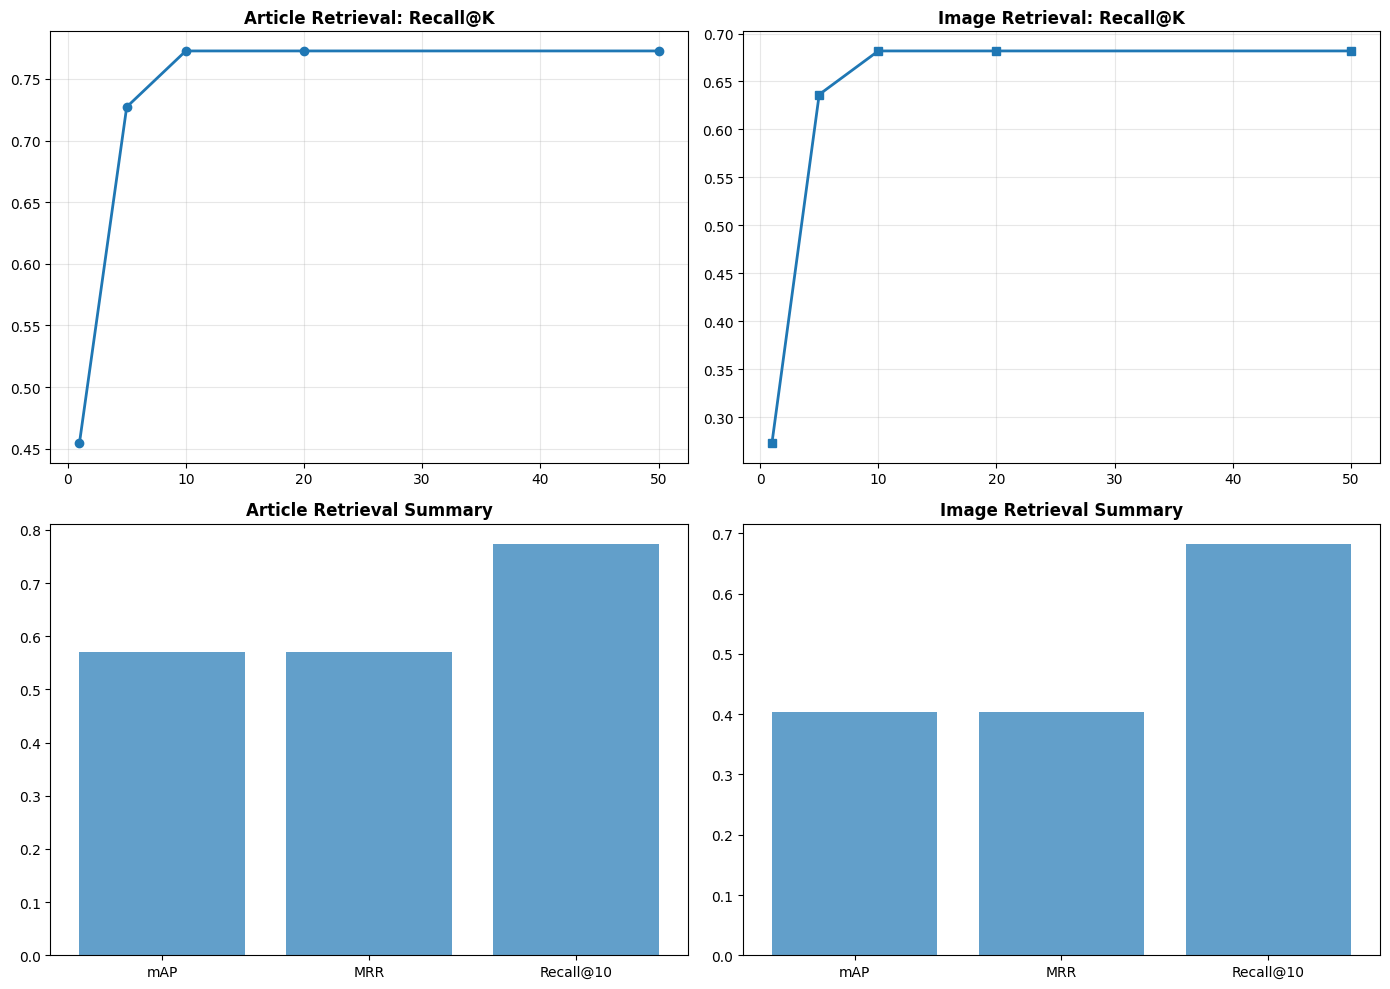

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:23,  1.95it/s]

  4%|▍         | 2/47 [00:00<00:19,  2.29it/s]

  6%|▋         | 3/47 [00:01<00:18,  2.33it/s]

  9%|▊         | 4/47 [00:01<00:18,  2.31it/s]

 11%|█         | 5/47 [00:02<00:17,  2.42it/s]

 13%|█▎        | 6/47 [00:02<00:17,  2.37it/s]

 15%|█▍        | 7/47 [00:02<00:16,  2.46it/s]

 17%|█▋        | 8/47 [00:03<00:15,  2.56it/s]

 19%|█▉        | 9/47 [00:03<00:14,  2.58it/s]

 21%|██▏       | 10/47 [00:04<00:15,  2.45it/s]

 23%|██▎       | 11/47 [00:04<00:14,  2.51it/s]

 26%|██▌       | 12/47 [00:04<00:13,  2.50it/s]

 28%|██▊       | 13/47 [00:05<00:13,  2.47it/s]

 30%|██▉       | 14/47 [00:05<00:12,  2.55it/s]

 32%|███▏      | 15/47 [00:06<00:12,  2.60it/s]

 34%|███▍      | 16/47 [00:06<00:11,  2.69it/s]

 36%|███▌      | 17/47 [00:06<00:11,  2.68it/s]

 38%|███▊      | 18/47 [00:07<00:10,  2.69it/s]

 40%|████      | 19/47 [00:07<00:10,  2.63it/s]

 43%|████▎     | 20/47 [00:07<00:10,  2.64it/s]

 45%|████▍     | 21/47 [00:08<00:10,  2.55it/s]

 47%|████▋     | 22/47 [00:08<00:09,  2.54it/s]

 49%|████▉     | 23/47 [00:09<00:09,  2.52it/s]

 51%|█████     | 24/47 [00:09<00:09,  2.37it/s]

 53%|█████▎    | 25/47 [00:10<00:08,  2.45it/s]

 55%|█████▌    | 26/47 [00:10<00:08,  2.50it/s]

 57%|█████▋    | 27/47 [00:10<00:07,  2.58it/s]

 60%|█████▉    | 28/47 [00:11<00:07,  2.61it/s]

 62%|██████▏   | 29/47 [00:11<00:06,  2.60it/s]

 64%|██████▍   | 30/47 [00:11<00:06,  2.55it/s]

 66%|██████▌   | 31/47 [00:12<00:06,  2.65it/s]

 68%|██████▊   | 32/47 [00:12<00:05,  2.87it/s]

 70%|███████   | 33/47 [00:12<00:04,  2.86it/s]

 72%|███████▏  | 34/47 [00:13<00:04,  2.92it/s]

 74%|███████▍  | 35/47 [00:13<00:03,  3.02it/s]

 77%|███████▋  | 36/47 [00:13<00:03,  2.90it/s]

 79%|███████▊  | 37/47 [00:14<00:03,  2.78it/s]

 81%|████████  | 38/47 [00:14<00:03,  2.66it/s]

 83%|████████▎ | 39/47 [00:15<00:03,  2.56it/s]

 85%|████████▌ | 40/47 [00:15<00:02,  2.45it/s]

 87%|████████▋ | 41/47 [00:16<00:02,  2.42it/s]

 89%|████████▉ | 42/47 [00:16<00:02,  2.31it/s]

 91%|█████████▏| 43/47 [00:16<00:01,  2.29it/s]

 94%|█████████▎| 44/47 [00:17<00:01,  2.09it/s]

 96%|█████████▌| 45/47 [00:17<00:00,  2.13it/s]

 98%|█████████▊| 46/47 [00:18<00:00,  2.27it/s]

100%|██████████| 47/47 [00:18<00:00,  2.35it/s]

100%|██████████| 47/47 [00:18<00:00,  2.51it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [03:26<2:38:37, 206.89s/it]

  4%|▍         | 2/47 [06:39<2:29:01, 198.70s/it]

  6%|▋         | 3/47 [09:51<2:23:28, 195.65s/it]

  9%|▊         | 4/47 [13:11<2:21:12, 197.03s/it]

 11%|█         | 5/47 [16:35<2:19:55, 199.89s/it]

 13%|█▎        | 6/47 [19:40<2:12:59, 194.62s/it]

 15%|█▍        | 7/47 [23:03<2:11:41, 197.53s/it]

 17%|█▋        | 8/47 [26:09<2:05:54, 193.70s/it]

 19%|█▉        | 9/47 [29:20<2:02:03, 192.73s/it]

 21%|██▏       | 10/47 [32:42<2:00:47, 195.88s/it]

 23%|██▎       | 11/47 [36:04<1:58:37, 197.72s/it]

 26%|██▌       | 12/47 [39:15<1:54:02, 195.51s/it]

 28%|██▊       | 13/47 [42:22<1:49:22, 193.01s/it]

 30%|██▉       | 14/47 [45:31<1:45:32, 191.90s/it]

 32%|███▏      | 15/47 [48:42<1:42:09, 191.54s/it]

 34%|███▍      | 16/47 [51:51<1:38:36, 190.87s/it]

 36%|███▌      | 17/47 [55:02<1:35:21, 190.73s/it]

 38%|███▊      | 18/47 [58:03<1:30:44, 187.73s/it]

 40%|████      | 19/47 [1:01:19<1:28:46, 190.24s/it]

 43%|████▎     | 20/47 [1:04:47<1:28:04, 195.72s/it]

 45%|████▍     | 21/47 [1:07:58<1:24:08, 194.18s/it]

 47%|████▋     | 22/47 [1:11:26<1:22:39, 198.38s/it]

 49%|████▉     | 23/47 [1:14:38<1:18:37, 196.55s/it]

 51%|█████     | 24/47 [1:17:53<1:15:08, 196.02s/it]

 53%|█████▎    | 25/47 [1:21:07<1:11:40, 195.48s/it]

 55%|█████▌    | 26/47 [1:24:24<1:08:35, 195.97s/it]

 57%|█████▋    | 27/47 [1:27:46<1:05:56, 197.80s/it]

 60%|█████▉    | 28/47 [1:31:07<1:02:56, 198.74s/it]

 62%|██████▏   | 29/47 [1:34:16<58:43, 195.74s/it]  

 64%|██████▍   | 30/47 [1:37:24<54:48, 193.45s/it]

 66%|██████▌   | 31/47 [1:40:33<51:12, 192.03s/it]

 68%|██████▊   | 32/47 [1:43:42<47:48, 191.26s/it]

 70%|███████   | 33/47 [1:46:46<44:07, 189.08s/it]

 72%|███████▏  | 34/47 [1:50:06<41:38, 192.19s/it]

 74%|███████▍  | 35/47 [1:53:40<39:46, 198.84s/it]

 77%|███████▋  | 36/47 [1:57:19<37:34, 204.97s/it]

 79%|███████▊  | 37/47 [2:01:09<35:22, 212.25s/it]

 81%|████████  | 38/47 [2:04:53<32:21, 215.77s/it]

 83%|████████▎ | 39/47 [2:08:49<29:36, 222.09s/it]

 85%|████████▌ | 40/47 [2:12:41<26:14, 224.87s/it]

 87%|████████▋ | 41/47 [2:16:24<22:26, 224.37s/it]

 89%|████████▉ | 42/47 [2:20:14<18:50, 226.16s/it]

 91%|█████████▏| 43/47 [2:24:13<15:19, 229.80s/it]

 94%|█████████▎| 44/47 [2:28:03<11:29, 229.88s/it]

 96%|█████████▌| 45/47 [2:32:01<07:44, 232.31s/it]

 98%|█████████▊| 46/47 [2:35:50<03:51, 231.42s/it]

100%|██████████| 47/47 [2:39:11<00:00, 222.38s/it]

100%|██████████| 47/47 [2:39:11<00:00, 203.23s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:27<22:42:27, 27.26s/it]

  0%|          | 2/3000 [00:37<14:09:14, 17.00s/it]

  0%|          | 3/3000 [00:40<8:52:07, 10.65s/it] 

  0%|          | 4/3000 [00:44<6:43:15,  8.08s/it]

  0%|          | 5/3000 [00:48<5:32:09,  6.65s/it]

  0%|          | 6/3000 [00:51<4:38:46,  5.59s/it]

  0%|          | 7/3000 [01:00<5:24:35,  6.51s/it]

  0%|          | 8/3000 [01:06<5:26:15,  6.54s/it]

  0%|          | 9/3000 [01:10<4:39:06,  5.60s/it]

  0%|          | 10/3000 [01:14<4:17:00,  5.16s/it]

  0%|          | 11/3000 [01:16<3:26:26,  4.14s/it]

  0%|          | 12/3000 [01:17<2:40:30,  3.22s/it]

  0%|          | 13/3000 [01:23<3:21:59,  4.06s/it]

  0%|          | 14/3000 [01:26<3:10:49,  3.83s/it]

  0%|          | 15/3000 [01:32<3:41:16,  4.45s/it]

  1%|          | 16/3000 [01:38<3:55:23,  4.73s/it]

  1%|          | 17/3000 [01:40<3:19:50,  4.02s/it]

  1%|          | 18/3000 [01:45<3:37:47,  4.38s/it]

  1%|          | 19/3000 [01:49<3:34:06,  4.31s/it]

  1%|          | 20/3000 [01:54<3:31:39,  4.26s/it]

  1%|          | 21/3000 [01:59<3:54:49,  4.73s/it]

  1%|          | 22/3000 [02:05<4:08:29,  5.01s/it]

  1%|          | 23/3000 [02:18<6:09:53,  7.45s/it]

  1%|          | 24/3000 [02:21<5:00:30,  6.06s/it]

  1%|          | 25/3000 [02:28<5:08:37,  6.22s/it]

  1%|          | 26/3000 [02:33<4:51:22,  5.88s/it]

  1%|          | 27/3000 [02:37<4:30:44,  5.46s/it]

  1%|          | 28/3000 [02:40<3:51:27,  4.67s/it]

  1%|          | 29/3000 [02:42<3:05:22,  3.74s/it]

  1%|          | 30/3000 [02:46<3:13:15,  3.90s/it]

  1%|          | 31/3000 [02:48<2:53:07,  3.50s/it]

  1%|          | 32/3000 [02:58<4:24:17,  5.34s/it]

  1%|          | 33/3000 [03:04<4:39:56,  5.66s/it]

  1%|          | 34/3000 [03:14<5:30:45,  6.69s/it]

  1%|          | 35/3000 [03:18<5:03:58,  6.15s/it]

  1%|          | 36/3000 [03:23<4:41:19,  5.69s/it]

  1%|          | 37/3000 [03:25<3:40:19,  4.46s/it]

  1%|▏         | 38/3000 [03:27<3:01:41,  3.68s/it]

  1%|▏         | 39/3000 [03:30<3:04:44,  3.74s/it]

  1%|▏         | 40/3000 [03:33<2:51:24,  3.47s/it]

  1%|▏         | 41/3000 [03:37<2:52:36,  3.50s/it]

  1%|▏         | 42/3000 [03:38<2:20:04,  2.84s/it]

  1%|▏         | 43/3000 [03:41<2:18:27,  2.81s/it]

  1%|▏         | 44/3000 [03:44<2:24:33,  2.93s/it]

  2%|▏         | 45/3000 [03:49<2:50:19,  3.46s/it]

  2%|▏         | 46/3000 [03:54<3:12:40,  3.91s/it]

  2%|▏         | 47/3000 [03:56<2:43:00,  3.31s/it]

  2%|▏         | 48/3000 [04:00<3:00:40,  3.67s/it]

  2%|▏         | 49/3000 [04:02<2:26:42,  2.98s/it]

  2%|▏         | 50/3000 [04:04<2:25:44,  2.96s/it]

  2%|▏         | 51/3000 [04:14<4:00:03,  4.88s/it]

  2%|▏         | 52/3000 [04:20<4:15:43,  5.20s/it]

  2%|▏         | 53/3000 [04:26<4:35:10,  5.60s/it]

  2%|▏         | 54/3000 [04:36<5:32:16,  6.77s/it]

  2%|▏         | 55/3000 [04:39<4:44:21,  5.79s/it]

  2%|▏         | 56/3000 [04:46<4:52:24,  5.96s/it]

  2%|▏         | 57/3000 [04:49<4:06:43,  5.03s/it]

  2%|▏         | 58/3000 [04:53<3:51:17,  4.72s/it]

  2%|▏         | 59/3000 [04:54<3:09:18,  3.86s/it]

  2%|▏         | 60/3000 [04:59<3:21:16,  4.11s/it]

  2%|▏         | 61/3000 [05:02<3:03:13,  3.74s/it]

  2%|▏         | 62/3000 [05:11<4:21:04,  5.33s/it]

  2%|▏         | 63/3000 [05:15<3:59:34,  4.89s/it]

  2%|▏         | 64/3000 [05:20<4:07:29,  5.06s/it]

  2%|▏         | 65/3000 [05:24<3:47:48,  4.66s/it]

  2%|▏         | 66/3000 [05:28<3:42:16,  4.55s/it]

  2%|▏         | 67/3000 [05:33<3:43:47,  4.58s/it]

  2%|▏         | 68/3000 [05:39<4:10:43,  5.13s/it]

  2%|▏         | 69/3000 [05:45<4:13:11,  5.18s/it]

  2%|▏         | 70/3000 [05:48<3:48:51,  4.69s/it]

  2%|▏         | 71/3000 [05:54<4:01:45,  4.95s/it]

  2%|▏         | 72/3000 [05:56<3:25:03,  4.20s/it]

  2%|▏         | 73/3000 [06:02<3:49:41,  4.71s/it]

  2%|▏         | 74/3000 [06:08<4:05:27,  5.03s/it]

  2%|▎         | 75/3000 [06:20<5:43:31,  7.05s/it]

  3%|▎         | 76/3000 [06:23<4:48:57,  5.93s/it]

  3%|▎         | 77/3000 [06:29<4:56:23,  6.08s/it]

  3%|▎         | 78/3000 [06:35<4:46:59,  5.89s/it]

  3%|▎         | 79/3000 [06:40<4:33:54,  5.63s/it]

  3%|▎         | 80/3000 [06:49<5:26:11,  6.70s/it]

  3%|▎         | 81/3000 [06:54<5:00:11,  6.17s/it]

  3%|▎         | 82/3000 [06:56<4:02:41,  4.99s/it]

  3%|▎         | 83/3000 [07:00<3:38:33,  4.50s/it]

  3%|▎         | 84/3000 [07:07<4:23:42,  5.43s/it]

  3%|▎         | 85/3000 [07:10<3:48:00,  4.69s/it]

  3%|▎         | 86/3000 [07:14<3:34:03,  4.41s/it]

  3%|▎         | 87/3000 [07:19<3:48:46,  4.71s/it]

  3%|▎         | 88/3000 [07:27<4:25:51,  5.48s/it]

  3%|▎         | 89/3000 [07:33<4:36:21,  5.70s/it]

  3%|▎         | 90/3000 [07:39<4:47:29,  5.93s/it]

  3%|▎         | 91/3000 [07:44<4:22:51,  5.42s/it]

  3%|▎         | 92/3000 [07:47<3:54:03,  4.83s/it]

  3%|▎         | 93/3000 [07:50<3:33:18,  4.40s/it]

  3%|▎         | 94/3000 [07:52<2:53:41,  3.59s/it]

  3%|▎         | 95/3000 [07:54<2:29:46,  3.09s/it]

  3%|▎         | 96/3000 [07:56<2:13:13,  2.75s/it]

  3%|▎         | 97/3000 [07:58<2:07:12,  2.63s/it]

  3%|▎         | 98/3000 [08:01<2:07:56,  2.65s/it]

  3%|▎         | 99/3000 [08:03<1:56:02,  2.40s/it]

  3%|▎         | 100/3000 [08:05<1:46:28,  2.20s/it]

  3%|▎         | 101/3000 [08:10<2:30:58,  3.12s/it]

  3%|▎         | 102/3000 [08:14<2:40:00,  3.31s/it]

  3%|▎         | 103/3000 [08:17<2:46:31,  3.45s/it]

  3%|▎         | 104/3000 [08:26<4:03:03,  5.04s/it]

  4%|▎         | 105/3000 [08:27<3:03:55,  3.81s/it]

  4%|▎         | 106/3000 [08:32<3:18:24,  4.11s/it]

  4%|▎         | 107/3000 [08:35<2:58:33,  3.70s/it]

  4%|▎         | 108/3000 [08:43<4:10:56,  5.21s/it]

  4%|▎         | 109/3000 [08:50<4:38:47,  5.79s/it]

  4%|▎         | 110/3000 [08:55<4:19:33,  5.39s/it]

  4%|▎         | 111/3000 [09:00<4:10:53,  5.21s/it]

  4%|▎         | 112/3000 [09:02<3:22:47,  4.21s/it]

  4%|▍         | 113/3000 [09:04<2:50:44,  3.55s/it]

  4%|▍         | 114/3000 [09:10<3:34:40,  4.46s/it]

  4%|▍         | 115/3000 [09:14<3:30:48,  4.38s/it]

  4%|▍         | 116/3000 [09:19<3:31:29,  4.40s/it]

  4%|▍         | 117/3000 [09:24<3:39:20,  4.56s/it]

  4%|▍         | 118/3000 [09:26<3:10:56,  3.98s/it]

  4%|▍         | 119/3000 [09:30<3:00:00,  3.75s/it]

  4%|▍         | 120/3000 [09:32<2:46:09,  3.46s/it]

  4%|▍         | 121/3000 [09:40<3:50:17,  4.80s/it]

  4%|▍         | 122/3000 [09:47<4:12:01,  5.25s/it]

  4%|▍         | 123/3000 [09:51<3:54:28,  4.89s/it]

  4%|▍         | 124/3000 [09:54<3:31:12,  4.41s/it]

  4%|▍         | 125/3000 [09:56<3:02:16,  3.80s/it]

  4%|▍         | 126/3000 [10:00<3:00:00,  3.76s/it]

  4%|▍         | 127/3000 [10:07<3:50:16,  4.81s/it]

  4%|▍         | 128/3000 [10:14<4:17:01,  5.37s/it]

  4%|▍         | 129/3000 [10:21<4:37:20,  5.80s/it]

  4%|▍         | 130/3000 [10:26<4:24:33,  5.53s/it]

  4%|▍         | 131/3000 [10:31<4:18:30,  5.41s/it]

  4%|▍         | 132/3000 [10:43<6:01:16,  7.56s/it]

  4%|▍         | 133/3000 [10:48<5:18:48,  6.67s/it]

  4%|▍         | 134/3000 [10:56<5:40:59,  7.14s/it]

  4%|▍         | 135/3000 [11:01<5:02:13,  6.33s/it]

  5%|▍         | 136/3000 [11:09<5:38:26,  7.09s/it]

  5%|▍         | 137/3000 [11:15<5:19:58,  6.71s/it]

  5%|▍         | 138/3000 [11:20<4:44:34,  5.97s/it]

  5%|▍         | 139/3000 [11:22<4:00:04,  5.03s/it]

  5%|▍         | 140/3000 [11:24<3:16:29,  4.12s/it]

  5%|▍         | 141/3000 [11:26<2:40:52,  3.38s/it]

  5%|▍         | 142/3000 [11:28<2:24:14,  3.03s/it]

  5%|▍         | 143/3000 [11:31<2:14:28,  2.82s/it]

  5%|▍         | 144/3000 [11:37<2:59:18,  3.77s/it]

  5%|▍         | 145/3000 [11:40<2:50:34,  3.58s/it]

  5%|▍         | 146/3000 [11:41<2:15:41,  2.85s/it]

  5%|▍         | 147/3000 [11:42<1:53:11,  2.38s/it]

  5%|▍         | 148/3000 [11:43<1:37:07,  2.04s/it]

  5%|▍         | 149/3000 [11:48<2:10:12,  2.74s/it]

  5%|▌         | 150/3000 [11:49<1:53:56,  2.40s/it]

  5%|▌         | 151/3000 [11:52<1:51:08,  2.34s/it]

  5%|▌         | 152/3000 [12:00<3:18:13,  4.18s/it]

  5%|▌         | 153/3000 [12:08<4:09:15,  5.25s/it]

  5%|▌         | 154/3000 [12:23<6:36:21,  8.36s/it]

  5%|▌         | 155/3000 [12:28<5:45:47,  7.29s/it]

  5%|▌         | 156/3000 [12:34<5:27:36,  6.91s/it]

  5%|▌         | 157/3000 [12:38<4:37:50,  5.86s/it]

  5%|▌         | 158/3000 [12:43<4:35:08,  5.81s/it]

  5%|▌         | 159/3000 [12:45<3:30:34,  4.45s/it]

  5%|▌         | 160/3000 [12:47<3:03:51,  3.88s/it]

  5%|▌         | 161/3000 [12:51<3:04:32,  3.90s/it]

  5%|▌         | 162/3000 [12:57<3:35:13,  4.55s/it]

  5%|▌         | 163/3000 [13:01<3:18:39,  4.20s/it]

  5%|▌         | 164/3000 [13:05<3:21:42,  4.27s/it]

  6%|▌         | 165/3000 [13:07<2:56:02,  3.73s/it]

  6%|▌         | 166/3000 [13:09<2:23:52,  3.05s/it]

  6%|▌         | 167/3000 [13:12<2:22:47,  3.02s/it]

  6%|▌         | 168/3000 [13:16<2:33:17,  3.25s/it]

  6%|▌         | 169/3000 [13:17<2:10:59,  2.78s/it]

  6%|▌         | 170/3000 [13:19<1:52:28,  2.38s/it]

  6%|▌         | 171/3000 [13:23<2:18:16,  2.93s/it]

  6%|▌         | 172/3000 [13:24<1:52:22,  2.38s/it]

  6%|▌         | 173/3000 [13:30<2:39:25,  3.38s/it]

  6%|▌         | 174/3000 [13:36<3:16:54,  4.18s/it]

  6%|▌         | 175/3000 [13:40<3:12:03,  4.08s/it]

  6%|▌         | 176/3000 [13:43<3:05:43,  3.95s/it]

  6%|▌         | 177/3000 [13:46<2:49:09,  3.60s/it]

  6%|▌         | 178/3000 [13:50<2:57:25,  3.77s/it]

  6%|▌         | 179/3000 [13:54<2:51:54,  3.66s/it]

  6%|▌         | 180/3000 [13:57<2:48:38,  3.59s/it]

  6%|▌         | 181/3000 [14:01<2:50:42,  3.63s/it]

  6%|▌         | 182/3000 [14:05<2:56:45,  3.76s/it]

  6%|▌         | 183/3000 [14:10<3:13:09,  4.11s/it]

  6%|▌         | 184/3000 [14:16<3:41:46,  4.73s/it]

  6%|▌         | 185/3000 [14:18<3:05:24,  3.95s/it]

  6%|▌         | 186/3000 [14:25<3:41:51,  4.73s/it]

  6%|▌         | 187/3000 [14:27<3:11:46,  4.09s/it]

  6%|▋         | 188/3000 [14:32<3:24:35,  4.37s/it]

  6%|▋         | 189/3000 [14:38<3:38:33,  4.67s/it]

  6%|▋         | 190/3000 [14:40<3:06:26,  3.98s/it]

  6%|▋         | 191/3000 [14:43<2:51:24,  3.66s/it]

  6%|▋         | 192/3000 [14:47<2:58:14,  3.81s/it]

  6%|▋         | 193/3000 [14:57<4:20:50,  5.58s/it]

  6%|▋         | 194/3000 [14:59<3:40:18,  4.71s/it]

  6%|▋         | 195/3000 [15:08<4:35:32,  5.89s/it]

  7%|▋         | 196/3000 [15:13<4:23:01,  5.63s/it]

  7%|▋         | 197/3000 [15:18<4:11:20,  5.38s/it]

  7%|▋         | 198/3000 [15:22<3:45:58,  4.84s/it]

  7%|▋         | 199/3000 [15:27<3:54:18,  5.02s/it]

  7%|▋         | 200/3000 [15:31<3:36:27,  4.64s/it]

  7%|▋         | 201/3000 [15:35<3:26:41,  4.43s/it]

  7%|▋         | 202/3000 [15:40<3:41:33,  4.75s/it]

  7%|▋         | 203/3000 [15:45<3:37:18,  4.66s/it]

  7%|▋         | 204/3000 [15:48<3:21:53,  4.33s/it]

  7%|▋         | 205/3000 [15:51<3:05:16,  3.98s/it]

  7%|▋         | 206/3000 [15:59<3:56:21,  5.08s/it]

  7%|▋         | 207/3000 [16:06<4:22:20,  5.64s/it]

  7%|▋         | 208/3000 [16:09<3:52:58,  5.01s/it]

  7%|▋         | 209/3000 [16:26<6:32:12,  8.43s/it]

  7%|▋         | 210/3000 [16:36<6:56:01,  8.95s/it]

  7%|▋         | 211/3000 [16:46<7:05:54,  9.16s/it]

  7%|▋         | 212/3000 [16:48<5:35:08,  7.21s/it]

  7%|▋         | 213/3000 [16:51<4:33:26,  5.89s/it]

  7%|▋         | 214/3000 [16:57<4:32:48,  5.88s/it]

  7%|▋         | 215/3000 [17:01<4:10:07,  5.39s/it]

  7%|▋         | 216/3000 [17:05<3:52:35,  5.01s/it]

  7%|▋         | 217/3000 [17:09<3:33:16,  4.60s/it]

  7%|▋         | 218/3000 [17:13<3:30:15,  4.53s/it]

  7%|▋         | 219/3000 [17:18<3:30:29,  4.54s/it]

  7%|▋         | 220/3000 [17:24<3:55:22,  5.08s/it]

  7%|▋         | 221/3000 [17:34<4:57:47,  6.43s/it]

  7%|▋         | 222/3000 [17:39<4:45:03,  6.16s/it]

  7%|▋         | 223/3000 [17:46<4:57:05,  6.42s/it]

  7%|▋         | 224/3000 [17:51<4:30:54,  5.86s/it]

  8%|▊         | 225/3000 [17:54<3:47:18,  4.91s/it]

  8%|▊         | 226/3000 [18:02<4:38:22,  6.02s/it]

  8%|▊         | 227/3000 [18:10<5:04:44,  6.59s/it]

  8%|▊         | 228/3000 [18:16<4:54:19,  6.37s/it]

  8%|▊         | 229/3000 [18:20<4:20:18,  5.64s/it]

  8%|▊         | 230/3000 [18:24<4:03:50,  5.28s/it]

  8%|▊         | 231/3000 [18:26<3:11:30,  4.15s/it]

  8%|▊         | 232/3000 [18:32<3:39:30,  4.76s/it]

  8%|▊         | 233/3000 [18:35<3:11:18,  4.15s/it]

  8%|▊         | 234/3000 [18:41<3:31:51,  4.60s/it]

  8%|▊         | 235/3000 [18:46<3:41:10,  4.80s/it]

  8%|▊         | 236/3000 [18:49<3:17:54,  4.30s/it]

  8%|▊         | 237/3000 [18:52<3:00:29,  3.92s/it]

  8%|▊         | 238/3000 [19:04<4:48:24,  6.27s/it]

  8%|▊         | 239/3000 [19:07<4:03:58,  5.30s/it]

  8%|▊         | 240/3000 [19:13<4:11:38,  5.47s/it]

  8%|▊         | 241/3000 [19:20<4:35:32,  5.99s/it]

  8%|▊         | 242/3000 [19:24<4:12:29,  5.49s/it]

  8%|▊         | 243/3000 [19:27<3:35:09,  4.68s/it]

  8%|▊         | 244/3000 [19:34<4:11:08,  5.47s/it]

  8%|▊         | 245/3000 [19:37<3:37:10,  4.73s/it]

  8%|▊         | 246/3000 [19:42<3:33:59,  4.66s/it]

  8%|▊         | 247/3000 [19:46<3:25:17,  4.47s/it]

  8%|▊         | 248/3000 [19:50<3:22:41,  4.42s/it]

  8%|▊         | 249/3000 [19:56<3:38:22,  4.76s/it]

  8%|▊         | 250/3000 [19:59<3:12:42,  4.20s/it]

  8%|▊         | 251/3000 [20:05<3:49:36,  5.01s/it]

  8%|▊         | 252/3000 [20:07<3:00:06,  3.93s/it]

  8%|▊         | 253/3000 [20:10<2:45:58,  3.63s/it]

  8%|▊         | 254/3000 [20:14<3:01:10,  3.96s/it]

  8%|▊         | 255/3000 [20:19<3:05:14,  4.05s/it]

  9%|▊         | 256/3000 [20:21<2:44:23,  3.59s/it]

  9%|▊         | 257/3000 [20:22<2:06:23,  2.76s/it]

  9%|▊         | 258/3000 [20:29<2:57:05,  3.87s/it]

  9%|▊         | 259/3000 [20:31<2:42:12,  3.55s/it]

  9%|▊         | 260/3000 [20:35<2:40:41,  3.52s/it]

  9%|▊         | 261/3000 [20:38<2:34:26,  3.38s/it]

  9%|▊         | 262/3000 [20:41<2:28:55,  3.26s/it]

  9%|▉         | 263/3000 [20:43<2:16:59,  3.00s/it]

  9%|▉         | 264/3000 [20:47<2:24:22,  3.17s/it]

  9%|▉         | 265/3000 [20:52<2:48:03,  3.69s/it]

  9%|▉         | 266/3000 [21:00<3:46:49,  4.98s/it]

  9%|▉         | 267/3000 [21:02<3:10:23,  4.18s/it]

  9%|▉         | 268/3000 [21:27<7:49:37, 10.31s/it]

  9%|▉         | 269/3000 [21:36<7:32:45,  9.95s/it]

  9%|▉         | 270/3000 [21:50<8:28:58, 11.19s/it]

  9%|▉         | 271/3000 [22:01<8:31:27, 11.24s/it]

  9%|▉         | 272/3000 [22:49<16:48:14, 22.18s/it]

  9%|▉         | 273/3000 [23:03<14:54:11, 19.67s/it]

  9%|▉         | 274/3000 [23:18<13:53:18, 18.34s/it]

  9%|▉         | 275/3000 [23:29<12:08:24, 16.04s/it]

  9%|▉         | 276/3000 [23:39<10:45:26, 14.22s/it]

  9%|▉         | 277/3000 [23:47<9:22:52, 12.40s/it] 

  9%|▉         | 278/3000 [24:02<10:07:46, 13.40s/it]

  9%|▉         | 279/3000 [24:27<12:38:11, 16.72s/it]

  9%|▉         | 280/3000 [24:41<12:06:53, 16.03s/it]

  9%|▉         | 281/3000 [25:10<14:52:20, 19.69s/it]

  9%|▉         | 282/3000 [25:16<11:55:06, 15.79s/it]

  9%|▉         | 283/3000 [25:32<11:50:58, 15.70s/it]

  9%|▉         | 284/3000 [25:40<10:06:20, 13.39s/it]

 10%|▉         | 285/3000 [25:51<9:35:55, 12.73s/it] 

 10%|▉         | 286/3000 [26:03<9:23:03, 12.45s/it]

 10%|▉         | 287/3000 [26:15<9:25:57, 12.52s/it]

 10%|▉         | 288/3000 [26:27<9:17:17, 12.33s/it]

 10%|▉         | 289/3000 [26:41<9:31:56, 12.66s/it]

 10%|▉         | 290/3000 [26:58<10:27:41, 13.90s/it]

 10%|▉         | 291/3000 [27:23<13:00:12, 17.28s/it]

 10%|▉         | 292/3000 [28:14<20:36:56, 27.41s/it]

 10%|▉         | 293/3000 [28:31<18:20:31, 24.39s/it]

 10%|▉         | 294/3000 [28:46<16:15:37, 21.63s/it]

 10%|▉         | 295/3000 [29:05<15:38:25, 20.82s/it]

 10%|▉         | 296/3000 [29:20<14:22:25, 19.14s/it]

 10%|▉         | 297/3000 [29:29<12:04:48, 16.09s/it]

 10%|▉         | 298/3000 [29:37<10:07:04, 13.48s/it]

 10%|▉         | 299/3000 [29:43<8:29:24, 11.32s/it] 

 10%|█         | 300/3000 [29:51<7:38:40, 10.19s/it]

 10%|█         | 301/3000 [29:56<6:34:25,  8.77s/it]

 10%|█         | 302/3000 [29:59<5:19:24,  7.10s/it]

 10%|█         | 303/3000 [30:03<4:30:03,  6.01s/it]

 10%|█         | 304/3000 [30:06<3:50:11,  5.12s/it]

 10%|█         | 305/3000 [30:09<3:22:36,  4.51s/it]

 10%|█         | 306/3000 [30:13<3:21:58,  4.50s/it]

 10%|█         | 307/3000 [30:17<3:14:29,  4.33s/it]

 10%|█         | 308/3000 [30:24<3:47:06,  5.06s/it]

 10%|█         | 309/3000 [30:27<3:21:21,  4.49s/it]

 10%|█         | 310/3000 [30:31<3:09:17,  4.22s/it]

 10%|█         | 311/3000 [30:51<6:43:55,  9.01s/it]

 10%|█         | 312/3000 [31:01<6:58:04,  9.33s/it]

 10%|█         | 313/3000 [31:14<7:44:23, 10.37s/it]

 10%|█         | 314/3000 [31:28<8:28:59, 11.37s/it]

 10%|█         | 315/3000 [31:38<8:12:42, 11.01s/it]

 11%|█         | 316/3000 [31:52<9:00:29, 12.08s/it]

 11%|█         | 317/3000 [31:58<7:39:32, 10.28s/it]

 11%|█         | 318/3000 [32:00<5:37:16,  7.55s/it]

 11%|█         | 319/3000 [32:06<5:28:12,  7.35s/it]

 11%|█         | 320/3000 [32:09<4:19:45,  5.82s/it]

 11%|█         | 321/3000 [32:13<3:53:50,  5.24s/it]

 11%|█         | 322/3000 [32:17<3:47:43,  5.10s/it]

 11%|█         | 323/3000 [32:22<3:44:05,  5.02s/it]

 11%|█         | 324/3000 [32:31<4:30:02,  6.05s/it]

 11%|█         | 325/3000 [32:33<3:38:32,  4.90s/it]

 11%|█         | 326/3000 [32:35<3:00:17,  4.05s/it]

 11%|█         | 327/3000 [32:40<3:09:20,  4.25s/it]

 11%|█         | 328/3000 [32:45<3:20:07,  4.49s/it]

 11%|█         | 329/3000 [32:51<3:42:05,  4.99s/it]

 11%|█         | 330/3000 [32:53<3:07:43,  4.22s/it]

 11%|█         | 331/3000 [32:56<2:53:05,  3.89s/it]

 11%|█         | 332/3000 [32:58<2:21:55,  3.19s/it]

 11%|█         | 333/3000 [33:02<2:28:40,  3.34s/it]

 11%|█         | 334/3000 [33:04<2:16:15,  3.07s/it]

 11%|█         | 335/3000 [33:10<2:59:26,  4.04s/it]

 11%|█         | 336/3000 [33:14<2:49:45,  3.82s/it]

 11%|█         | 337/3000 [33:18<2:49:43,  3.82s/it]

 11%|█▏        | 338/3000 [33:21<2:46:02,  3.74s/it]

 11%|█▏        | 339/3000 [33:23<2:25:12,  3.27s/it]

 11%|█▏        | 340/3000 [33:29<2:59:24,  4.05s/it]

 11%|█▏        | 341/3000 [33:35<3:18:13,  4.47s/it]

 11%|█▏        | 342/3000 [33:41<3:49:00,  5.17s/it]

 11%|█▏        | 343/3000 [33:46<3:47:09,  5.13s/it]

 11%|█▏        | 344/3000 [33:49<3:18:40,  4.49s/it]

 12%|█▏        | 345/3000 [33:52<2:49:13,  3.82s/it]

 12%|█▏        | 346/3000 [33:57<3:10:16,  4.30s/it]

 12%|█▏        | 347/3000 [34:00<2:45:05,  3.73s/it]

 12%|█▏        | 348/3000 [34:03<2:47:48,  3.80s/it]

 12%|█▏        | 349/3000 [34:11<3:32:34,  4.81s/it]

 12%|█▏        | 350/3000 [34:13<2:56:00,  3.98s/it]

 12%|█▏        | 351/3000 [34:19<3:31:08,  4.78s/it]

 12%|█▏        | 352/3000 [34:22<3:06:57,  4.24s/it]

 12%|█▏        | 353/3000 [34:30<3:56:55,  5.37s/it]

 12%|█▏        | 354/3000 [34:33<3:14:45,  4.42s/it]

 12%|█▏        | 355/3000 [34:39<3:40:11,  4.99s/it]

 12%|█▏        | 356/3000 [34:43<3:34:37,  4.87s/it]

 12%|█▏        | 357/3000 [34:48<3:31:03,  4.79s/it]

 12%|█▏        | 358/3000 [34:50<2:59:15,  4.07s/it]

 12%|█▏        | 359/3000 [34:55<3:01:37,  4.13s/it]

 12%|█▏        | 360/3000 [35:01<3:33:42,  4.86s/it]

 12%|█▏        | 361/3000 [35:06<3:28:54,  4.75s/it]

 12%|█▏        | 362/3000 [35:13<4:05:31,  5.58s/it]

 12%|█▏        | 363/3000 [35:15<3:19:57,  4.55s/it]

 12%|█▏        | 364/3000 [35:17<2:37:31,  3.59s/it]

 12%|█▏        | 365/3000 [35:18<2:07:46,  2.91s/it]

 12%|█▏        | 366/3000 [35:22<2:15:50,  3.09s/it]

 12%|█▏        | 367/3000 [35:23<1:57:53,  2.69s/it]

 12%|█▏        | 368/3000 [35:28<2:28:56,  3.40s/it]

 12%|█▏        | 369/3000 [35:32<2:25:18,  3.31s/it]

 12%|█▏        | 370/3000 [35:36<2:44:50,  3.76s/it]

 12%|█▏        | 371/3000 [35:39<2:34:35,  3.53s/it]

 12%|█▏        | 372/3000 [35:42<2:25:56,  3.33s/it]

 12%|█▏        | 373/3000 [35:46<2:27:23,  3.37s/it]

 12%|█▏        | 374/3000 [35:49<2:30:59,  3.45s/it]

 12%|█▎        | 375/3000 [35:53<2:28:50,  3.40s/it]

 13%|█▎        | 376/3000 [35:55<2:21:18,  3.23s/it]

 13%|█▎        | 377/3000 [35:59<2:21:47,  3.24s/it]

 13%|█▎        | 378/3000 [36:02<2:20:03,  3.21s/it]

 13%|█▎        | 379/3000 [36:05<2:15:27,  3.10s/it]

 13%|█▎        | 380/3000 [36:08<2:15:16,  3.10s/it]

 13%|█▎        | 381/3000 [36:13<2:48:08,  3.85s/it]

 13%|█▎        | 382/3000 [36:20<3:20:25,  4.59s/it]

 13%|█▎        | 383/3000 [36:23<3:00:14,  4.13s/it]

 13%|█▎        | 384/3000 [36:26<2:46:32,  3.82s/it]

 13%|█▎        | 385/3000 [36:29<2:44:43,  3.78s/it]

 13%|█▎        | 386/3000 [36:32<2:29:50,  3.44s/it]

 13%|█▎        | 387/3000 [36:38<2:55:38,  4.03s/it]

 13%|█▎        | 388/3000 [36:43<3:16:29,  4.51s/it]

 13%|█▎        | 389/3000 [36:47<3:04:18,  4.24s/it]

 13%|█▎        | 390/3000 [36:49<2:39:46,  3.67s/it]

 13%|█▎        | 391/3000 [36:52<2:29:07,  3.43s/it]

 13%|█▎        | 392/3000 [36:55<2:19:40,  3.21s/it]

 13%|█▎        | 393/3000 [36:59<2:29:56,  3.45s/it]

 13%|█▎        | 394/3000 [37:03<2:39:36,  3.67s/it]

 13%|█▎        | 395/3000 [37:06<2:36:22,  3.60s/it]

 13%|█▎        | 396/3000 [37:08<2:06:14,  2.91s/it]

 13%|█▎        | 397/3000 [37:09<1:52:15,  2.59s/it]

 13%|█▎        | 398/3000 [37:11<1:34:26,  2.18s/it]

 13%|█▎        | 399/3000 [37:14<1:54:40,  2.65s/it]

 13%|█▎        | 400/3000 [37:17<1:52:34,  2.60s/it]

 13%|█▎        | 401/3000 [37:19<1:43:26,  2.39s/it]

 13%|█▎        | 402/3000 [37:22<1:47:40,  2.49s/it]

 13%|█▎        | 403/3000 [37:26<2:06:51,  2.93s/it]

 13%|█▎        | 404/3000 [37:30<2:31:54,  3.51s/it]

 14%|█▎        | 405/3000 [37:33<2:21:11,  3.26s/it]

 14%|█▎        | 406/3000 [37:38<2:38:20,  3.66s/it]

 14%|█▎        | 407/3000 [37:43<3:03:26,  4.24s/it]

 14%|█▎        | 408/3000 [37:50<3:33:00,  4.93s/it]

 14%|█▎        | 409/3000 [37:52<2:57:03,  4.10s/it]

 14%|█▎        | 410/3000 [37:54<2:30:09,  3.48s/it]

 14%|█▎        | 411/3000 [37:56<2:16:29,  3.16s/it]

 14%|█▎        | 412/3000 [38:00<2:26:47,  3.40s/it]

 14%|█▍        | 413/3000 [38:04<2:26:49,  3.41s/it]

 14%|█▍        | 414/3000 [38:08<2:40:13,  3.72s/it]

 14%|█▍        | 415/3000 [38:09<2:07:28,  2.96s/it]

 14%|█▍        | 416/3000 [38:12<2:06:06,  2.93s/it]

 14%|█▍        | 417/3000 [38:14<1:47:40,  2.50s/it]

 14%|█▍        | 418/3000 [38:16<1:48:26,  2.52s/it]

 14%|█▍        | 419/3000 [38:19<1:44:53,  2.44s/it]

 14%|█▍        | 420/3000 [38:21<1:46:25,  2.48s/it]

 14%|█▍        | 421/3000 [38:23<1:42:25,  2.38s/it]

 14%|█▍        | 422/3000 [38:25<1:39:44,  2.32s/it]

 14%|█▍        | 423/3000 [38:27<1:30:52,  2.12s/it]

 14%|█▍        | 424/3000 [38:34<2:34:00,  3.59s/it]

 14%|█▍        | 425/3000 [38:38<2:39:31,  3.72s/it]

 14%|█▍        | 426/3000 [38:40<2:19:14,  3.25s/it]

 14%|█▍        | 427/3000 [38:45<2:36:03,  3.64s/it]

 14%|█▍        | 428/3000 [38:46<2:04:51,  2.91s/it]

 14%|█▍        | 429/3000 [38:50<2:18:59,  3.24s/it]

 14%|█▍        | 430/3000 [38:53<2:14:26,  3.14s/it]

 14%|█▍        | 431/3000 [38:56<2:16:34,  3.19s/it]

 14%|█▍        | 432/3000 [38:59<2:06:12,  2.95s/it]

 14%|█▍        | 433/3000 [39:03<2:24:25,  3.38s/it]

 14%|█▍        | 434/3000 [39:06<2:20:26,  3.28s/it]

 14%|█▍        | 435/3000 [39:10<2:22:23,  3.33s/it]

 15%|█▍        | 436/3000 [39:13<2:22:50,  3.34s/it]

 15%|█▍        | 437/3000 [39:15<2:05:52,  2.95s/it]

 15%|█▍        | 438/3000 [39:17<1:52:21,  2.63s/it]

 15%|█▍        | 439/3000 [39:19<1:39:54,  2.34s/it]

 15%|█▍        | 440/3000 [39:27<3:04:09,  4.32s/it]

 15%|█▍        | 441/3000 [39:34<3:31:24,  4.96s/it]

 15%|█▍        | 442/3000 [39:39<3:38:23,  5.12s/it]

 15%|█▍        | 443/3000 [39:42<3:12:10,  4.51s/it]

 15%|█▍        | 444/3000 [39:48<3:21:01,  4.72s/it]

 15%|█▍        | 445/3000 [39:58<4:33:28,  6.42s/it]

 15%|█▍        | 446/3000 [40:02<3:59:10,  5.62s/it]

 15%|█▍        | 447/3000 [40:05<3:21:31,  4.74s/it]

 15%|█▍        | 448/3000 [40:09<3:23:41,  4.79s/it]

 15%|█▍        | 449/3000 [40:14<3:25:30,  4.83s/it]

 15%|█▌        | 450/3000 [40:20<3:30:36,  4.96s/it]

 15%|█▌        | 451/3000 [40:24<3:23:26,  4.79s/it]

 15%|█▌        | 452/3000 [40:28<3:12:31,  4.53s/it]

 15%|█▌        | 453/3000 [40:33<3:19:59,  4.71s/it]

 15%|█▌        | 454/3000 [40:35<2:50:29,  4.02s/it]

 15%|█▌        | 455/3000 [40:41<3:05:31,  4.37s/it]

 15%|█▌        | 456/3000 [40:45<3:03:50,  4.34s/it]

 15%|█▌        | 457/3000 [40:47<2:39:45,  3.77s/it]

 15%|█▌        | 458/3000 [40:51<2:33:50,  3.63s/it]

 15%|█▌        | 459/3000 [40:56<2:51:56,  4.06s/it]

 15%|█▌        | 460/3000 [41:02<3:16:48,  4.65s/it]

 15%|█▌        | 461/3000 [41:08<3:34:17,  5.06s/it]

 15%|█▌        | 462/3000 [41:12<3:21:48,  4.77s/it]

 15%|█▌        | 463/3000 [41:15<3:05:14,  4.38s/it]

 15%|█▌        | 464/3000 [41:31<5:34:01,  7.90s/it]

 16%|█▌        | 465/3000 [41:36<4:55:27,  6.99s/it]

 16%|█▌        | 466/3000 [41:42<4:43:33,  6.71s/it]

 16%|█▌        | 467/3000 [41:54<5:39:03,  8.03s/it]

 16%|█▌        | 468/3000 [41:59<5:01:56,  7.16s/it]

 16%|█▌        | 469/3000 [42:02<4:09:14,  5.91s/it]

 16%|█▌        | 470/3000 [42:05<3:41:46,  5.26s/it]

 16%|█▌        | 471/3000 [42:10<3:35:41,  5.12s/it]

 16%|█▌        | 472/3000 [42:22<4:59:00,  7.10s/it]

 16%|█▌        | 473/3000 [42:28<4:52:13,  6.94s/it]

 16%|█▌        | 474/3000 [42:34<4:30:20,  6.42s/it]

 16%|█▌        | 475/3000 [42:39<4:10:44,  5.96s/it]

 16%|█▌        | 476/3000 [42:46<4:28:28,  6.38s/it]

 16%|█▌        | 477/3000 [42:57<5:23:04,  7.68s/it]

 16%|█▌        | 478/3000 [43:07<5:53:18,  8.41s/it]

 16%|█▌        | 479/3000 [43:20<6:52:06,  9.81s/it]

 16%|█▌        | 480/3000 [43:25<5:59:48,  8.57s/it]

 16%|█▌        | 481/3000 [43:31<5:16:26,  7.54s/it]

 16%|█▌        | 482/3000 [43:37<4:58:18,  7.11s/it]

 16%|█▌        | 483/3000 [43:43<4:53:47,  7.00s/it]

 16%|█▌        | 484/3000 [43:50<4:50:21,  6.92s/it]

 16%|█▌        | 485/3000 [43:54<4:06:02,  5.87s/it]

 16%|█▌        | 486/3000 [44:04<5:02:12,  7.21s/it]

 16%|█▌        | 487/3000 [44:06<3:53:50,  5.58s/it]

 16%|█▋        | 488/3000 [44:15<4:43:10,  6.76s/it]

 16%|█▋        | 489/3000 [44:19<4:10:01,  5.97s/it]

 16%|█▋        | 490/3000 [44:29<4:50:37,  6.95s/it]

 16%|█▋        | 491/3000 [44:31<3:50:13,  5.51s/it]

 16%|█▋        | 492/3000 [44:41<4:46:29,  6.85s/it]

 16%|█▋        | 493/3000 [44:48<4:52:41,  7.01s/it]

 16%|█▋        | 494/3000 [44:57<5:13:03,  7.50s/it]

 16%|█▋        | 495/3000 [45:09<6:07:48,  8.81s/it]

 17%|█▋        | 496/3000 [45:16<5:54:54,  8.50s/it]

 17%|█▋        | 497/3000 [45:29<6:49:56,  9.83s/it]

 17%|█▋        | 498/3000 [45:38<6:36:31,  9.51s/it]

 17%|█▋        | 499/3000 [45:40<5:00:46,  7.22s/it]

 17%|█▋        | 500/3000 [45:44<4:23:20,  6.32s/it]

 17%|█▋        | 501/3000 [45:49<4:05:41,  5.90s/it]

 17%|█▋        | 502/3000 [45:52<3:27:51,  4.99s/it]

 17%|█▋        | 503/3000 [45:55<3:00:46,  4.34s/it]

 17%|█▋        | 504/3000 [45:59<3:01:07,  4.35s/it]

 17%|█▋        | 505/3000 [46:05<3:19:00,  4.79s/it]

 17%|█▋        | 506/3000 [46:13<3:56:27,  5.69s/it]

 17%|█▋        | 507/3000 [46:17<3:36:37,  5.21s/it]

 17%|█▋        | 508/3000 [46:18<2:50:58,  4.12s/it]

 17%|█▋        | 509/3000 [46:24<3:14:48,  4.69s/it]

 17%|█▋        | 510/3000 [46:29<3:09:07,  4.56s/it]

 17%|█▋        | 511/3000 [46:33<3:10:35,  4.59s/it]

 17%|█▋        | 512/3000 [46:39<3:24:09,  4.92s/it]

 17%|█▋        | 513/3000 [46:43<3:08:07,  4.54s/it]

 17%|█▋        | 514/3000 [46:50<3:47:53,  5.50s/it]

 17%|█▋        | 515/3000 [46:55<3:31:24,  5.10s/it]

 17%|█▋        | 516/3000 [46:56<2:47:17,  4.04s/it]

 17%|█▋        | 517/3000 [47:03<3:21:49,  4.88s/it]

 17%|█▋        | 518/3000 [47:06<2:59:07,  4.33s/it]

 17%|█▋        | 519/3000 [47:08<2:34:07,  3.73s/it]

 17%|█▋        | 520/3000 [47:11<2:18:29,  3.35s/it]

 17%|█▋        | 521/3000 [47:15<2:30:09,  3.63s/it]

 17%|█▋        | 522/3000 [47:18<2:13:53,  3.24s/it]

 17%|█▋        | 523/3000 [47:23<2:39:52,  3.87s/it]

 17%|█▋        | 524/3000 [47:26<2:34:50,  3.75s/it]

 18%|█▊        | 525/3000 [47:33<3:08:04,  4.56s/it]

 18%|█▊        | 526/3000 [47:37<3:04:09,  4.47s/it]

 18%|█▊        | 527/3000 [47:47<4:15:02,  6.19s/it]

 18%|█▊        | 528/3000 [47:51<3:43:55,  5.44s/it]

 18%|█▊        | 529/3000 [47:56<3:39:06,  5.32s/it]

 18%|█▊        | 530/3000 [48:03<3:55:09,  5.71s/it]

 18%|█▊        | 531/3000 [48:06<3:20:51,  4.88s/it]

 18%|█▊        | 532/3000 [48:11<3:34:05,  5.20s/it]

 18%|█▊        | 533/3000 [48:19<4:04:23,  5.94s/it]

 18%|█▊        | 534/3000 [48:22<3:30:17,  5.12s/it]

 18%|█▊        | 535/3000 [48:27<3:29:28,  5.10s/it]

 18%|█▊        | 536/3000 [48:30<2:57:55,  4.33s/it]

 18%|█▊        | 537/3000 [48:34<2:54:21,  4.25s/it]

 18%|█▊        | 538/3000 [48:40<3:20:26,  4.88s/it]

 18%|█▊        | 539/3000 [48:43<2:55:18,  4.27s/it]

 18%|█▊        | 540/3000 [48:49<3:19:21,  4.86s/it]

 18%|█▊        | 541/3000 [48:58<4:06:41,  6.02s/it]

 18%|█▊        | 542/3000 [49:01<3:33:21,  5.21s/it]

 18%|█▊        | 543/3000 [49:04<3:02:29,  4.46s/it]

 18%|█▊        | 544/3000 [49:07<2:45:31,  4.04s/it]

 18%|█▊        | 545/3000 [49:12<2:50:47,  4.17s/it]

 18%|█▊        | 546/3000 [49:15<2:42:35,  3.98s/it]

 18%|█▊        | 547/3000 [49:19<2:37:07,  3.84s/it]

 18%|█▊        | 548/3000 [49:23<2:36:59,  3.84s/it]

 18%|█▊        | 549/3000 [49:28<3:01:08,  4.43s/it]

 18%|█▊        | 550/3000 [49:32<2:45:10,  4.05s/it]

 18%|█▊        | 551/3000 [49:42<4:02:13,  5.93s/it]

 18%|█▊        | 552/3000 [49:45<3:31:42,  5.19s/it]

 18%|█▊        | 553/3000 [49:47<2:53:25,  4.25s/it]

 18%|█▊        | 554/3000 [49:52<2:51:46,  4.21s/it]

 18%|█▊        | 555/3000 [49:57<3:11:15,  4.69s/it]

 19%|█▊        | 556/3000 [50:00<2:44:26,  4.04s/it]

 19%|█▊        | 557/3000 [50:01<2:14:34,  3.31s/it]

 19%|█▊        | 558/3000 [50:07<2:45:32,  4.07s/it]

 19%|█▊        | 559/3000 [50:09<2:20:13,  3.45s/it]

 19%|█▊        | 560/3000 [50:12<2:16:29,  3.36s/it]

 19%|█▊        | 561/3000 [50:16<2:14:12,  3.30s/it]

 19%|█▊        | 562/3000 [50:20<2:28:00,  3.64s/it]

 19%|█▉        | 563/3000 [50:24<2:31:56,  3.74s/it]

 19%|█▉        | 564/3000 [50:26<2:09:51,  3.20s/it]

 19%|█▉        | 565/3000 [50:40<4:16:44,  6.33s/it]

 19%|█▉        | 566/3000 [50:44<3:58:12,  5.87s/it]

 19%|█▉        | 567/3000 [50:48<3:35:28,  5.31s/it]

 19%|█▉        | 568/3000 [50:55<3:48:23,  5.63s/it]

 19%|█▉        | 569/3000 [51:00<3:43:04,  5.51s/it]

 19%|█▉        | 570/3000 [51:04<3:26:20,  5.09s/it]

 19%|█▉        | 571/3000 [51:06<2:52:47,  4.27s/it]

 19%|█▉        | 572/3000 [51:09<2:33:41,  3.80s/it]

 19%|█▉        | 573/3000 [51:12<2:27:06,  3.64s/it]

 19%|█▉        | 574/3000 [51:24<4:02:28,  6.00s/it]

 19%|█▉        | 575/3000 [51:30<4:01:26,  5.97s/it]

 19%|█▉        | 576/3000 [51:34<3:34:06,  5.30s/it]

 19%|█▉        | 577/3000 [51:37<3:10:45,  4.72s/it]

 19%|█▉        | 578/3000 [51:41<3:03:59,  4.56s/it]

 19%|█▉        | 579/3000 [51:42<2:21:59,  3.52s/it]

 19%|█▉        | 580/3000 [51:43<1:52:12,  2.78s/it]

 19%|█▉        | 581/3000 [51:46<1:55:16,  2.86s/it]

 19%|█▉        | 582/3000 [51:53<2:39:52,  3.97s/it]

 19%|█▉        | 583/3000 [51:59<3:10:48,  4.74s/it]

 19%|█▉        | 584/3000 [52:12<4:46:54,  7.13s/it]

 20%|█▉        | 585/3000 [52:22<5:15:51,  7.85s/it]

 20%|█▉        | 586/3000 [52:27<4:39:49,  6.96s/it]

 20%|█▉        | 587/3000 [52:32<4:24:22,  6.57s/it]

 20%|█▉        | 588/3000 [52:39<4:22:04,  6.52s/it]

 20%|█▉        | 589/3000 [52:43<4:01:16,  6.00s/it]

 20%|█▉        | 590/3000 [52:47<3:26:18,  5.14s/it]

 20%|█▉        | 591/3000 [52:49<2:56:33,  4.40s/it]

 20%|█▉        | 592/3000 [52:57<3:33:10,  5.31s/it]

 20%|█▉        | 593/3000 [53:00<3:13:52,  4.83s/it]

 20%|█▉        | 594/3000 [53:04<2:58:00,  4.44s/it]

 20%|█▉        | 595/3000 [53:08<2:49:09,  4.22s/it]

 20%|█▉        | 596/3000 [53:13<3:09:04,  4.72s/it]

 20%|█▉        | 597/3000 [53:25<4:32:23,  6.80s/it]

 20%|█▉        | 598/3000 [53:30<4:14:49,  6.37s/it]

 20%|█▉        | 599/3000 [53:34<3:40:41,  5.51s/it]

 20%|██        | 600/3000 [53:38<3:19:49,  5.00s/it]

 20%|██        | 601/3000 [53:44<3:39:50,  5.50s/it]

 20%|██        | 602/3000 [53:47<3:08:31,  4.72s/it]

 20%|██        | 603/3000 [53:50<2:46:09,  4.16s/it]

 20%|██        | 604/3000 [54:00<3:54:06,  5.86s/it]

 20%|██        | 605/3000 [54:04<3:36:22,  5.42s/it]

 20%|██        | 606/3000 [54:09<3:23:19,  5.10s/it]

 20%|██        | 607/3000 [54:15<3:38:49,  5.49s/it]

 20%|██        | 608/3000 [54:18<3:06:39,  4.68s/it]

 20%|██        | 609/3000 [54:22<2:58:37,  4.48s/it]

 20%|██        | 610/3000 [54:27<3:00:32,  4.53s/it]

 20%|██        | 611/3000 [54:37<4:13:06,  6.36s/it]

 20%|██        | 612/3000 [54:41<3:42:15,  5.58s/it]

 20%|██        | 613/3000 [54:43<2:58:56,  4.50s/it]

 20%|██        | 614/3000 [54:46<2:38:25,  3.98s/it]

 20%|██        | 615/3000 [54:58<4:21:52,  6.59s/it]

 21%|██        | 616/3000 [55:03<3:52:52,  5.86s/it]

 21%|██        | 617/3000 [55:08<3:41:24,  5.57s/it]

 21%|██        | 618/3000 [55:12<3:32:30,  5.35s/it]

 21%|██        | 619/3000 [55:16<3:13:14,  4.87s/it]

 21%|██        | 620/3000 [55:20<2:57:05,  4.46s/it]

 21%|██        | 621/3000 [55:23<2:43:57,  4.14s/it]

 21%|██        | 622/3000 [55:26<2:29:50,  3.78s/it]

 21%|██        | 623/3000 [55:29<2:25:32,  3.67s/it]

 21%|██        | 624/3000 [55:35<2:51:55,  4.34s/it]

 21%|██        | 625/3000 [55:38<2:34:41,  3.91s/it]

 21%|██        | 626/3000 [55:42<2:37:01,  3.97s/it]

 21%|██        | 627/3000 [55:47<2:45:54,  4.19s/it]

 21%|██        | 628/3000 [55:55<3:27:11,  5.24s/it]

 21%|██        | 629/3000 [56:06<4:40:36,  7.10s/it]

 21%|██        | 630/3000 [56:09<3:47:02,  5.75s/it]

 21%|██        | 631/3000 [56:13<3:32:52,  5.39s/it]

 21%|██        | 632/3000 [56:20<3:53:41,  5.92s/it]

 21%|██        | 633/3000 [56:27<3:56:50,  6.00s/it]

 21%|██        | 634/3000 [56:34<4:07:10,  6.27s/it]

 21%|██        | 635/3000 [56:38<3:46:24,  5.74s/it]

 21%|██        | 636/3000 [56:47<4:20:49,  6.62s/it]

 21%|██        | 637/3000 [56:52<4:02:06,  6.15s/it]

 21%|██▏       | 638/3000 [56:59<4:20:29,  6.62s/it]

 21%|██▏       | 639/3000 [57:03<3:42:26,  5.65s/it]

 21%|██▏       | 640/3000 [57:07<3:24:07,  5.19s/it]

 21%|██▏       | 641/3000 [57:10<2:58:18,  4.54s/it]

 21%|██▏       | 642/3000 [57:15<3:05:27,  4.72s/it]

 21%|██▏       | 643/3000 [57:22<3:25:49,  5.24s/it]

 21%|██▏       | 644/3000 [57:28<3:34:27,  5.46s/it]

 22%|██▏       | 645/3000 [57:33<3:32:14,  5.41s/it]

 22%|██▏       | 646/3000 [57:44<4:35:42,  7.03s/it]

 22%|██▏       | 647/3000 [57:47<3:56:20,  6.03s/it]

 22%|██▏       | 648/3000 [57:53<3:53:29,  5.96s/it]

 22%|██▏       | 649/3000 [57:58<3:38:21,  5.57s/it]

 22%|██▏       | 650/3000 [58:04<3:42:57,  5.69s/it]

 22%|██▏       | 651/3000 [58:06<3:03:22,  4.68s/it]

 22%|██▏       | 652/3000 [58:10<2:51:36,  4.39s/it]

 22%|██▏       | 653/3000 [58:16<3:12:34,  4.92s/it]

 22%|██▏       | 654/3000 [58:21<3:11:11,  4.89s/it]

 22%|██▏       | 655/3000 [58:31<4:13:04,  6.48s/it]

 22%|██▏       | 656/3000 [58:36<3:56:53,  6.06s/it]

 22%|██▏       | 657/3000 [58:43<4:06:29,  6.31s/it]

 22%|██▏       | 658/3000 [58:47<3:45:23,  5.77s/it]

 22%|██▏       | 659/3000 [58:50<3:11:39,  4.91s/it]

 22%|██▏       | 660/3000 [58:52<2:33:00,  3.92s/it]

 22%|██▏       | 661/3000 [58:55<2:22:02,  3.64s/it]

 22%|██▏       | 662/3000 [58:57<1:59:00,  3.05s/it]

 22%|██▏       | 663/3000 [58:58<1:41:27,  2.60s/it]

 22%|██▏       | 664/3000 [59:04<2:16:32,  3.51s/it]

 22%|██▏       | 665/3000 [59:09<2:34:01,  3.96s/it]

 22%|██▏       | 666/3000 [59:13<2:31:26,  3.89s/it]

 22%|██▏       | 667/3000 [59:18<2:46:05,  4.27s/it]

 22%|██▏       | 668/3000 [59:24<3:11:08,  4.92s/it]

 22%|██▏       | 669/3000 [59:29<3:05:50,  4.78s/it]

 22%|██▏       | 670/3000 [59:31<2:32:43,  3.93s/it]

 22%|██▏       | 671/3000 [59:32<2:07:44,  3.29s/it]

 22%|██▏       | 672/3000 [59:37<2:25:32,  3.75s/it]

 22%|██▏       | 673/3000 [59:44<2:56:08,  4.54s/it]

 22%|██▏       | 674/3000 [59:50<3:19:03,  5.13s/it]

 22%|██▎       | 675/3000 [59:51<2:32:51,  3.94s/it]

 23%|██▎       | 676/3000 [59:55<2:28:37,  3.84s/it]

 23%|██▎       | 677/3000 [59:58<2:20:04,  3.62s/it]

 23%|██▎       | 678/3000 [1:00:02<2:29:30,  3.86s/it]

 23%|██▎       | 679/3000 [1:00:05<2:12:00,  3.41s/it]

 23%|██▎       | 680/3000 [1:00:07<1:58:07,  3.06s/it]

 23%|██▎       | 681/3000 [1:00:15<2:57:12,  4.58s/it]

 23%|██▎       | 682/3000 [1:00:18<2:38:59,  4.12s/it]

 23%|██▎       | 683/3000 [1:00:20<2:16:09,  3.53s/it]

 23%|██▎       | 684/3000 [1:00:22<1:55:45,  3.00s/it]

 23%|██▎       | 685/3000 [1:00:26<2:01:31,  3.15s/it]

 23%|██▎       | 686/3000 [1:00:28<1:48:18,  2.81s/it]

 23%|██▎       | 687/3000 [1:00:34<2:34:50,  4.02s/it]

 23%|██▎       | 688/3000 [1:00:42<3:14:05,  5.04s/it]

 23%|██▎       | 689/3000 [1:00:51<4:04:26,  6.35s/it]

 23%|██▎       | 690/3000 [1:00:55<3:36:07,  5.61s/it]

 23%|██▎       | 691/3000 [1:00:59<3:11:13,  4.97s/it]

 23%|██▎       | 692/3000 [1:01:03<2:59:28,  4.67s/it]

 23%|██▎       | 693/3000 [1:01:08<3:10:52,  4.96s/it]

 23%|██▎       | 694/3000 [1:01:12<2:58:44,  4.65s/it]

 23%|██▎       | 695/3000 [1:01:16<2:46:16,  4.33s/it]

 23%|██▎       | 696/3000 [1:01:19<2:28:40,  3.87s/it]

 23%|██▎       | 697/3000 [1:01:22<2:29:27,  3.89s/it]

 23%|██▎       | 698/3000 [1:01:26<2:19:24,  3.63s/it]

 23%|██▎       | 699/3000 [1:01:29<2:15:41,  3.54s/it]

 23%|██▎       | 700/3000 [1:01:32<2:10:25,  3.40s/it]

 23%|██▎       | 701/3000 [1:01:38<2:37:58,  4.12s/it]

 23%|██▎       | 702/3000 [1:01:41<2:27:26,  3.85s/it]

 23%|██▎       | 703/3000 [1:01:44<2:22:00,  3.71s/it]

 23%|██▎       | 704/3000 [1:01:47<2:10:51,  3.42s/it]

 24%|██▎       | 705/3000 [1:01:53<2:45:28,  4.33s/it]

 24%|██▎       | 706/3000 [1:01:58<2:49:25,  4.43s/it]

 24%|██▎       | 707/3000 [1:02:01<2:36:23,  4.09s/it]

 24%|██▎       | 708/3000 [1:02:09<3:10:32,  4.99s/it]

 24%|██▎       | 709/3000 [1:02:15<3:25:23,  5.38s/it]

 24%|██▎       | 710/3000 [1:02:19<3:06:47,  4.89s/it]

 24%|██▎       | 711/3000 [1:02:23<3:01:40,  4.76s/it]

 24%|██▎       | 712/3000 [1:02:25<2:26:01,  3.83s/it]

 24%|██▍       | 713/3000 [1:02:27<2:03:55,  3.25s/it]

 24%|██▍       | 714/3000 [1:02:28<1:39:24,  2.61s/it]

 24%|██▍       | 715/3000 [1:02:30<1:39:22,  2.61s/it]

 24%|██▍       | 716/3000 [1:02:37<2:22:35,  3.75s/it]

 24%|██▍       | 717/3000 [1:02:40<2:19:58,  3.68s/it]

 24%|██▍       | 718/3000 [1:02:42<1:57:24,  3.09s/it]

 24%|██▍       | 719/3000 [1:02:45<1:57:49,  3.10s/it]

 24%|██▍       | 720/3000 [1:02:47<1:45:48,  2.78s/it]

 24%|██▍       | 721/3000 [1:02:50<1:44:27,  2.75s/it]

 24%|██▍       | 722/3000 [1:02:51<1:28:49,  2.34s/it]

 24%|██▍       | 723/3000 [1:02:58<2:23:24,  3.78s/it]

 24%|██▍       | 724/3000 [1:03:03<2:29:22,  3.94s/it]

 24%|██▍       | 725/3000 [1:03:08<2:48:15,  4.44s/it]

 24%|██▍       | 726/3000 [1:03:13<2:55:54,  4.64s/it]

 24%|██▍       | 727/3000 [1:03:18<2:55:59,  4.65s/it]

 24%|██▍       | 728/3000 [1:03:24<3:07:55,  4.96s/it]

 24%|██▍       | 729/3000 [1:03:25<2:31:29,  4.00s/it]

 24%|██▍       | 730/3000 [1:03:28<2:19:33,  3.69s/it]

 24%|██▍       | 731/3000 [1:03:35<2:50:05,  4.50s/it]

 24%|██▍       | 732/3000 [1:03:41<3:05:25,  4.91s/it]

 24%|██▍       | 733/3000 [1:03:45<2:56:51,  4.68s/it]

 24%|██▍       | 734/3000 [1:03:51<3:13:47,  5.13s/it]

 24%|██▍       | 735/3000 [1:03:58<3:29:57,  5.56s/it]

 25%|██▍       | 736/3000 [1:04:02<3:17:56,  5.25s/it]

 25%|██▍       | 737/3000 [1:04:05<2:48:52,  4.48s/it]

 25%|██▍       | 738/3000 [1:04:07<2:28:54,  3.95s/it]

 25%|██▍       | 739/3000 [1:04:13<2:50:09,  4.52s/it]

 25%|██▍       | 740/3000 [1:04:18<2:46:58,  4.43s/it]

 25%|██▍       | 741/3000 [1:04:20<2:23:30,  3.81s/it]

 25%|██▍       | 742/3000 [1:04:22<2:02:03,  3.24s/it]

 25%|██▍       | 743/3000 [1:04:26<2:09:19,  3.44s/it]

 25%|██▍       | 744/3000 [1:04:29<2:07:29,  3.39s/it]

 25%|██▍       | 745/3000 [1:04:35<2:37:11,  4.18s/it]

 25%|██▍       | 746/3000 [1:04:40<2:47:24,  4.46s/it]

 25%|██▍       | 747/3000 [1:04:43<2:25:41,  3.88s/it]

 25%|██▍       | 748/3000 [1:04:45<2:08:37,  3.43s/it]

 25%|██▍       | 749/3000 [1:04:55<3:24:15,  5.44s/it]

 25%|██▌       | 750/3000 [1:05:01<3:24:34,  5.46s/it]

 25%|██▌       | 751/3000 [1:05:07<3:38:09,  5.82s/it]

 25%|██▌       | 752/3000 [1:05:15<3:58:47,  6.37s/it]

 25%|██▌       | 753/3000 [1:05:18<3:21:47,  5.39s/it]

 25%|██▌       | 754/3000 [1:05:22<3:04:10,  4.92s/it]

 25%|██▌       | 755/3000 [1:05:28<3:13:12,  5.16s/it]

 25%|██▌       | 756/3000 [1:05:33<3:16:37,  5.26s/it]

 25%|██▌       | 757/3000 [1:05:37<3:04:45,  4.94s/it]

 25%|██▌       | 758/3000 [1:05:40<2:38:22,  4.24s/it]

 25%|██▌       | 759/3000 [1:05:44<2:32:36,  4.09s/it]

 25%|██▌       | 760/3000 [1:05:47<2:24:11,  3.86s/it]

 25%|██▌       | 761/3000 [1:05:50<2:14:15,  3.60s/it]

 25%|██▌       | 762/3000 [1:05:56<2:39:19,  4.27s/it]

 25%|██▌       | 763/3000 [1:06:00<2:38:43,  4.26s/it]

 25%|██▌       | 764/3000 [1:06:07<3:11:38,  5.14s/it]

 26%|██▌       | 765/3000 [1:06:10<2:45:07,  4.43s/it]

 26%|██▌       | 766/3000 [1:06:15<2:53:43,  4.67s/it]

 26%|██▌       | 767/3000 [1:06:20<2:51:05,  4.60s/it]

 26%|██▌       | 768/3000 [1:06:24<2:51:08,  4.60s/it]

 26%|██▌       | 769/3000 [1:06:26<2:19:52,  3.76s/it]

 26%|██▌       | 770/3000 [1:06:28<1:59:48,  3.22s/it]

 26%|██▌       | 771/3000 [1:06:35<2:42:20,  4.37s/it]

 26%|██▌       | 772/3000 [1:06:43<3:16:56,  5.30s/it]

 26%|██▌       | 773/3000 [1:06:49<3:32:45,  5.73s/it]

 26%|██▌       | 774/3000 [1:06:53<3:07:26,  5.05s/it]

 26%|██▌       | 775/3000 [1:06:56<2:43:07,  4.40s/it]

 26%|██▌       | 776/3000 [1:07:02<3:00:06,  4.86s/it]

 26%|██▌       | 777/3000 [1:07:08<3:17:29,  5.33s/it]

 26%|██▌       | 778/3000 [1:07:15<3:30:00,  5.67s/it]

 26%|██▌       | 779/3000 [1:07:19<3:21:33,  5.45s/it]

 26%|██▌       | 780/3000 [1:07:24<3:12:53,  5.21s/it]

 26%|██▌       | 781/3000 [1:07:33<3:52:43,  6.29s/it]

 26%|██▌       | 782/3000 [1:07:38<3:37:08,  5.87s/it]

 26%|██▌       | 783/3000 [1:07:42<3:18:59,  5.39s/it]

 26%|██▌       | 784/3000 [1:07:45<2:54:20,  4.72s/it]

 26%|██▌       | 785/3000 [1:07:47<2:24:47,  3.92s/it]

 26%|██▌       | 786/3000 [1:07:55<3:12:18,  5.21s/it]

 26%|██▌       | 787/3000 [1:08:04<3:51:39,  6.28s/it]

 26%|██▋       | 788/3000 [1:08:12<4:09:19,  6.76s/it]

 26%|██▋       | 789/3000 [1:08:20<4:18:45,  7.02s/it]

 26%|██▋       | 790/3000 [1:08:27<4:15:58,  6.95s/it]

 26%|██▋       | 791/3000 [1:08:32<4:00:01,  6.52s/it]

 26%|██▋       | 792/3000 [1:08:43<4:44:04,  7.72s/it]

 26%|██▋       | 793/3000 [1:08:49<4:32:25,  7.41s/it]

 26%|██▋       | 794/3000 [1:08:57<4:31:36,  7.39s/it]

 26%|██▋       | 795/3000 [1:09:03<4:18:53,  7.04s/it]

 27%|██▋       | 796/3000 [1:09:04<3:15:55,  5.33s/it]

 27%|██▋       | 797/3000 [1:09:11<3:36:51,  5.91s/it]

 27%|██▋       | 798/3000 [1:09:20<4:11:16,  6.85s/it]

 27%|██▋       | 799/3000 [1:09:28<4:20:41,  7.11s/it]

 27%|██▋       | 800/3000 [1:09:33<3:58:33,  6.51s/it]

 27%|██▋       | 801/3000 [1:09:42<4:24:31,  7.22s/it]

 27%|██▋       | 802/3000 [1:09:51<4:39:12,  7.62s/it]

 27%|██▋       | 803/3000 [1:09:59<4:44:52,  7.78s/it]

 27%|██▋       | 804/3000 [1:10:08<5:00:58,  8.22s/it]

 27%|██▋       | 805/3000 [1:10:19<5:31:54,  9.07s/it]

 27%|██▋       | 806/3000 [1:10:25<5:00:34,  8.22s/it]

 27%|██▋       | 807/3000 [1:10:29<4:05:10,  6.71s/it]

 27%|██▋       | 808/3000 [1:10:34<3:48:29,  6.25s/it]

 27%|██▋       | 809/3000 [1:10:43<4:20:11,  7.13s/it]

 27%|██▋       | 810/3000 [1:10:48<3:56:21,  6.48s/it]

 27%|██▋       | 811/3000 [1:10:54<3:46:39,  6.21s/it]

 27%|██▋       | 812/3000 [1:11:01<3:55:49,  6.47s/it]

 27%|██▋       | 813/3000 [1:11:12<4:53:17,  8.05s/it]

 27%|██▋       | 814/3000 [1:11:19<4:40:42,  7.70s/it]

 27%|██▋       | 815/3000 [1:11:24<4:04:58,  6.73s/it]

 27%|██▋       | 816/3000 [1:11:33<4:30:43,  7.44s/it]

 27%|██▋       | 817/3000 [1:11:39<4:17:38,  7.08s/it]

 27%|██▋       | 818/3000 [1:11:44<3:55:13,  6.47s/it]

 27%|██▋       | 819/3000 [1:11:53<4:25:34,  7.31s/it]

 27%|██▋       | 820/3000 [1:12:03<4:48:01,  7.93s/it]

 27%|██▋       | 821/3000 [1:12:08<4:15:56,  7.05s/it]

 27%|██▋       | 822/3000 [1:12:12<3:42:45,  6.14s/it]

 27%|██▋       | 823/3000 [1:12:21<4:16:36,  7.07s/it]

 27%|██▋       | 824/3000 [1:12:28<4:14:32,  7.02s/it]

 28%|██▊       | 825/3000 [1:12:31<3:27:34,  5.73s/it]

 28%|██▊       | 826/3000 [1:12:34<3:05:43,  5.13s/it]

 28%|██▊       | 827/3000 [1:12:37<2:42:19,  4.48s/it]

 28%|██▊       | 828/3000 [1:12:49<4:03:20,  6.72s/it]

 28%|██▊       | 829/3000 [1:12:52<3:21:03,  5.56s/it]

 28%|██▊       | 830/3000 [1:13:03<4:18:56,  7.16s/it]

 28%|██▊       | 831/3000 [1:13:07<3:47:48,  6.30s/it]

 28%|██▊       | 832/3000 [1:13:15<4:04:16,  6.76s/it]

 28%|██▊       | 833/3000 [1:13:18<3:24:25,  5.66s/it]

 28%|██▊       | 834/3000 [1:13:20<2:45:10,  4.58s/it]

 28%|██▊       | 835/3000 [1:13:29<3:28:17,  5.77s/it]

 28%|██▊       | 836/3000 [1:13:34<3:18:34,  5.51s/it]

 28%|██▊       | 837/3000 [1:13:37<2:50:01,  4.72s/it]

 28%|██▊       | 838/3000 [1:13:41<2:42:05,  4.50s/it]

 28%|██▊       | 839/3000 [1:13:44<2:28:18,  4.12s/it]

 28%|██▊       | 840/3000 [1:13:47<2:13:42,  3.71s/it]

 28%|██▊       | 841/3000 [1:13:56<3:10:56,  5.31s/it]

 28%|██▊       | 842/3000 [1:13:58<2:43:53,  4.56s/it]

 28%|██▊       | 843/3000 [1:14:18<5:29:12,  9.16s/it]

 28%|██▊       | 844/3000 [1:14:27<5:29:15,  9.16s/it]

 28%|██▊       | 845/3000 [1:14:29<4:05:21,  6.83s/it]

 28%|██▊       | 846/3000 [1:14:44<5:30:57,  9.22s/it]

 28%|██▊       | 847/3000 [1:14:53<5:28:10,  9.15s/it]

 28%|██▊       | 848/3000 [1:14:59<5:00:42,  8.38s/it]

 28%|██▊       | 849/3000 [1:15:08<5:03:22,  8.46s/it]

 28%|██▊       | 850/3000 [1:15:15<4:50:32,  8.11s/it]

 28%|██▊       | 851/3000 [1:15:22<4:32:17,  7.60s/it]

 28%|██▊       | 852/3000 [1:15:27<4:12:32,  7.05s/it]

 28%|██▊       | 853/3000 [1:15:33<3:58:36,  6.67s/it]

 28%|██▊       | 854/3000 [1:15:38<3:35:28,  6.02s/it]

 28%|██▊       | 855/3000 [1:15:46<4:00:19,  6.72s/it]

 29%|██▊       | 856/3000 [1:15:50<3:32:26,  5.95s/it]

 29%|██▊       | 857/3000 [1:15:58<3:55:10,  6.58s/it]

 29%|██▊       | 858/3000 [1:16:10<4:50:03,  8.12s/it]

 29%|██▊       | 859/3000 [1:16:21<5:24:29,  9.09s/it]

 29%|██▊       | 860/3000 [1:16:26<4:34:28,  7.70s/it]

 29%|██▊       | 861/3000 [1:16:29<3:49:01,  6.42s/it]

 29%|██▊       | 862/3000 [1:16:31<2:59:05,  5.03s/it]

 29%|██▉       | 863/3000 [1:16:33<2:26:31,  4.11s/it]

 29%|██▉       | 864/3000 [1:16:36<2:14:12,  3.77s/it]

 29%|██▉       | 865/3000 [1:16:37<1:44:12,  2.93s/it]

 29%|██▉       | 866/3000 [1:16:40<1:44:22,  2.93s/it]

 29%|██▉       | 867/3000 [1:16:50<3:05:42,  5.22s/it]

 29%|██▉       | 868/3000 [1:16:54<2:53:12,  4.87s/it]

 29%|██▉       | 869/3000 [1:17:00<3:02:50,  5.15s/it]

 29%|██▉       | 870/3000 [1:17:06<3:15:00,  5.49s/it]

 29%|██▉       | 871/3000 [1:17:14<3:36:33,  6.10s/it]

 29%|██▉       | 872/3000 [1:17:22<3:52:19,  6.55s/it]

 29%|██▉       | 873/3000 [1:17:30<4:15:23,  7.20s/it]

 29%|██▉       | 874/3000 [1:17:33<3:31:33,  5.97s/it]

 29%|██▉       | 875/3000 [1:17:37<3:08:00,  5.31s/it]

 29%|██▉       | 876/3000 [1:17:46<3:45:32,  6.37s/it]

 29%|██▉       | 877/3000 [1:17:50<3:16:42,  5.56s/it]

 29%|██▉       | 878/3000 [1:17:53<2:51:18,  4.84s/it]

 29%|██▉       | 879/3000 [1:17:57<2:45:36,  4.68s/it]

 29%|██▉       | 880/3000 [1:18:02<2:43:51,  4.64s/it]

 29%|██▉       | 881/3000 [1:18:10<3:25:20,  5.81s/it]

 29%|██▉       | 882/3000 [1:18:21<4:20:31,  7.38s/it]

 29%|██▉       | 883/3000 [1:18:32<4:56:42,  8.41s/it]

 29%|██▉       | 884/3000 [1:18:39<4:43:47,  8.05s/it]

 30%|██▉       | 885/3000 [1:18:46<4:25:43,  7.54s/it]

 30%|██▉       | 886/3000 [1:18:53<4:19:33,  7.37s/it]

 30%|██▉       | 887/3000 [1:18:57<3:46:30,  6.43s/it]

 30%|██▉       | 888/3000 [1:19:01<3:17:28,  5.61s/it]

 30%|██▉       | 889/3000 [1:19:05<3:00:44,  5.14s/it]

 30%|██▉       | 890/3000 [1:19:08<2:43:10,  4.64s/it]

 30%|██▉       | 891/3000 [1:19:12<2:35:43,  4.43s/it]

 30%|██▉       | 892/3000 [1:19:18<2:50:38,  4.86s/it]

 30%|██▉       | 893/3000 [1:19:19<2:15:37,  3.86s/it]

 30%|██▉       | 894/3000 [1:19:33<3:59:06,  6.81s/it]

 30%|██▉       | 895/3000 [1:19:38<3:37:52,  6.21s/it]

 30%|██▉       | 896/3000 [1:19:48<4:18:57,  7.38s/it]

 30%|██▉       | 897/3000 [1:20:05<5:55:34, 10.14s/it]

 30%|██▉       | 898/3000 [1:20:09<4:52:33,  8.35s/it]

 30%|██▉       | 899/3000 [1:20:13<4:04:04,  6.97s/it]

 30%|███       | 900/3000 [1:20:19<4:02:42,  6.93s/it]

 30%|███       | 901/3000 [1:20:26<3:56:03,  6.75s/it]

 30%|███       | 902/3000 [1:20:35<4:20:37,  7.45s/it]

 30%|███       | 903/3000 [1:20:39<3:47:35,  6.51s/it]

 30%|███       | 904/3000 [1:20:51<4:45:05,  8.16s/it]

 30%|███       | 905/3000 [1:20:59<4:42:32,  8.09s/it]

 30%|███       | 906/3000 [1:21:06<4:34:14,  7.86s/it]

 30%|███       | 907/3000 [1:21:08<3:24:23,  5.86s/it]

 30%|███       | 908/3000 [1:21:09<2:36:49,  4.50s/it]

 30%|███       | 909/3000 [1:21:13<2:29:43,  4.30s/it]

 30%|███       | 910/3000 [1:21:19<2:45:24,  4.75s/it]

 30%|███       | 911/3000 [1:21:23<2:37:35,  4.53s/it]

 30%|███       | 912/3000 [1:21:26<2:28:00,  4.25s/it]

 30%|███       | 913/3000 [1:21:31<2:37:59,  4.54s/it]

 30%|███       | 914/3000 [1:21:34<2:17:56,  3.97s/it]

 30%|███       | 915/3000 [1:21:41<2:50:55,  4.92s/it]

 31%|███       | 916/3000 [1:21:46<2:49:32,  4.88s/it]

 31%|███       | 917/3000 [1:21:54<3:21:19,  5.80s/it]

 31%|███       | 918/3000 [1:21:56<2:42:20,  4.68s/it]

 31%|███       | 919/3000 [1:22:00<2:33:58,  4.44s/it]

 31%|███       | 920/3000 [1:22:04<2:35:35,  4.49s/it]

 31%|███       | 921/3000 [1:22:12<3:07:40,  5.42s/it]

 31%|███       | 922/3000 [1:22:19<3:29:06,  6.04s/it]

 31%|███       | 923/3000 [1:22:23<2:57:55,  5.14s/it]

 31%|███       | 924/3000 [1:22:23<2:14:09,  3.88s/it]

 31%|███       | 925/3000 [1:22:26<1:56:46,  3.38s/it]

 31%|███       | 926/3000 [1:22:30<2:01:54,  3.53s/it]

 31%|███       | 927/3000 [1:22:34<2:08:28,  3.72s/it]

 31%|███       | 928/3000 [1:22:39<2:23:37,  4.16s/it]

 31%|███       | 929/3000 [1:22:47<3:08:41,  5.47s/it]

 31%|███       | 930/3000 [1:22:49<2:31:41,  4.40s/it]

 31%|███       | 931/3000 [1:22:52<2:18:38,  4.02s/it]

 31%|███       | 932/3000 [1:22:55<2:05:18,  3.64s/it]

 31%|███       | 933/3000 [1:22:57<1:43:26,  3.00s/it]

 31%|███       | 934/3000 [1:22:58<1:28:56,  2.58s/it]

 31%|███       | 935/3000 [1:23:02<1:42:25,  2.98s/it]

 31%|███       | 936/3000 [1:23:11<2:42:46,  4.73s/it]

 31%|███       | 937/3000 [1:23:22<3:49:44,  6.68s/it]

 31%|███▏      | 938/3000 [1:23:26<3:19:40,  5.81s/it]

 31%|███▏      | 939/3000 [1:23:31<3:13:41,  5.64s/it]

 31%|███▏      | 940/3000 [1:23:34<2:45:46,  4.83s/it]

 31%|███▏      | 941/3000 [1:23:41<3:01:43,  5.30s/it]

 31%|███▏      | 942/3000 [1:23:46<3:03:21,  5.35s/it]

 31%|███▏      | 943/3000 [1:23:48<2:30:53,  4.40s/it]

 31%|███▏      | 944/3000 [1:23:55<2:50:48,  4.98s/it]

 32%|███▏      | 945/3000 [1:23:57<2:23:57,  4.20s/it]

 32%|███▏      | 946/3000 [1:23:59<2:05:32,  3.67s/it]

 32%|███▏      | 947/3000 [1:24:03<2:08:23,  3.75s/it]

 32%|███▏      | 948/3000 [1:24:05<1:50:41,  3.24s/it]

 32%|███▏      | 949/3000 [1:24:09<1:58:45,  3.47s/it]

 32%|███▏      | 950/3000 [1:24:16<2:32:34,  4.47s/it]

 32%|███▏      | 951/3000 [1:24:18<2:09:41,  3.80s/it]

 32%|███▏      | 952/3000 [1:24:20<1:44:49,  3.07s/it]

 32%|███▏      | 953/3000 [1:24:23<1:46:49,  3.13s/it]

 32%|███▏      | 954/3000 [1:24:26<1:45:59,  3.11s/it]

 32%|███▏      | 955/3000 [1:24:35<2:39:31,  4.68s/it]

 32%|███▏      | 956/3000 [1:24:38<2:30:00,  4.40s/it]

 32%|███▏      | 957/3000 [1:24:39<1:53:58,  3.35s/it]

 32%|███▏      | 958/3000 [1:24:40<1:29:00,  2.62s/it]

 32%|███▏      | 959/3000 [1:24:45<1:49:48,  3.23s/it]

 32%|███▏      | 960/3000 [1:24:45<1:24:40,  2.49s/it]

 32%|███▏      | 961/3000 [1:24:47<1:13:27,  2.16s/it]

 32%|███▏      | 962/3000 [1:24:49<1:08:59,  2.03s/it]

 32%|███▏      | 963/3000 [1:24:50<59:45,  1.76s/it]  

 32%|███▏      | 964/3000 [1:24:55<1:30:51,  2.68s/it]

 32%|███▏      | 965/3000 [1:24:57<1:27:52,  2.59s/it]

 32%|███▏      | 966/3000 [1:25:03<2:03:54,  3.65s/it]

 32%|███▏      | 967/3000 [1:25:09<2:26:38,  4.33s/it]

 32%|███▏      | 968/3000 [1:25:18<3:15:02,  5.76s/it]

 32%|███▏      | 969/3000 [1:25:21<2:42:22,  4.80s/it]

 32%|███▏      | 970/3000 [1:25:23<2:16:18,  4.03s/it]

 32%|███▏      | 971/3000 [1:25:33<3:16:41,  5.82s/it]

 32%|███▏      | 972/3000 [1:25:39<3:17:06,  5.83s/it]

 32%|███▏      | 973/3000 [1:25:40<2:33:19,  4.54s/it]

 32%|███▏      | 974/3000 [1:25:42<2:08:32,  3.81s/it]

 32%|███▎      | 975/3000 [1:25:47<2:15:35,  4.02s/it]

 33%|███▎      | 976/3000 [1:25:53<2:36:05,  4.63s/it]

 33%|███▎      | 977/3000 [1:25:55<2:05:36,  3.73s/it]

 33%|███▎      | 978/3000 [1:25:57<1:53:39,  3.37s/it]

 33%|███▎      | 979/3000 [1:26:05<2:38:06,  4.69s/it]

 33%|███▎      | 980/3000 [1:26:08<2:18:46,  4.12s/it]

 33%|███▎      | 981/3000 [1:26:10<1:57:59,  3.51s/it]

 33%|███▎      | 982/3000 [1:26:16<2:27:04,  4.37s/it]

 33%|███▎      | 983/3000 [1:26:20<2:22:24,  4.24s/it]

 33%|███▎      | 984/3000 [1:26:26<2:35:12,  4.62s/it]

 33%|███▎      | 985/3000 [1:26:28<2:14:55,  4.02s/it]

 33%|███▎      | 986/3000 [1:26:30<1:54:23,  3.41s/it]

 33%|███▎      | 987/3000 [1:26:36<2:17:39,  4.10s/it]

 33%|███▎      | 988/3000 [1:26:40<2:13:35,  3.98s/it]

 33%|███▎      | 989/3000 [1:26:44<2:14:46,  4.02s/it]

 33%|███▎      | 990/3000 [1:26:47<2:07:01,  3.79s/it]

 33%|███▎      | 991/3000 [1:26:50<2:03:11,  3.68s/it]

 33%|███▎      | 992/3000 [1:26:55<2:08:10,  3.83s/it]

 33%|███▎      | 993/3000 [1:27:00<2:22:24,  4.26s/it]

 33%|███▎      | 994/3000 [1:27:07<2:47:36,  5.01s/it]

 33%|███▎      | 995/3000 [1:27:08<2:15:38,  4.06s/it]

 33%|███▎      | 996/3000 [1:27:12<2:13:49,  4.01s/it]

 33%|███▎      | 997/3000 [1:27:18<2:27:43,  4.43s/it]

 33%|███▎      | 998/3000 [1:27:19<1:58:09,  3.54s/it]

 33%|███▎      | 999/3000 [1:27:27<2:43:49,  4.91s/it]

 33%|███▎      | 1000/3000 [1:27:31<2:28:21,  4.45s/it]

 33%|███▎      | 1001/3000 [1:27:33<2:10:50,  3.93s/it]

 33%|███▎      | 1002/3000 [1:27:38<2:14:41,  4.04s/it]

 33%|███▎      | 1003/3000 [1:27:40<1:53:07,  3.40s/it]

 33%|███▎      | 1004/3000 [1:27:46<2:20:07,  4.21s/it]

 34%|███▎      | 1005/3000 [1:27:52<2:45:10,  4.97s/it]

 34%|███▎      | 1006/3000 [1:28:00<3:11:35,  5.76s/it]

 34%|███▎      | 1007/3000 [1:28:03<2:47:45,  5.05s/it]

 34%|███▎      | 1008/3000 [1:28:08<2:43:22,  4.92s/it]

 34%|███▎      | 1009/3000 [1:28:12<2:30:31,  4.54s/it]

 34%|███▎      | 1010/3000 [1:28:15<2:15:46,  4.09s/it]

 34%|███▎      | 1011/3000 [1:28:16<1:45:01,  3.17s/it]

 34%|███▎      | 1012/3000 [1:28:18<1:37:33,  2.94s/it]

 34%|███▍      | 1013/3000 [1:28:20<1:30:00,  2.72s/it]

 34%|███▍      | 1014/3000 [1:28:24<1:37:29,  2.95s/it]

 34%|███▍      | 1015/3000 [1:28:28<1:51:44,  3.38s/it]

 34%|███▍      | 1016/3000 [1:28:35<2:29:04,  4.51s/it]

 34%|███▍      | 1017/3000 [1:28:37<2:03:26,  3.73s/it]

 34%|███▍      | 1018/3000 [1:28:42<2:11:55,  3.99s/it]

 34%|███▍      | 1019/3000 [1:28:48<2:30:38,  4.56s/it]

 34%|███▍      | 1020/3000 [1:28:50<2:05:59,  3.82s/it]

 34%|███▍      | 1021/3000 [1:28:54<2:11:01,  3.97s/it]

 34%|███▍      | 1022/3000 [1:28:59<2:23:35,  4.36s/it]

 34%|███▍      | 1023/3000 [1:29:07<2:59:49,  5.46s/it]

 34%|███▍      | 1024/3000 [1:29:09<2:24:10,  4.38s/it]

 34%|███▍      | 1025/3000 [1:29:11<1:54:00,  3.46s/it]

 34%|███▍      | 1026/3000 [1:29:12<1:38:02,  2.98s/it]

 34%|███▍      | 1027/3000 [1:29:14<1:26:44,  2.64s/it]

 34%|███▍      | 1028/3000 [1:29:17<1:22:26,  2.51s/it]

 34%|███▍      | 1029/3000 [1:29:21<1:37:50,  2.98s/it]

 34%|███▍      | 1030/3000 [1:29:24<1:43:30,  3.15s/it]

 34%|███▍      | 1031/3000 [1:29:28<1:45:50,  3.23s/it]

 34%|███▍      | 1032/3000 [1:29:32<1:53:36,  3.46s/it]

 34%|███▍      | 1033/3000 [1:29:34<1:42:25,  3.12s/it]

 34%|███▍      | 1034/3000 [1:29:37<1:37:04,  2.96s/it]

 34%|███▍      | 1035/3000 [1:29:38<1:20:37,  2.46s/it]

 35%|███▍      | 1036/3000 [1:29:41<1:32:32,  2.83s/it]

 35%|███▍      | 1037/3000 [1:29:42<1:13:37,  2.25s/it]

 35%|███▍      | 1038/3000 [1:29:48<1:42:12,  3.13s/it]

 35%|███▍      | 1039/3000 [1:29:51<1:46:33,  3.26s/it]

 35%|███▍      | 1040/3000 [1:29:57<2:08:48,  3.94s/it]

 35%|███▍      | 1041/3000 [1:30:07<3:10:15,  5.83s/it]

 35%|███▍      | 1042/3000 [1:30:13<3:17:36,  6.06s/it]

 35%|███▍      | 1043/3000 [1:30:21<3:33:58,  6.56s/it]

 35%|███▍      | 1044/3000 [1:30:32<4:17:10,  7.89s/it]

 35%|███▍      | 1045/3000 [1:30:38<3:54:32,  7.20s/it]

 35%|███▍      | 1046/3000 [1:30:41<3:17:05,  6.05s/it]

 35%|███▍      | 1047/3000 [1:30:46<3:03:31,  5.64s/it]

 35%|███▍      | 1048/3000 [1:30:47<2:24:32,  4.44s/it]

 35%|███▍      | 1049/3000 [1:30:53<2:37:18,  4.84s/it]

 35%|███▌      | 1050/3000 [1:31:02<3:11:43,  5.90s/it]

 35%|███▌      | 1051/3000 [1:31:12<3:51:19,  7.12s/it]

 35%|███▌      | 1052/3000 [1:31:17<3:33:36,  6.58s/it]

 35%|███▌      | 1053/3000 [1:31:24<3:35:38,  6.65s/it]

 35%|███▌      | 1054/3000 [1:31:28<3:15:31,  6.03s/it]

 35%|███▌      | 1055/3000 [1:31:32<2:49:54,  5.24s/it]

 35%|███▌      | 1056/3000 [1:31:38<3:02:03,  5.62s/it]

 35%|███▌      | 1057/3000 [1:31:45<3:10:56,  5.90s/it]

 35%|███▌      | 1058/3000 [1:31:47<2:38:22,  4.89s/it]

 35%|███▌      | 1059/3000 [1:31:54<2:57:49,  5.50s/it]

 35%|███▌      | 1060/3000 [1:31:57<2:29:24,  4.62s/it]

 35%|███▌      | 1061/3000 [1:32:04<2:53:33,  5.37s/it]

 35%|███▌      | 1062/3000 [1:32:11<3:09:25,  5.86s/it]

 35%|███▌      | 1063/3000 [1:32:15<2:55:43,  5.44s/it]

 35%|███▌      | 1064/3000 [1:32:22<3:04:30,  5.72s/it]

 36%|███▌      | 1065/3000 [1:32:29<3:23:36,  6.31s/it]

 36%|███▌      | 1066/3000 [1:32:34<3:10:48,  5.92s/it]

 36%|███▌      | 1067/3000 [1:32:42<3:27:20,  6.44s/it]

 36%|███▌      | 1068/3000 [1:32:48<3:17:46,  6.14s/it]

 36%|███▌      | 1069/3000 [1:32:52<3:02:43,  5.68s/it]

 36%|███▌      | 1070/3000 [1:32:57<2:52:48,  5.37s/it]

 36%|███▌      | 1071/3000 [1:33:03<2:57:06,  5.51s/it]

 36%|███▌      | 1072/3000 [1:33:11<3:24:02,  6.35s/it]

 36%|███▌      | 1073/3000 [1:33:17<3:22:47,  6.31s/it]

 36%|███▌      | 1074/3000 [1:33:22<3:03:54,  5.73s/it]

 36%|███▌      | 1075/3000 [1:33:27<3:02:26,  5.69s/it]

 36%|███▌      | 1076/3000 [1:33:34<3:11:17,  5.97s/it]

 36%|███▌      | 1077/3000 [1:33:39<3:00:51,  5.64s/it]

 36%|███▌      | 1078/3000 [1:33:44<2:56:07,  5.50s/it]

 36%|███▌      | 1079/3000 [1:33:52<3:19:13,  6.22s/it]

 36%|███▌      | 1080/3000 [1:33:53<2:32:04,  4.75s/it]

 36%|███▌      | 1081/3000 [1:33:54<1:57:20,  3.67s/it]

 36%|███▌      | 1082/3000 [1:33:58<1:56:15,  3.64s/it]

 36%|███▌      | 1083/3000 [1:34:04<2:20:01,  4.38s/it]

 36%|███▌      | 1084/3000 [1:34:11<2:44:11,  5.14s/it]

 36%|███▌      | 1085/3000 [1:34:18<3:06:11,  5.83s/it]

 36%|███▌      | 1086/3000 [1:34:21<2:38:17,  4.96s/it]

 36%|███▌      | 1087/3000 [1:34:25<2:28:13,  4.65s/it]

 36%|███▋      | 1088/3000 [1:34:33<2:56:22,  5.53s/it]

 36%|███▋      | 1089/3000 [1:34:39<2:59:13,  5.63s/it]

 36%|███▋      | 1090/3000 [1:34:40<2:20:13,  4.41s/it]

 36%|███▋      | 1091/3000 [1:34:46<2:34:21,  4.85s/it]

 36%|███▋      | 1092/3000 [1:34:50<2:29:44,  4.71s/it]

 36%|███▋      | 1093/3000 [1:34:54<2:19:51,  4.40s/it]

 36%|███▋      | 1094/3000 [1:34:59<2:22:08,  4.47s/it]

 36%|███▋      | 1095/3000 [1:35:03<2:21:40,  4.46s/it]

 37%|███▋      | 1096/3000 [1:35:04<1:46:51,  3.37s/it]

 37%|███▋      | 1097/3000 [1:35:07<1:43:57,  3.28s/it]

 37%|███▋      | 1098/3000 [1:35:10<1:41:33,  3.20s/it]

 37%|███▋      | 1099/3000 [1:35:12<1:29:04,  2.81s/it]

 37%|███▋      | 1100/3000 [1:35:14<1:24:44,  2.68s/it]

 37%|███▋      | 1101/3000 [1:35:17<1:23:03,  2.62s/it]

 37%|███▋      | 1102/3000 [1:35:23<1:53:44,  3.60s/it]

 37%|███▋      | 1103/3000 [1:35:24<1:33:21,  2.95s/it]

 37%|███▋      | 1104/3000 [1:35:30<2:02:07,  3.86s/it]

 37%|███▋      | 1105/3000 [1:35:39<2:51:45,  5.44s/it]

 37%|███▋      | 1106/3000 [1:35:44<2:42:18,  5.14s/it]

 37%|███▋      | 1107/3000 [1:35:54<3:33:00,  6.75s/it]

 37%|███▋      | 1108/3000 [1:35:58<3:02:22,  5.78s/it]

 37%|███▋      | 1109/3000 [1:36:00<2:29:01,  4.73s/it]

 37%|███▋      | 1110/3000 [1:36:02<2:03:22,  3.92s/it]

 37%|███▋      | 1111/3000 [1:36:03<1:33:51,  2.98s/it]

 37%|███▋      | 1112/3000 [1:36:04<1:18:51,  2.51s/it]

 37%|███▋      | 1113/3000 [1:36:11<1:55:29,  3.67s/it]

 37%|███▋      | 1114/3000 [1:36:13<1:41:28,  3.23s/it]

 37%|███▋      | 1115/3000 [1:36:21<2:32:08,  4.84s/it]

 37%|███▋      | 1116/3000 [1:36:26<2:33:35,  4.89s/it]

 37%|███▋      | 1117/3000 [1:36:31<2:30:47,  4.80s/it]

 37%|███▋      | 1118/3000 [1:36:38<2:55:23,  5.59s/it]

 37%|███▋      | 1119/3000 [1:36:43<2:45:47,  5.29s/it]

 37%|███▋      | 1120/3000 [1:36:48<2:45:41,  5.29s/it]

 37%|███▋      | 1121/3000 [1:36:57<3:21:51,  6.45s/it]

 37%|███▋      | 1122/3000 [1:37:05<3:32:17,  6.78s/it]

 37%|███▋      | 1123/3000 [1:37:07<2:47:07,  5.34s/it]

 37%|███▋      | 1124/3000 [1:37:16<3:26:34,  6.61s/it]

 38%|███▊      | 1125/3000 [1:37:21<3:10:44,  6.10s/it]

 38%|███▊      | 1126/3000 [1:37:30<3:33:04,  6.82s/it]

 38%|███▊      | 1127/3000 [1:37:40<4:05:54,  7.88s/it]

 38%|███▊      | 1128/3000 [1:37:50<4:19:31,  8.32s/it]

 38%|███▊      | 1129/3000 [1:37:53<3:35:39,  6.92s/it]

 38%|███▊      | 1130/3000 [1:37:59<3:23:51,  6.54s/it]

 38%|███▊      | 1131/3000 [1:38:03<3:04:04,  5.91s/it]

 38%|███▊      | 1132/3000 [1:38:10<3:06:35,  5.99s/it]

 38%|███▊      | 1133/3000 [1:38:13<2:40:05,  5.15s/it]

 38%|███▊      | 1134/3000 [1:38:20<2:59:12,  5.76s/it]

 38%|███▊      | 1135/3000 [1:38:24<2:43:49,  5.27s/it]

 38%|███▊      | 1136/3000 [1:38:29<2:40:00,  5.15s/it]

 38%|███▊      | 1137/3000 [1:38:34<2:37:04,  5.06s/it]

 38%|███▊      | 1138/3000 [1:38:38<2:25:14,  4.68s/it]

 38%|███▊      | 1139/3000 [1:38:41<2:12:54,  4.29s/it]

 38%|███▊      | 1140/3000 [1:38:45<2:07:53,  4.13s/it]

 38%|███▊      | 1141/3000 [1:38:47<1:53:55,  3.68s/it]

 38%|███▊      | 1142/3000 [1:38:52<1:58:52,  3.84s/it]

 38%|███▊      | 1143/3000 [1:38:54<1:46:05,  3.43s/it]

 38%|███▊      | 1144/3000 [1:38:55<1:21:21,  2.63s/it]

 38%|███▊      | 1145/3000 [1:39:01<1:52:11,  3.63s/it]

 38%|███▊      | 1146/3000 [1:39:05<1:56:26,  3.77s/it]

 38%|███▊      | 1147/3000 [1:39:11<2:15:37,  4.39s/it]

 38%|███▊      | 1148/3000 [1:39:18<2:41:41,  5.24s/it]

 38%|███▊      | 1149/3000 [1:39:21<2:22:02,  4.60s/it]

 38%|███▊      | 1150/3000 [1:39:29<2:50:59,  5.55s/it]

 38%|███▊      | 1151/3000 [1:39:32<2:26:02,  4.74s/it]

 38%|███▊      | 1152/3000 [1:39:35<2:17:56,  4.48s/it]

 38%|███▊      | 1153/3000 [1:39:40<2:16:29,  4.43s/it]

 38%|███▊      | 1154/3000 [1:39:47<2:44:36,  5.35s/it]

 38%|███▊      | 1155/3000 [1:39:52<2:41:45,  5.26s/it]

 39%|███▊      | 1156/3000 [1:39:58<2:41:34,  5.26s/it]

 39%|███▊      | 1157/3000 [1:39:59<2:04:49,  4.06s/it]

 39%|███▊      | 1158/3000 [1:40:03<2:01:59,  3.97s/it]

 39%|███▊      | 1159/3000 [1:40:07<2:04:40,  4.06s/it]

 39%|███▊      | 1160/3000 [1:40:08<1:39:45,  3.25s/it]

 39%|███▊      | 1161/3000 [1:40:12<1:45:55,  3.46s/it]

 39%|███▊      | 1162/3000 [1:40:14<1:33:31,  3.05s/it]

 39%|███▉      | 1163/3000 [1:40:19<1:44:04,  3.40s/it]

 39%|███▉      | 1164/3000 [1:40:26<2:17:06,  4.48s/it]

 39%|███▉      | 1165/3000 [1:40:27<1:48:31,  3.55s/it]

 39%|███▉      | 1166/3000 [1:40:35<2:28:52,  4.87s/it]

 39%|███▉      | 1167/3000 [1:40:44<3:09:45,  6.21s/it]

 39%|███▉      | 1168/3000 [1:40:53<3:35:27,  7.06s/it]

 39%|███▉      | 1169/3000 [1:41:01<3:40:49,  7.24s/it]

 39%|███▉      | 1170/3000 [1:41:02<2:44:18,  5.39s/it]

 39%|███▉      | 1171/3000 [1:41:03<2:08:39,  4.22s/it]

 39%|███▉      | 1172/3000 [1:41:05<1:46:31,  3.50s/it]

 39%|███▉      | 1173/3000 [1:41:08<1:37:59,  3.22s/it]

 39%|███▉      | 1174/3000 [1:41:10<1:33:01,  3.06s/it]

 39%|███▉      | 1175/3000 [1:41:17<2:06:52,  4.17s/it]

 39%|███▉      | 1176/3000 [1:41:29<3:13:00,  6.35s/it]

 39%|███▉      | 1177/3000 [1:41:34<3:03:58,  6.06s/it]

 39%|███▉      | 1178/3000 [1:41:41<3:16:29,  6.47s/it]

 39%|███▉      | 1179/3000 [1:41:50<3:37:19,  7.16s/it]

 39%|███▉      | 1180/3000 [1:41:56<3:19:45,  6.59s/it]

 39%|███▉      | 1181/3000 [1:42:01<3:09:08,  6.24s/it]

 39%|███▉      | 1182/3000 [1:42:12<3:53:25,  7.70s/it]

 39%|███▉      | 1183/3000 [1:42:15<3:13:02,  6.37s/it]

 39%|███▉      | 1184/3000 [1:42:19<2:44:21,  5.43s/it]

 40%|███▉      | 1185/3000 [1:42:25<2:53:08,  5.72s/it]

 40%|███▉      | 1186/3000 [1:42:26<2:12:13,  4.37s/it]

 40%|███▉      | 1187/3000 [1:42:30<2:05:17,  4.15s/it]

 40%|███▉      | 1188/3000 [1:42:34<2:06:48,  4.20s/it]

 40%|███▉      | 1189/3000 [1:42:36<1:44:47,  3.47s/it]

 40%|███▉      | 1190/3000 [1:42:41<1:55:05,  3.82s/it]

 40%|███▉      | 1191/3000 [1:42:41<1:29:15,  2.96s/it]

 40%|███▉      | 1192/3000 [1:42:42<1:10:17,  2.33s/it]

 40%|███▉      | 1193/3000 [1:42:46<1:17:40,  2.58s/it]

 40%|███▉      | 1194/3000 [1:42:49<1:21:50,  2.72s/it]

 40%|███▉      | 1195/3000 [1:42:53<1:35:36,  3.18s/it]

 40%|███▉      | 1196/3000 [1:42:55<1:25:32,  2.85s/it]

 40%|███▉      | 1197/3000 [1:42:57<1:16:45,  2.55s/it]

 40%|███▉      | 1198/3000 [1:43:01<1:30:01,  3.00s/it]

 40%|███▉      | 1199/3000 [1:43:05<1:43:26,  3.45s/it]

 40%|████      | 1200/3000 [1:43:08<1:39:42,  3.32s/it]

 40%|████      | 1201/3000 [1:43:12<1:45:45,  3.53s/it]

 40%|████      | 1202/3000 [1:43:19<2:15:15,  4.51s/it]

 40%|████      | 1203/3000 [1:43:22<1:58:23,  3.95s/it]

 40%|████      | 1204/3000 [1:43:24<1:40:58,  3.37s/it]

 40%|████      | 1205/3000 [1:43:29<1:55:43,  3.87s/it]

 40%|████      | 1206/3000 [1:43:36<2:24:54,  4.85s/it]

 40%|████      | 1207/3000 [1:43:43<2:46:56,  5.59s/it]

 40%|████      | 1208/3000 [1:43:49<2:51:28,  5.74s/it]

 40%|████      | 1209/3000 [1:43:55<2:54:18,  5.84s/it]

 40%|████      | 1210/3000 [1:43:59<2:33:44,  5.15s/it]

 40%|████      | 1211/3000 [1:44:03<2:20:22,  4.71s/it]

 40%|████      | 1212/3000 [1:44:07<2:13:09,  4.47s/it]

 40%|████      | 1213/3000 [1:44:12<2:21:43,  4.76s/it]

 40%|████      | 1214/3000 [1:44:18<2:33:01,  5.14s/it]

 40%|████      | 1215/3000 [1:44:20<2:08:47,  4.33s/it]

 41%|████      | 1216/3000 [1:44:21<1:37:55,  3.29s/it]

 41%|████      | 1217/3000 [1:44:24<1:29:22,  3.01s/it]

 41%|████      | 1218/3000 [1:44:31<2:05:26,  4.22s/it]

 41%|████      | 1219/3000 [1:44:34<1:55:17,  3.88s/it]

 41%|████      | 1220/3000 [1:44:37<1:45:26,  3.55s/it]

 41%|████      | 1221/3000 [1:44:39<1:35:44,  3.23s/it]

 41%|████      | 1222/3000 [1:44:43<1:43:50,  3.50s/it]

 41%|████      | 1223/3000 [1:44:46<1:38:15,  3.32s/it]

 41%|████      | 1224/3000 [1:44:48<1:24:11,  2.84s/it]

 41%|████      | 1225/3000 [1:44:52<1:34:53,  3.21s/it]

 41%|████      | 1226/3000 [1:44:56<1:43:19,  3.49s/it]

 41%|████      | 1227/3000 [1:44:58<1:32:38,  3.14s/it]

 41%|████      | 1228/3000 [1:45:01<1:26:04,  2.91s/it]

 41%|████      | 1229/3000 [1:45:03<1:19:06,  2.68s/it]

 41%|████      | 1230/3000 [1:45:05<1:11:41,  2.43s/it]

 41%|████      | 1231/3000 [1:45:07<1:11:55,  2.44s/it]

 41%|████      | 1232/3000 [1:45:12<1:32:00,  3.12s/it]

 41%|████      | 1233/3000 [1:45:16<1:38:07,  3.33s/it]

 41%|████      | 1234/3000 [1:45:20<1:42:45,  3.49s/it]

 41%|████      | 1235/3000 [1:45:23<1:42:27,  3.48s/it]

 41%|████      | 1236/3000 [1:45:25<1:30:03,  3.06s/it]

 41%|████      | 1237/3000 [1:45:27<1:16:15,  2.60s/it]

 41%|████▏     | 1238/3000 [1:45:30<1:19:47,  2.72s/it]

 41%|████▏     | 1239/3000 [1:45:33<1:27:33,  2.98s/it]

 41%|████▏     | 1240/3000 [1:45:35<1:18:04,  2.66s/it]

 41%|████▏     | 1241/3000 [1:45:44<2:15:36,  4.63s/it]

 41%|████▏     | 1242/3000 [1:45:49<2:14:45,  4.60s/it]

 41%|████▏     | 1243/3000 [1:45:54<2:16:43,  4.67s/it]

 41%|████▏     | 1244/3000 [1:45:59<2:18:42,  4.74s/it]

 42%|████▏     | 1245/3000 [1:46:00<1:51:37,  3.82s/it]

 42%|████▏     | 1246/3000 [1:46:05<1:59:38,  4.09s/it]

 42%|████▏     | 1247/3000 [1:46:07<1:43:04,  3.53s/it]

 42%|████▏     | 1248/3000 [1:46:10<1:37:46,  3.35s/it]

 42%|████▏     | 1249/3000 [1:46:20<2:35:01,  5.31s/it]

 42%|████▏     | 1250/3000 [1:46:27<2:44:44,  5.65s/it]

 42%|████▏     | 1251/3000 [1:46:30<2:26:52,  5.04s/it]

 42%|████▏     | 1252/3000 [1:46:37<2:45:54,  5.69s/it]

 42%|████▏     | 1253/3000 [1:46:43<2:41:29,  5.55s/it]

 42%|████▏     | 1254/3000 [1:46:48<2:42:25,  5.58s/it]

 42%|████▏     | 1255/3000 [1:46:51<2:13:53,  4.60s/it]

 42%|████▏     | 1256/3000 [1:46:56<2:20:03,  4.82s/it]

 42%|████▏     | 1257/3000 [1:46:58<1:54:11,  3.93s/it]

 42%|████▏     | 1258/3000 [1:47:02<1:55:50,  3.99s/it]

 42%|████▏     | 1259/3000 [1:47:04<1:38:33,  3.40s/it]

 42%|████▏     | 1260/3000 [1:47:08<1:42:36,  3.54s/it]

 42%|████▏     | 1261/3000 [1:47:12<1:47:24,  3.71s/it]

 42%|████▏     | 1262/3000 [1:47:16<1:50:42,  3.82s/it]

 42%|████▏     | 1263/3000 [1:47:23<2:19:55,  4.83s/it]

 42%|████▏     | 1264/3000 [1:47:29<2:30:36,  5.21s/it]

 42%|████▏     | 1265/3000 [1:47:30<1:52:38,  3.90s/it]

 42%|████▏     | 1266/3000 [1:47:41<2:54:25,  6.04s/it]

 42%|████▏     | 1267/3000 [1:47:45<2:35:34,  5.39s/it]

 42%|████▏     | 1268/3000 [1:47:48<2:15:23,  4.69s/it]

 42%|████▏     | 1269/3000 [1:47:56<2:43:49,  5.68s/it]

 42%|████▏     | 1270/3000 [1:48:02<2:42:12,  5.63s/it]

 42%|████▏     | 1271/3000 [1:48:03<2:09:00,  4.48s/it]

 42%|████▏     | 1272/3000 [1:48:08<2:08:44,  4.47s/it]

 42%|████▏     | 1273/3000 [1:48:11<1:57:07,  4.07s/it]

 42%|████▏     | 1274/3000 [1:48:21<2:52:44,  6.00s/it]

 42%|████▎     | 1275/3000 [1:48:30<3:12:36,  6.70s/it]

 43%|████▎     | 1276/3000 [1:48:39<3:32:49,  7.41s/it]

 43%|████▎     | 1277/3000 [1:48:46<3:29:48,  7.31s/it]

 43%|████▎     | 1278/3000 [1:48:52<3:15:27,  6.81s/it]

 43%|████▎     | 1279/3000 [1:48:56<2:51:10,  5.97s/it]

 43%|████▎     | 1280/3000 [1:49:00<2:35:02,  5.41s/it]

 43%|████▎     | 1281/3000 [1:49:03<2:17:28,  4.80s/it]

 43%|████▎     | 1282/3000 [1:49:12<2:49:55,  5.93s/it]

 43%|████▎     | 1283/3000 [1:49:17<2:46:02,  5.80s/it]

 43%|████▎     | 1284/3000 [1:49:24<2:59:34,  6.28s/it]

 43%|████▎     | 1285/3000 [1:49:31<3:05:28,  6.49s/it]

 43%|████▎     | 1286/3000 [1:49:35<2:38:44,  5.56s/it]

 43%|████▎     | 1287/3000 [1:49:41<2:44:23,  5.76s/it]

 43%|████▎     | 1288/3000 [1:49:50<3:11:11,  6.70s/it]

 43%|████▎     | 1289/3000 [1:49:56<3:03:44,  6.44s/it]

 43%|████▎     | 1290/3000 [1:49:58<2:27:09,  5.16s/it]

 43%|████▎     | 1291/3000 [1:50:00<1:58:45,  4.17s/it]

 43%|████▎     | 1292/3000 [1:50:01<1:35:01,  3.34s/it]

 43%|████▎     | 1293/3000 [1:50:03<1:22:02,  2.88s/it]

 43%|████▎     | 1294/3000 [1:50:05<1:11:12,  2.50s/it]

 43%|████▎     | 1295/3000 [1:50:09<1:27:30,  3.08s/it]

 43%|████▎     | 1296/3000 [1:50:15<1:55:41,  4.07s/it]

 43%|████▎     | 1297/3000 [1:50:20<1:57:54,  4.15s/it]

 43%|████▎     | 1298/3000 [1:50:26<2:14:43,  4.75s/it]

 43%|████▎     | 1299/3000 [1:50:31<2:20:08,  4.94s/it]

 43%|████▎     | 1300/3000 [1:50:35<2:06:48,  4.48s/it]

 43%|████▎     | 1301/3000 [1:50:38<1:55:53,  4.09s/it]

 43%|████▎     | 1302/3000 [1:50:45<2:21:42,  5.01s/it]

 43%|████▎     | 1303/3000 [1:50:46<1:50:56,  3.92s/it]

 43%|████▎     | 1304/3000 [1:50:53<2:09:42,  4.59s/it]

 44%|████▎     | 1305/3000 [1:50:57<2:07:11,  4.50s/it]

 44%|████▎     | 1306/3000 [1:51:02<2:14:15,  4.76s/it]

 44%|████▎     | 1307/3000 [1:51:09<2:34:20,  5.47s/it]

 44%|████▎     | 1308/3000 [1:51:11<2:01:17,  4.30s/it]

 44%|████▎     | 1309/3000 [1:51:13<1:42:41,  3.64s/it]

 44%|████▎     | 1310/3000 [1:51:20<2:08:30,  4.56s/it]

 44%|████▎     | 1311/3000 [1:51:21<1:37:32,  3.47s/it]

 44%|████▎     | 1312/3000 [1:51:25<1:45:01,  3.73s/it]

 44%|████▍     | 1313/3000 [1:51:30<1:57:00,  4.16s/it]

 44%|████▍     | 1314/3000 [1:51:33<1:48:22,  3.86s/it]

 44%|████▍     | 1315/3000 [1:51:37<1:44:42,  3.73s/it]

 44%|████▍     | 1316/3000 [1:51:39<1:29:36,  3.19s/it]

 44%|████▍     | 1317/3000 [1:51:45<1:56:59,  4.17s/it]

 44%|████▍     | 1318/3000 [1:51:55<2:40:53,  5.74s/it]

 44%|████▍     | 1319/3000 [1:51:58<2:23:08,  5.11s/it]

 44%|████▍     | 1320/3000 [1:52:00<1:58:30,  4.23s/it]

 44%|████▍     | 1321/3000 [1:52:04<1:49:10,  3.90s/it]

 44%|████▍     | 1322/3000 [1:52:10<2:08:52,  4.61s/it]

 44%|████▍     | 1323/3000 [1:52:12<1:49:06,  3.90s/it]

 44%|████▍     | 1324/3000 [1:52:17<2:00:26,  4.31s/it]

 44%|████▍     | 1325/3000 [1:52:21<1:56:56,  4.19s/it]

 44%|████▍     | 1326/3000 [1:52:26<1:59:51,  4.30s/it]

 44%|████▍     | 1327/3000 [1:52:28<1:46:23,  3.82s/it]

 44%|████▍     | 1328/3000 [1:52:31<1:35:25,  3.42s/it]

 44%|████▍     | 1329/3000 [1:52:37<1:54:17,  4.10s/it]

 44%|████▍     | 1330/3000 [1:52:40<1:49:01,  3.92s/it]

 44%|████▍     | 1331/3000 [1:52:45<1:54:05,  4.10s/it]

 44%|████▍     | 1332/3000 [1:52:47<1:40:27,  3.61s/it]

 44%|████▍     | 1333/3000 [1:52:50<1:30:46,  3.27s/it]

 44%|████▍     | 1334/3000 [1:52:54<1:36:57,  3.49s/it]

 44%|████▍     | 1335/3000 [1:52:56<1:26:44,  3.13s/it]

 45%|████▍     | 1336/3000 [1:52:59<1:26:42,  3.13s/it]

 45%|████▍     | 1337/3000 [1:53:01<1:18:48,  2.84s/it]

 45%|████▍     | 1338/3000 [1:53:09<1:59:38,  4.32s/it]

 45%|████▍     | 1339/3000 [1:53:19<2:50:04,  6.14s/it]

 45%|████▍     | 1340/3000 [1:53:22<2:21:52,  5.13s/it]

 45%|████▍     | 1341/3000 [1:53:26<2:13:55,  4.84s/it]

 45%|████▍     | 1342/3000 [1:53:29<1:56:59,  4.23s/it]

 45%|████▍     | 1343/3000 [1:53:36<2:18:44,  5.02s/it]

 45%|████▍     | 1344/3000 [1:53:45<2:52:15,  6.24s/it]

 45%|████▍     | 1345/3000 [1:53:50<2:45:15,  5.99s/it]

 45%|████▍     | 1346/3000 [1:53:56<2:37:25,  5.71s/it]

 45%|████▍     | 1347/3000 [1:53:58<2:07:06,  4.61s/it]

 45%|████▍     | 1348/3000 [1:54:03<2:13:45,  4.86s/it]

 45%|████▍     | 1349/3000 [1:54:06<1:57:14,  4.26s/it]

 45%|████▌     | 1350/3000 [1:54:08<1:41:12,  3.68s/it]

 45%|████▌     | 1351/3000 [1:54:15<2:03:02,  4.48s/it]

 45%|████▌     | 1352/3000 [1:54:20<2:14:26,  4.89s/it]

 45%|████▌     | 1353/3000 [1:54:24<1:59:54,  4.37s/it]

 45%|████▌     | 1354/3000 [1:54:27<1:48:19,  3.95s/it]

 45%|████▌     | 1355/3000 [1:54:29<1:40:08,  3.65s/it]

 45%|████▌     | 1356/3000 [1:54:36<2:01:11,  4.42s/it]

 45%|████▌     | 1357/3000 [1:54:43<2:26:33,  5.35s/it]

 45%|████▌     | 1358/3000 [1:54:46<2:03:22,  4.51s/it]

 45%|████▌     | 1359/3000 [1:54:49<1:52:20,  4.11s/it]

 45%|████▌     | 1360/3000 [1:54:53<1:49:51,  4.02s/it]

 45%|████▌     | 1361/3000 [1:54:56<1:40:05,  3.66s/it]

 45%|████▌     | 1362/3000 [1:55:00<1:48:50,  3.99s/it]

 45%|████▌     | 1363/3000 [1:55:07<2:07:59,  4.69s/it]

 45%|████▌     | 1364/3000 [1:55:09<1:45:29,  3.87s/it]

 46%|████▌     | 1365/3000 [1:55:13<1:52:31,  4.13s/it]

 46%|████▌     | 1366/3000 [1:55:17<1:50:46,  4.07s/it]

 46%|████▌     | 1367/3000 [1:55:24<2:10:36,  4.80s/it]

 46%|████▌     | 1368/3000 [1:55:26<1:52:51,  4.15s/it]

 46%|████▌     | 1369/3000 [1:55:32<2:07:26,  4.69s/it]

 46%|████▌     | 1370/3000 [1:55:37<2:09:40,  4.77s/it]

 46%|████▌     | 1371/3000 [1:55:43<2:20:46,  5.19s/it]

 46%|████▌     | 1372/3000 [1:55:49<2:25:04,  5.35s/it]

 46%|████▌     | 1373/3000 [1:55:52<2:02:27,  4.52s/it]

 46%|████▌     | 1374/3000 [1:55:54<1:47:11,  3.96s/it]

 46%|████▌     | 1375/3000 [1:55:57<1:35:01,  3.51s/it]

 46%|████▌     | 1376/3000 [1:55:59<1:23:30,  3.09s/it]

 46%|████▌     | 1377/3000 [1:56:03<1:27:53,  3.25s/it]

 46%|████▌     | 1378/3000 [1:56:08<1:43:42,  3.84s/it]

 46%|████▌     | 1379/3000 [1:56:13<1:55:42,  4.28s/it]

 46%|████▌     | 1380/3000 [1:56:18<2:02:59,  4.56s/it]

 46%|████▌     | 1381/3000 [1:56:26<2:24:49,  5.37s/it]

 46%|████▌     | 1382/3000 [1:56:32<2:34:40,  5.74s/it]

 46%|████▌     | 1383/3000 [1:56:41<3:01:34,  6.74s/it]

 46%|████▌     | 1384/3000 [1:56:45<2:40:52,  5.97s/it]

 46%|████▌     | 1385/3000 [1:56:51<2:33:48,  5.71s/it]

 46%|████▌     | 1386/3000 [1:56:56<2:35:15,  5.77s/it]

 46%|████▌     | 1387/3000 [1:57:00<2:17:12,  5.10s/it]

 46%|████▋     | 1388/3000 [1:57:05<2:16:57,  5.10s/it]

 46%|████▋     | 1389/3000 [1:57:09<2:08:40,  4.79s/it]

 46%|████▋     | 1390/3000 [1:57:11<1:45:18,  3.92s/it]

 46%|████▋     | 1391/3000 [1:57:15<1:47:01,  3.99s/it]

 46%|████▋     | 1392/3000 [1:57:17<1:31:03,  3.40s/it]

 46%|████▋     | 1393/3000 [1:57:25<2:02:53,  4.59s/it]

 46%|████▋     | 1394/3000 [1:57:27<1:44:39,  3.91s/it]

 46%|████▋     | 1395/3000 [1:57:31<1:45:19,  3.94s/it]

 47%|████▋     | 1396/3000 [1:57:34<1:37:13,  3.64s/it]

 47%|████▋     | 1397/3000 [1:57:41<2:07:36,  4.78s/it]

 47%|████▋     | 1398/3000 [1:57:43<1:45:55,  3.97s/it]

 47%|████▋     | 1399/3000 [1:57:46<1:36:57,  3.63s/it]

 47%|████▋     | 1400/3000 [1:57:57<2:32:47,  5.73s/it]

 47%|████▋     | 1401/3000 [1:58:00<2:13:38,  5.01s/it]

 47%|████▋     | 1402/3000 [1:58:09<2:46:50,  6.26s/it]

 47%|████▋     | 1403/3000 [1:58:17<2:55:59,  6.61s/it]

 47%|████▋     | 1404/3000 [1:58:25<3:06:20,  7.01s/it]

 47%|████▋     | 1405/3000 [1:58:32<3:09:52,  7.14s/it]

 47%|████▋     | 1406/3000 [1:58:35<2:37:43,  5.94s/it]

 47%|████▋     | 1407/3000 [1:58:37<2:07:07,  4.79s/it]

 47%|████▋     | 1408/3000 [1:58:41<1:55:39,  4.36s/it]

 47%|████▋     | 1409/3000 [1:58:42<1:31:44,  3.46s/it]

 47%|████▋     | 1410/3000 [1:58:44<1:20:31,  3.04s/it]

 47%|████▋     | 1411/3000 [1:58:47<1:17:31,  2.93s/it]

 47%|████▋     | 1412/3000 [1:58:48<1:07:02,  2.53s/it]

 47%|████▋     | 1413/3000 [1:58:51<1:09:40,  2.63s/it]

 47%|████▋     | 1414/3000 [1:58:53<1:05:01,  2.46s/it]

 47%|████▋     | 1415/3000 [1:58:56<1:05:02,  2.46s/it]

 47%|████▋     | 1416/3000 [1:59:03<1:38:54,  3.75s/it]

 47%|████▋     | 1417/3000 [1:59:12<2:25:45,  5.52s/it]

 47%|████▋     | 1418/3000 [1:59:19<2:35:25,  5.89s/it]

 47%|████▋     | 1419/3000 [1:59:27<2:47:50,  6.37s/it]

 47%|████▋     | 1420/3000 [1:59:32<2:43:51,  6.22s/it]

 47%|████▋     | 1421/3000 [1:59:38<2:37:25,  5.98s/it]

 47%|████▋     | 1422/3000 [1:59:43<2:29:51,  5.70s/it]

 47%|████▋     | 1423/3000 [1:59:53<3:03:55,  7.00s/it]

 47%|████▋     | 1424/3000 [1:59:59<2:59:31,  6.83s/it]

 48%|████▊     | 1425/3000 [2:00:02<2:23:10,  5.45s/it]

 48%|████▊     | 1426/3000 [2:00:07<2:19:47,  5.33s/it]

 48%|████▊     | 1427/3000 [2:00:08<1:50:22,  4.21s/it]

 48%|████▊     | 1428/3000 [2:00:11<1:42:17,  3.90s/it]

 48%|████▊     | 1429/3000 [2:00:15<1:38:27,  3.76s/it]

 48%|████▊     | 1430/3000 [2:00:20<1:48:09,  4.13s/it]

 48%|████▊     | 1431/3000 [2:00:24<1:48:26,  4.15s/it]

 48%|████▊     | 1432/3000 [2:00:29<1:53:51,  4.36s/it]

 48%|████▊     | 1433/3000 [2:00:34<2:02:22,  4.69s/it]

 48%|████▊     | 1434/3000 [2:00:37<1:45:40,  4.05s/it]

 48%|████▊     | 1435/3000 [2:00:38<1:25:50,  3.29s/it]

 48%|████▊     | 1436/3000 [2:00:43<1:33:17,  3.58s/it]

 48%|████▊     | 1437/3000 [2:00:46<1:33:13,  3.58s/it]

 48%|████▊     | 1438/3000 [2:00:49<1:27:07,  3.35s/it]

 48%|████▊     | 1439/3000 [2:00:52<1:25:08,  3.27s/it]

 48%|████▊     | 1440/3000 [2:00:54<1:16:45,  2.95s/it]

 48%|████▊     | 1441/3000 [2:00:56<1:10:03,  2.70s/it]

 48%|████▊     | 1442/3000 [2:00:59<1:06:49,  2.57s/it]

 48%|████▊     | 1443/3000 [2:01:02<1:11:56,  2.77s/it]

 48%|████▊     | 1444/3000 [2:01:04<1:06:40,  2.57s/it]

 48%|████▊     | 1445/3000 [2:01:07<1:09:45,  2.69s/it]

 48%|████▊     | 1446/3000 [2:01:12<1:27:12,  3.37s/it]

 48%|████▊     | 1447/3000 [2:01:15<1:22:35,  3.19s/it]

 48%|████▊     | 1448/3000 [2:01:16<1:10:47,  2.74s/it]

 48%|████▊     | 1449/3000 [2:01:17<56:12,  2.17s/it]  

 48%|████▊     | 1450/3000 [2:01:21<1:05:45,  2.55s/it]

 48%|████▊     | 1451/3000 [2:01:25<1:15:30,  2.92s/it]

 48%|████▊     | 1452/3000 [2:01:29<1:24:15,  3.27s/it]

 48%|████▊     | 1453/3000 [2:01:31<1:19:24,  3.08s/it]

 48%|████▊     | 1454/3000 [2:01:33<1:06:18,  2.57s/it]

 48%|████▊     | 1455/3000 [2:01:37<1:22:20,  3.20s/it]

 49%|████▊     | 1456/3000 [2:01:40<1:17:28,  3.01s/it]

 49%|████▊     | 1457/3000 [2:01:42<1:08:41,  2.67s/it]

 49%|████▊     | 1458/3000 [2:01:44<1:05:54,  2.56s/it]

 49%|████▊     | 1459/3000 [2:01:46<1:03:35,  2.48s/it]

 49%|████▊     | 1460/3000 [2:01:48<59:47,  2.33s/it]  

 49%|████▊     | 1461/3000 [2:01:51<59:54,  2.34s/it]

 49%|████▊     | 1462/3000 [2:01:56<1:20:27,  3.14s/it]

 49%|████▉     | 1463/3000 [2:02:01<1:36:04,  3.75s/it]

 49%|████▉     | 1464/3000 [2:02:08<1:59:04,  4.65s/it]

 49%|████▉     | 1465/3000 [2:02:12<1:57:03,  4.58s/it]

 49%|████▉     | 1466/3000 [2:02:19<2:19:17,  5.45s/it]

 49%|████▉     | 1467/3000 [2:02:25<2:21:56,  5.56s/it]

 49%|████▉     | 1468/3000 [2:02:30<2:13:19,  5.22s/it]

 49%|████▉     | 1469/3000 [2:02:38<2:35:53,  6.11s/it]

 49%|████▉     | 1470/3000 [2:02:41<2:13:49,  5.25s/it]

 49%|████▉     | 1471/3000 [2:02:43<1:51:18,  4.37s/it]

 49%|████▉     | 1472/3000 [2:02:47<1:43:07,  4.05s/it]

 49%|████▉     | 1473/3000 [2:02:50<1:39:11,  3.90s/it]

 49%|████▉     | 1474/3000 [2:02:53<1:32:48,  3.65s/it]

 49%|████▉     | 1475/3000 [2:02:57<1:34:03,  3.70s/it]

 49%|████▉     | 1476/3000 [2:03:02<1:41:24,  3.99s/it]

 49%|████▉     | 1477/3000 [2:03:03<1:22:44,  3.26s/it]

 49%|████▉     | 1478/3000 [2:03:12<2:00:25,  4.75s/it]

 49%|████▉     | 1479/3000 [2:03:22<2:42:52,  6.42s/it]

 49%|████▉     | 1480/3000 [2:03:27<2:34:12,  6.09s/it]

 49%|████▉     | 1481/3000 [2:03:29<2:01:02,  4.78s/it]

 49%|████▉     | 1482/3000 [2:03:30<1:35:39,  3.78s/it]

 49%|████▉     | 1483/3000 [2:03:35<1:44:23,  4.13s/it]

 49%|████▉     | 1484/3000 [2:03:41<1:54:55,  4.55s/it]

 50%|████▉     | 1485/3000 [2:03:46<2:00:26,  4.77s/it]

 50%|████▉     | 1486/3000 [2:03:49<1:49:02,  4.32s/it]

 50%|████▉     | 1487/3000 [2:03:53<1:39:55,  3.96s/it]

 50%|████▉     | 1488/3000 [2:03:54<1:23:33,  3.32s/it]

 50%|████▉     | 1489/3000 [2:03:58<1:24:50,  3.37s/it]

 50%|████▉     | 1490/3000 [2:04:02<1:32:31,  3.68s/it]

 50%|████▉     | 1491/3000 [2:04:05<1:27:06,  3.46s/it]

 50%|████▉     | 1492/3000 [2:04:08<1:19:43,  3.17s/it]

 50%|████▉     | 1493/3000 [2:04:11<1:19:25,  3.16s/it]

 50%|████▉     | 1494/3000 [2:04:14<1:22:09,  3.27s/it]

 50%|████▉     | 1495/3000 [2:04:17<1:15:38,  3.02s/it]

 50%|████▉     | 1496/3000 [2:04:20<1:18:43,  3.14s/it]

 50%|████▉     | 1497/3000 [2:04:26<1:41:38,  4.06s/it]

 50%|████▉     | 1498/3000 [2:04:30<1:35:29,  3.81s/it]

 50%|████▉     | 1499/3000 [2:04:32<1:25:46,  3.43s/it]

 50%|█████     | 1500/3000 [2:04:33<1:06:36,  2.66s/it]

 50%|█████     | 1501/3000 [2:04:36<1:06:50,  2.68s/it]

 50%|█████     | 1502/3000 [2:04:41<1:23:49,  3.36s/it]

 50%|█████     | 1503/3000 [2:04:46<1:38:54,  3.96s/it]

 50%|█████     | 1504/3000 [2:04:52<1:55:06,  4.62s/it]

 50%|█████     | 1505/3000 [2:04:56<1:49:33,  4.40s/it]

 50%|█████     | 1506/3000 [2:05:01<1:55:13,  4.63s/it]

 50%|█████     | 1507/3000 [2:05:10<2:27:05,  5.91s/it]

 50%|█████     | 1508/3000 [2:05:17<2:33:17,  6.16s/it]

 50%|█████     | 1509/3000 [2:05:20<2:10:21,  5.25s/it]

 50%|█████     | 1510/3000 [2:05:26<2:13:16,  5.37s/it]

 50%|█████     | 1511/3000 [2:05:28<1:47:56,  4.35s/it]

 50%|█████     | 1512/3000 [2:05:33<1:55:41,  4.66s/it]

 50%|█████     | 1513/3000 [2:05:38<1:55:27,  4.66s/it]

 50%|█████     | 1514/3000 [2:05:44<2:06:40,  5.12s/it]

 50%|█████     | 1515/3000 [2:05:49<2:06:02,  5.09s/it]

 51%|█████     | 1516/3000 [2:05:54<2:06:12,  5.10s/it]

 51%|█████     | 1517/3000 [2:05:56<1:42:20,  4.14s/it]

 51%|█████     | 1518/3000 [2:06:01<1:49:46,  4.44s/it]

 51%|█████     | 1519/3000 [2:06:03<1:27:33,  3.55s/it]

 51%|█████     | 1520/3000 [2:06:07<1:34:41,  3.84s/it]

 51%|█████     | 1521/3000 [2:06:08<1:14:36,  3.03s/it]

 51%|█████     | 1522/3000 [2:06:09<1:00:36,  2.46s/it]

 51%|█████     | 1523/3000 [2:06:10<47:54,  1.95s/it]  

 51%|█████     | 1524/3000 [2:06:16<1:19:29,  3.23s/it]

 51%|█████     | 1525/3000 [2:06:21<1:27:09,  3.55s/it]

 51%|█████     | 1526/3000 [2:06:26<1:37:59,  3.99s/it]

 51%|█████     | 1527/3000 [2:06:31<1:44:15,  4.25s/it]

 51%|█████     | 1528/3000 [2:06:37<1:57:49,  4.80s/it]

 51%|█████     | 1529/3000 [2:06:44<2:18:24,  5.65s/it]

 51%|█████     | 1530/3000 [2:06:48<2:07:20,  5.20s/it]

 51%|█████     | 1531/3000 [2:06:51<1:49:42,  4.48s/it]

 51%|█████     | 1532/3000 [2:06:57<2:01:22,  4.96s/it]

 51%|█████     | 1533/3000 [2:07:02<2:02:04,  4.99s/it]

 51%|█████     | 1534/3000 [2:07:08<2:06:49,  5.19s/it]

 51%|█████     | 1535/3000 [2:07:17<2:30:49,  6.18s/it]

 51%|█████     | 1536/3000 [2:07:20<2:10:03,  5.33s/it]

 51%|█████     | 1537/3000 [2:07:23<1:50:19,  4.52s/it]

 51%|█████▏    | 1538/3000 [2:07:27<1:52:42,  4.63s/it]

 51%|█████▏    | 1539/3000 [2:07:29<1:30:15,  3.71s/it]

 51%|█████▏    | 1540/3000 [2:07:31<1:17:04,  3.17s/it]

 51%|█████▏    | 1541/3000 [2:07:33<1:09:54,  2.87s/it]

 51%|█████▏    | 1542/3000 [2:07:38<1:27:05,  3.58s/it]

 51%|█████▏    | 1543/3000 [2:07:42<1:24:37,  3.48s/it]

 51%|█████▏    | 1544/3000 [2:07:49<1:54:09,  4.70s/it]

 52%|█████▏    | 1545/3000 [2:07:54<1:57:58,  4.86s/it]

 52%|█████▏    | 1546/3000 [2:08:01<2:08:06,  5.29s/it]

 52%|█████▏    | 1547/3000 [2:08:03<1:47:50,  4.45s/it]

 52%|█████▏    | 1548/3000 [2:08:04<1:19:18,  3.28s/it]

 52%|█████▏    | 1549/3000 [2:08:09<1:32:22,  3.82s/it]

 52%|█████▏    | 1550/3000 [2:08:12<1:28:56,  3.68s/it]

 52%|█████▏    | 1551/3000 [2:08:15<1:20:10,  3.32s/it]

 52%|█████▏    | 1552/3000 [2:08:18<1:22:41,  3.43s/it]

 52%|█████▏    | 1553/3000 [2:08:23<1:33:48,  3.89s/it]

 52%|█████▏    | 1554/3000 [2:08:26<1:26:19,  3.58s/it]

 52%|█████▏    | 1555/3000 [2:08:32<1:46:10,  4.41s/it]

 52%|█████▏    | 1556/3000 [2:08:35<1:36:39,  4.02s/it]

 52%|█████▏    | 1557/3000 [2:08:44<2:07:28,  5.30s/it]

 52%|█████▏    | 1558/3000 [2:08:47<1:49:36,  4.56s/it]

 52%|█████▏    | 1559/3000 [2:08:54<2:11:05,  5.46s/it]

 52%|█████▏    | 1560/3000 [2:09:00<2:15:44,  5.66s/it]

 52%|█████▏    | 1561/3000 [2:09:04<2:01:03,  5.05s/it]

 52%|█████▏    | 1562/3000 [2:09:06<1:39:04,  4.13s/it]

 52%|█████▏    | 1563/3000 [2:09:08<1:25:29,  3.57s/it]

 52%|█████▏    | 1564/3000 [2:09:13<1:37:29,  4.07s/it]

 52%|█████▏    | 1565/3000 [2:09:20<1:52:27,  4.70s/it]

 52%|█████▏    | 1566/3000 [2:09:24<1:51:52,  4.68s/it]

 52%|█████▏    | 1567/3000 [2:09:28<1:48:44,  4.55s/it]

 52%|█████▏    | 1568/3000 [2:09:32<1:38:47,  4.14s/it]

 52%|█████▏    | 1569/3000 [2:09:34<1:23:49,  3.51s/it]

 52%|█████▏    | 1570/3000 [2:09:35<1:07:54,  2.85s/it]

 52%|█████▏    | 1571/3000 [2:09:39<1:17:44,  3.26s/it]

 52%|█████▏    | 1572/3000 [2:09:46<1:43:59,  4.37s/it]

 52%|█████▏    | 1573/3000 [2:09:52<1:52:05,  4.71s/it]

 52%|█████▏    | 1574/3000 [2:10:03<2:41:31,  6.80s/it]

 52%|█████▎    | 1575/3000 [2:10:08<2:24:36,  6.09s/it]

 53%|█████▎    | 1576/3000 [2:10:12<2:11:56,  5.56s/it]

 53%|█████▎    | 1577/3000 [2:10:17<2:03:57,  5.23s/it]

 53%|█████▎    | 1578/3000 [2:10:24<2:21:33,  5.97s/it]

 53%|█████▎    | 1579/3000 [2:10:30<2:18:05,  5.83s/it]

 53%|█████▎    | 1580/3000 [2:10:33<2:02:33,  5.18s/it]

 53%|█████▎    | 1581/3000 [2:10:39<2:07:51,  5.41s/it]

 53%|█████▎    | 1582/3000 [2:10:44<2:00:10,  5.08s/it]

 53%|█████▎    | 1583/3000 [2:10:46<1:43:13,  4.37s/it]

 53%|█████▎    | 1584/3000 [2:10:48<1:25:50,  3.64s/it]

 53%|█████▎    | 1585/3000 [2:10:56<1:52:05,  4.75s/it]

 53%|█████▎    | 1586/3000 [2:11:17<3:45:47,  9.58s/it]

 53%|█████▎    | 1587/3000 [2:11:21<3:07:16,  7.95s/it]

 53%|█████▎    | 1588/3000 [2:11:27<2:55:27,  7.46s/it]

 53%|█████▎    | 1589/3000 [2:11:30<2:22:30,  6.06s/it]

 53%|█████▎    | 1590/3000 [2:11:38<2:37:05,  6.68s/it]

 53%|█████▎    | 1591/3000 [2:11:44<2:35:46,  6.63s/it]

 53%|█████▎    | 1592/3000 [2:11:55<3:01:29,  7.73s/it]

 53%|█████▎    | 1593/3000 [2:12:01<2:53:56,  7.42s/it]

 53%|█████▎    | 1594/3000 [2:12:07<2:38:50,  6.78s/it]

 53%|█████▎    | 1595/3000 [2:12:10<2:11:44,  5.63s/it]

 53%|█████▎    | 1596/3000 [2:12:13<1:56:41,  4.99s/it]

 53%|█████▎    | 1597/3000 [2:12:20<2:12:23,  5.66s/it]

 53%|█████▎    | 1598/3000 [2:12:26<2:14:44,  5.77s/it]

 53%|█████▎    | 1599/3000 [2:12:30<2:02:20,  5.24s/it]

 53%|█████▎    | 1600/3000 [2:12:33<1:46:48,  4.58s/it]

 53%|█████▎    | 1601/3000 [2:12:38<1:44:19,  4.47s/it]

 53%|█████▎    | 1602/3000 [2:12:41<1:38:58,  4.25s/it]

 53%|█████▎    | 1603/3000 [2:12:46<1:42:28,  4.40s/it]

 53%|█████▎    | 1604/3000 [2:12:54<2:05:14,  5.38s/it]

 54%|█████▎    | 1605/3000 [2:12:59<2:01:27,  5.22s/it]

 54%|█████▎    | 1606/3000 [2:13:04<2:00:06,  5.17s/it]

 54%|█████▎    | 1607/3000 [2:13:05<1:32:08,  3.97s/it]

 54%|█████▎    | 1608/3000 [2:13:09<1:32:30,  3.99s/it]

 54%|█████▎    | 1609/3000 [2:13:12<1:26:37,  3.74s/it]

 54%|█████▎    | 1610/3000 [2:13:22<2:10:08,  5.62s/it]

 54%|█████▎    | 1611/3000 [2:13:26<1:54:47,  4.96s/it]

 54%|█████▎    | 1612/3000 [2:13:27<1:33:48,  4.06s/it]

 54%|█████▍    | 1613/3000 [2:13:29<1:16:51,  3.32s/it]

 54%|█████▍    | 1614/3000 [2:13:33<1:20:03,  3.47s/it]

 54%|█████▍    | 1615/3000 [2:13:35<1:08:01,  2.95s/it]

 54%|█████▍    | 1616/3000 [2:13:38<1:13:02,  3.17s/it]

 54%|█████▍    | 1617/3000 [2:13:41<1:12:11,  3.13s/it]

 54%|█████▍    | 1618/3000 [2:13:48<1:34:38,  4.11s/it]

 54%|█████▍    | 1619/3000 [2:13:52<1:38:53,  4.30s/it]

 54%|█████▍    | 1620/3000 [2:14:01<2:10:07,  5.66s/it]

 54%|█████▍    | 1621/3000 [2:14:04<1:52:34,  4.90s/it]

 54%|█████▍    | 1622/3000 [2:14:07<1:34:49,  4.13s/it]

 54%|█████▍    | 1623/3000 [2:14:09<1:21:38,  3.56s/it]

 54%|█████▍    | 1624/3000 [2:14:15<1:39:36,  4.34s/it]

 54%|█████▍    | 1625/3000 [2:14:20<1:39:40,  4.35s/it]

 54%|█████▍    | 1626/3000 [2:14:33<2:43:01,  7.12s/it]

 54%|█████▍    | 1627/3000 [2:14:35<2:03:41,  5.41s/it]

 54%|█████▍    | 1628/3000 [2:14:39<1:55:09,  5.04s/it]

 54%|█████▍    | 1629/3000 [2:14:43<1:48:14,  4.74s/it]

 54%|█████▍    | 1630/3000 [2:14:47<1:43:24,  4.53s/it]

 54%|█████▍    | 1631/3000 [2:14:56<2:14:39,  5.90s/it]

 54%|█████▍    | 1632/3000 [2:15:03<2:21:27,  6.20s/it]

 54%|█████▍    | 1633/3000 [2:15:08<2:17:59,  6.06s/it]

 54%|█████▍    | 1634/3000 [2:15:14<2:14:44,  5.92s/it]

 55%|█████▍    | 1635/3000 [2:15:15<1:42:59,  4.53s/it]

 55%|█████▍    | 1636/3000 [2:15:26<2:23:51,  6.33s/it]

 55%|█████▍    | 1637/3000 [2:15:30<2:08:26,  5.65s/it]

 55%|█████▍    | 1638/3000 [2:15:35<2:04:01,  5.46s/it]

 55%|█████▍    | 1639/3000 [2:15:41<2:07:03,  5.60s/it]

 55%|█████▍    | 1640/3000 [2:15:46<2:05:50,  5.55s/it]

 55%|█████▍    | 1641/3000 [2:15:53<2:13:36,  5.90s/it]

 55%|█████▍    | 1642/3000 [2:15:58<2:09:20,  5.71s/it]

 55%|█████▍    | 1643/3000 [2:16:03<2:02:15,  5.41s/it]

 55%|█████▍    | 1644/3000 [2:16:08<1:57:21,  5.19s/it]

 55%|█████▍    | 1645/3000 [2:16:10<1:36:49,  4.29s/it]

 55%|█████▍    | 1646/3000 [2:16:15<1:41:32,  4.50s/it]

 55%|█████▍    | 1647/3000 [2:16:17<1:26:54,  3.85s/it]

 55%|█████▍    | 1648/3000 [2:16:20<1:18:21,  3.48s/it]

 55%|█████▍    | 1649/3000 [2:16:24<1:24:25,  3.75s/it]

 55%|█████▌    | 1650/3000 [2:16:31<1:44:01,  4.62s/it]

 55%|█████▌    | 1651/3000 [2:16:38<1:59:50,  5.33s/it]

 55%|█████▌    | 1652/3000 [2:16:44<2:05:21,  5.58s/it]

 55%|█████▌    | 1653/3000 [2:16:46<1:43:49,  4.62s/it]

 55%|█████▌    | 1654/3000 [2:16:53<1:53:55,  5.08s/it]

 55%|█████▌    | 1655/3000 [2:16:59<2:00:02,  5.35s/it]

 55%|█████▌    | 1656/3000 [2:17:05<2:09:05,  5.76s/it]

 55%|█████▌    | 1657/3000 [2:17:13<2:18:50,  6.20s/it]

 55%|█████▌    | 1658/3000 [2:17:18<2:13:29,  5.97s/it]

 55%|█████▌    | 1659/3000 [2:17:21<1:56:14,  5.20s/it]

 55%|█████▌    | 1660/3000 [2:17:25<1:45:26,  4.72s/it]

 55%|█████▌    | 1661/3000 [2:17:29<1:38:02,  4.39s/it]

 55%|█████▌    | 1662/3000 [2:17:36<1:59:42,  5.37s/it]

 55%|█████▌    | 1663/3000 [2:17:43<2:06:23,  5.67s/it]

 55%|█████▌    | 1664/3000 [2:17:50<2:18:16,  6.21s/it]

 56%|█████▌    | 1665/3000 [2:17:53<1:56:08,  5.22s/it]

 56%|█████▌    | 1666/3000 [2:17:56<1:43:06,  4.64s/it]

 56%|█████▌    | 1667/3000 [2:17:58<1:22:41,  3.72s/it]

 56%|█████▌    | 1668/3000 [2:18:01<1:19:45,  3.59s/it]

 56%|█████▌    | 1669/3000 [2:18:05<1:22:10,  3.70s/it]

 56%|█████▌    | 1670/3000 [2:18:11<1:36:18,  4.34s/it]

 56%|█████▌    | 1671/3000 [2:18:16<1:39:31,  4.49s/it]

 56%|█████▌    | 1672/3000 [2:18:21<1:41:46,  4.60s/it]

 56%|█████▌    | 1673/3000 [2:18:23<1:25:57,  3.89s/it]

 56%|█████▌    | 1674/3000 [2:18:28<1:33:34,  4.23s/it]

 56%|█████▌    | 1675/3000 [2:18:30<1:20:58,  3.67s/it]

 56%|█████▌    | 1676/3000 [2:18:39<1:53:31,  5.14s/it]

 56%|█████▌    | 1677/3000 [2:18:44<1:53:31,  5.15s/it]

 56%|█████▌    | 1678/3000 [2:18:51<2:08:20,  5.82s/it]

 56%|█████▌    | 1679/3000 [2:18:56<1:59:37,  5.43s/it]

 56%|█████▌    | 1680/3000 [2:19:02<2:02:36,  5.57s/it]

 56%|█████▌    | 1681/3000 [2:19:07<1:57:31,  5.35s/it]

 56%|█████▌    | 1682/3000 [2:19:09<1:37:20,  4.43s/it]

 56%|█████▌    | 1683/3000 [2:19:13<1:37:31,  4.44s/it]

 56%|█████▌    | 1684/3000 [2:19:16<1:27:25,  3.99s/it]

 56%|█████▌    | 1685/3000 [2:19:21<1:31:10,  4.16s/it]

 56%|█████▌    | 1686/3000 [2:19:26<1:39:27,  4.54s/it]

 56%|█████▌    | 1687/3000 [2:19:32<1:46:01,  4.84s/it]

 56%|█████▋    | 1688/3000 [2:19:35<1:35:51,  4.38s/it]

 56%|█████▋    | 1689/3000 [2:19:43<1:56:30,  5.33s/it]

 56%|█████▋    | 1690/3000 [2:19:48<1:57:28,  5.38s/it]

 56%|█████▋    | 1691/3000 [2:19:51<1:41:37,  4.66s/it]

 56%|█████▋    | 1692/3000 [2:19:56<1:40:42,  4.62s/it]

 56%|█████▋    | 1693/3000 [2:20:00<1:39:17,  4.56s/it]

 56%|█████▋    | 1694/3000 [2:20:02<1:22:26,  3.79s/it]

 56%|█████▋    | 1695/3000 [2:20:09<1:44:07,  4.79s/it]

 57%|█████▋    | 1696/3000 [2:20:17<2:00:26,  5.54s/it]

 57%|█████▋    | 1697/3000 [2:20:20<1:46:59,  4.93s/it]

 57%|█████▋    | 1698/3000 [2:20:25<1:49:50,  5.06s/it]

 57%|█████▋    | 1699/3000 [2:20:32<1:58:43,  5.48s/it]

 57%|█████▋    | 1700/3000 [2:20:40<2:16:05,  6.28s/it]

 57%|█████▋    | 1701/3000 [2:20:45<2:06:00,  5.82s/it]

 57%|█████▋    | 1702/3000 [2:20:48<1:52:10,  5.19s/it]

 57%|█████▋    | 1703/3000 [2:20:57<2:14:02,  6.20s/it]

 57%|█████▋    | 1704/3000 [2:21:05<2:24:41,  6.70s/it]

 57%|█████▋    | 1705/3000 [2:21:09<2:09:43,  6.01s/it]

 57%|█████▋    | 1706/3000 [2:21:14<2:00:53,  5.61s/it]

 57%|█████▋    | 1707/3000 [2:21:18<1:49:35,  5.09s/it]

 57%|█████▋    | 1708/3000 [2:21:21<1:39:23,  4.62s/it]

 57%|█████▋    | 1709/3000 [2:21:26<1:37:41,  4.54s/it]

 57%|█████▋    | 1710/3000 [2:21:29<1:32:06,  4.28s/it]

 57%|█████▋    | 1711/3000 [2:21:35<1:42:02,  4.75s/it]

 57%|█████▋    | 1712/3000 [2:21:40<1:40:59,  4.70s/it]

 57%|█████▋    | 1713/3000 [2:21:42<1:23:26,  3.89s/it]

 57%|█████▋    | 1714/3000 [2:21:43<1:05:49,  3.07s/it]

 57%|█████▋    | 1715/3000 [2:21:46<1:07:53,  3.17s/it]

 57%|█████▋    | 1716/3000 [2:21:53<1:29:26,  4.18s/it]

 57%|█████▋    | 1717/3000 [2:21:59<1:43:26,  4.84s/it]

 57%|█████▋    | 1718/3000 [2:22:05<1:48:40,  5.09s/it]

 57%|█████▋    | 1719/3000 [2:22:09<1:39:17,  4.65s/it]

 57%|█████▋    | 1720/3000 [2:22:10<1:19:54,  3.75s/it]

 57%|█████▋    | 1721/3000 [2:22:13<1:15:13,  3.53s/it]

 57%|█████▋    | 1722/3000 [2:22:16<1:12:40,  3.41s/it]

 57%|█████▋    | 1723/3000 [2:22:20<1:16:16,  3.58s/it]

 57%|█████▋    | 1724/3000 [2:22:22<1:05:49,  3.09s/it]

 57%|█████▊    | 1725/3000 [2:22:27<1:16:56,  3.62s/it]

 58%|█████▊    | 1726/3000 [2:22:29<1:04:59,  3.06s/it]

 58%|█████▊    | 1727/3000 [2:22:33<1:12:00,  3.39s/it]

 58%|█████▊    | 1728/3000 [2:22:35<1:00:33,  2.86s/it]

 58%|█████▊    | 1729/3000 [2:22:37<55:23,  2.62s/it]  

 58%|█████▊    | 1730/3000 [2:22:39<55:59,  2.64s/it]

 58%|█████▊    | 1731/3000 [2:22:50<1:44:28,  4.94s/it]

 58%|█████▊    | 1732/3000 [2:22:58<2:06:48,  6.00s/it]

 58%|█████▊    | 1733/3000 [2:23:10<2:43:56,  7.76s/it]

 58%|█████▊    | 1734/3000 [2:23:15<2:27:08,  6.97s/it]

 58%|█████▊    | 1735/3000 [2:23:20<2:16:10,  6.46s/it]

 58%|█████▊    | 1736/3000 [2:23:24<1:59:01,  5.65s/it]

 58%|█████▊    | 1737/3000 [2:23:27<1:40:22,  4.77s/it]

 58%|█████▊    | 1738/3000 [2:23:30<1:32:25,  4.39s/it]

 58%|█████▊    | 1739/3000 [2:23:33<1:19:33,  3.79s/it]

 58%|█████▊    | 1740/3000 [2:23:35<1:11:35,  3.41s/it]

 58%|█████▊    | 1741/3000 [2:23:41<1:24:55,  4.05s/it]

 58%|█████▊    | 1742/3000 [2:23:45<1:25:26,  4.08s/it]

 58%|█████▊    | 1743/3000 [2:23:46<1:06:34,  3.18s/it]

 58%|█████▊    | 1744/3000 [2:23:51<1:18:55,  3.77s/it]

 58%|█████▊    | 1745/3000 [2:23:55<1:20:48,  3.86s/it]

 58%|█████▊    | 1746/3000 [2:23:59<1:19:43,  3.81s/it]

 58%|█████▊    | 1747/3000 [2:24:11<2:08:14,  6.14s/it]

 58%|█████▊    | 1748/3000 [2:24:17<2:07:07,  6.09s/it]

 58%|█████▊    | 1749/3000 [2:24:18<1:38:59,  4.75s/it]

 58%|█████▊    | 1750/3000 [2:24:20<1:21:58,  3.93s/it]

 58%|█████▊    | 1751/3000 [2:24:22<1:10:11,  3.37s/it]

 58%|█████▊    | 1752/3000 [2:24:24<1:02:23,  3.00s/it]

 58%|█████▊    | 1753/3000 [2:24:28<1:07:16,  3.24s/it]

 58%|█████▊    | 1754/3000 [2:24:31<1:01:19,  2.95s/it]

 58%|█████▊    | 1755/3000 [2:24:33<58:32,  2.82s/it]  

 59%|█████▊    | 1756/3000 [2:24:36<1:00:29,  2.92s/it]

 59%|█████▊    | 1757/3000 [2:24:42<1:17:47,  3.76s/it]

 59%|█████▊    | 1758/3000 [2:24:46<1:22:29,  3.99s/it]

 59%|█████▊    | 1759/3000 [2:24:51<1:25:05,  4.11s/it]

 59%|█████▊    | 1760/3000 [2:24:55<1:24:11,  4.07s/it]

 59%|█████▊    | 1761/3000 [2:25:02<1:42:12,  4.95s/it]

 59%|█████▊    | 1762/3000 [2:25:09<1:55:20,  5.59s/it]

 59%|█████▉    | 1763/3000 [2:25:13<1:43:20,  5.01s/it]

 59%|█████▉    | 1764/3000 [2:25:15<1:28:08,  4.28s/it]

 59%|█████▉    | 1765/3000 [2:25:20<1:32:04,  4.47s/it]

 59%|█████▉    | 1766/3000 [2:25:26<1:43:59,  5.06s/it]

 59%|█████▉    | 1767/3000 [2:25:28<1:24:53,  4.13s/it]

 59%|█████▉    | 1768/3000 [2:25:30<1:07:48,  3.30s/it]

 59%|█████▉    | 1769/3000 [2:25:31<55:02,  2.68s/it]  

 59%|█████▉    | 1770/3000 [2:25:34<53:55,  2.63s/it]

 59%|█████▉    | 1771/3000 [2:25:35<45:03,  2.20s/it]

 59%|█████▉    | 1772/3000 [2:25:42<1:17:37,  3.79s/it]

 59%|█████▉    | 1773/3000 [2:25:47<1:23:13,  4.07s/it]

 59%|█████▉    | 1774/3000 [2:25:51<1:21:45,  4.00s/it]

 59%|█████▉    | 1775/3000 [2:25:58<1:39:55,  4.89s/it]

 59%|█████▉    | 1776/3000 [2:26:01<1:30:12,  4.42s/it]

 59%|█████▉    | 1777/3000 [2:26:05<1:23:54,  4.12s/it]

 59%|█████▉    | 1778/3000 [2:26:08<1:19:51,  3.92s/it]

 59%|█████▉    | 1779/3000 [2:26:11<1:14:19,  3.65s/it]

 59%|█████▉    | 1780/3000 [2:26:13<1:05:41,  3.23s/it]

 59%|█████▉    | 1781/3000 [2:26:16<1:05:06,  3.20s/it]

 59%|█████▉    | 1782/3000 [2:26:21<1:10:46,  3.49s/it]

 59%|█████▉    | 1783/3000 [2:26:22<58:37,  2.89s/it]  

 59%|█████▉    | 1784/3000 [2:26:26<1:06:57,  3.30s/it]

 60%|█████▉    | 1785/3000 [2:26:30<1:06:30,  3.28s/it]

 60%|█████▉    | 1786/3000 [2:26:34<1:12:39,  3.59s/it]

 60%|█████▉    | 1787/3000 [2:26:37<1:08:10,  3.37s/it]

 60%|█████▉    | 1788/3000 [2:26:42<1:17:57,  3.86s/it]

 60%|█████▉    | 1789/3000 [2:26:45<1:12:52,  3.61s/it]

 60%|█████▉    | 1790/3000 [2:26:48<1:11:35,  3.55s/it]

 60%|█████▉    | 1791/3000 [2:26:53<1:19:07,  3.93s/it]

 60%|█████▉    | 1792/3000 [2:27:01<1:43:51,  5.16s/it]

 60%|█████▉    | 1793/3000 [2:27:04<1:30:38,  4.51s/it]

 60%|█████▉    | 1794/3000 [2:27:09<1:32:40,  4.61s/it]

 60%|█████▉    | 1795/3000 [2:27:13<1:31:55,  4.58s/it]

 60%|█████▉    | 1796/3000 [2:27:15<1:16:58,  3.84s/it]

 60%|█████▉    | 1797/3000 [2:27:18<1:07:17,  3.36s/it]

 60%|█████▉    | 1798/3000 [2:27:27<1:41:35,  5.07s/it]

 60%|█████▉    | 1799/3000 [2:27:34<1:52:40,  5.63s/it]

 60%|██████    | 1800/3000 [2:27:39<1:52:25,  5.62s/it]

 60%|██████    | 1801/3000 [2:27:53<2:43:36,  8.19s/it]

 60%|██████    | 1802/3000 [2:27:57<2:12:50,  6.65s/it]

 60%|██████    | 1803/3000 [2:28:05<2:24:13,  7.23s/it]

 60%|██████    | 1804/3000 [2:28:08<1:55:57,  5.82s/it]

 60%|██████    | 1805/3000 [2:28:14<1:59:34,  6.00s/it]

 60%|██████    | 1806/3000 [2:28:19<1:51:08,  5.58s/it]

 60%|██████    | 1807/3000 [2:28:23<1:41:53,  5.12s/it]

 60%|██████    | 1808/3000 [2:28:26<1:28:26,  4.45s/it]

 60%|██████    | 1809/3000 [2:28:29<1:19:18,  4.00s/it]

 60%|██████    | 1810/3000 [2:28:31<1:07:50,  3.42s/it]

 60%|██████    | 1811/3000 [2:28:36<1:17:37,  3.92s/it]

 60%|██████    | 1812/3000 [2:28:40<1:17:17,  3.90s/it]

 60%|██████    | 1813/3000 [2:28:42<1:11:06,  3.59s/it]

 60%|██████    | 1814/3000 [2:28:43<54:57,  2.78s/it]  

 60%|██████    | 1815/3000 [2:28:47<1:01:44,  3.13s/it]

 61%|██████    | 1816/3000 [2:28:49<55:58,  2.84s/it]  

 61%|██████    | 1817/3000 [2:28:55<1:10:29,  3.58s/it]

 61%|██████    | 1818/3000 [2:29:04<1:44:51,  5.32s/it]

 61%|██████    | 1819/3000 [2:29:12<2:02:20,  6.22s/it]

 61%|██████    | 1820/3000 [2:29:14<1:36:13,  4.89s/it]

 61%|██████    | 1821/3000 [2:29:19<1:33:09,  4.74s/it]

 61%|██████    | 1822/3000 [2:29:22<1:23:39,  4.26s/it]

 61%|██████    | 1823/3000 [2:29:26<1:22:37,  4.21s/it]

 61%|██████    | 1824/3000 [2:29:27<1:06:37,  3.40s/it]

 61%|██████    | 1825/3000 [2:29:32<1:12:02,  3.68s/it]

 61%|██████    | 1826/3000 [2:29:38<1:25:51,  4.39s/it]

 61%|██████    | 1827/3000 [2:29:41<1:20:28,  4.12s/it]

 61%|██████    | 1828/3000 [2:29:45<1:19:17,  4.06s/it]

 61%|██████    | 1829/3000 [2:29:47<1:08:22,  3.50s/it]

 61%|██████    | 1830/3000 [2:29:52<1:12:20,  3.71s/it]

 61%|██████    | 1831/3000 [2:29:55<1:11:14,  3.66s/it]

 61%|██████    | 1832/3000 [2:29:57<1:03:54,  3.28s/it]

 61%|██████    | 1833/3000 [2:30:00<58:05,  2.99s/it]  

 61%|██████    | 1834/3000 [2:30:03<1:01:38,  3.17s/it]

 61%|██████    | 1835/3000 [2:30:04<47:51,  2.46s/it]  

 61%|██████    | 1836/3000 [2:30:07<47:07,  2.43s/it]

 61%|██████    | 1837/3000 [2:30:13<1:12:56,  3.76s/it]

 61%|██████▏   | 1838/3000 [2:30:20<1:31:46,  4.74s/it]

 61%|██████▏   | 1839/3000 [2:30:37<2:39:19,  8.23s/it]

 61%|██████▏   | 1840/3000 [2:30:44<2:33:13,  7.93s/it]

 61%|██████▏   | 1841/3000 [2:30:54<2:46:22,  8.61s/it]

 61%|██████▏   | 1842/3000 [2:30:56<2:09:25,  6.71s/it]

 61%|██████▏   | 1843/3000 [2:31:04<2:11:22,  6.81s/it]

 61%|██████▏   | 1844/3000 [2:31:10<2:08:37,  6.68s/it]

 62%|██████▏   | 1845/3000 [2:31:17<2:08:04,  6.65s/it]

 62%|██████▏   | 1846/3000 [2:31:20<1:50:37,  5.75s/it]

 62%|██████▏   | 1847/3000 [2:31:25<1:45:20,  5.48s/it]

 62%|██████▏   | 1848/3000 [2:31:27<1:27:03,  4.53s/it]

 62%|██████▏   | 1849/3000 [2:31:33<1:33:24,  4.87s/it]

 62%|██████▏   | 1850/3000 [2:31:34<1:12:00,  3.76s/it]

 62%|██████▏   | 1851/3000 [2:31:36<58:50,  3.07s/it]  

 62%|██████▏   | 1852/3000 [2:31:39<58:33,  3.06s/it]

 62%|██████▏   | 1853/3000 [2:31:41<54:22,  2.84s/it]

 62%|██████▏   | 1854/3000 [2:31:45<58:35,  3.07s/it]

 62%|██████▏   | 1855/3000 [2:31:47<56:12,  2.95s/it]

 62%|██████▏   | 1856/3000 [2:31:50<56:40,  2.97s/it]

 62%|██████▏   | 1857/3000 [2:31:53<52:33,  2.76s/it]

 62%|██████▏   | 1858/3000 [2:31:56<56:14,  2.95s/it]

 62%|██████▏   | 1859/3000 [2:31:59<54:27,  2.86s/it]

 62%|██████▏   | 1860/3000 [2:32:03<1:03:39,  3.35s/it]

 62%|██████▏   | 1861/3000 [2:32:04<52:18,  2.76s/it]  

 62%|██████▏   | 1862/3000 [2:32:07<48:32,  2.56s/it]

 62%|██████▏   | 1863/3000 [2:32:14<1:18:53,  4.16s/it]

 62%|██████▏   | 1864/3000 [2:32:16<1:04:48,  3.42s/it]

 62%|██████▏   | 1865/3000 [2:32:20<1:04:58,  3.43s/it]

 62%|██████▏   | 1866/3000 [2:32:23<1:03:10,  3.34s/it]

 62%|██████▏   | 1867/3000 [2:32:25<56:36,  3.00s/it]  

 62%|██████▏   | 1868/3000 [2:32:29<1:02:40,  3.32s/it]

 62%|██████▏   | 1869/3000 [2:32:30<51:44,  2.74s/it]  

 62%|██████▏   | 1870/3000 [2:32:35<59:38,  3.17s/it]

 62%|██████▏   | 1871/3000 [2:32:37<55:35,  2.95s/it]

 62%|██████▏   | 1872/3000 [2:32:40<55:09,  2.93s/it]

 62%|██████▏   | 1873/3000 [2:32:44<1:00:25,  3.22s/it]

 62%|██████▏   | 1874/3000 [2:32:50<1:18:34,  4.19s/it]

 62%|██████▎   | 1875/3000 [2:32:55<1:23:51,  4.47s/it]

 63%|██████▎   | 1876/3000 [2:32:59<1:16:56,  4.11s/it]

 63%|██████▎   | 1877/3000 [2:33:00<1:03:07,  3.37s/it]

 63%|██████▎   | 1878/3000 [2:33:01<50:23,  2.69s/it]  

 63%|██████▎   | 1879/3000 [2:33:04<48:00,  2.57s/it]

 63%|██████▎   | 1880/3000 [2:33:05<42:49,  2.29s/it]

 63%|██████▎   | 1881/3000 [2:33:07<39:02,  2.09s/it]

 63%|██████▎   | 1882/3000 [2:33:09<39:33,  2.12s/it]

 63%|██████▎   | 1883/3000 [2:33:11<38:10,  2.05s/it]

 63%|██████▎   | 1884/3000 [2:33:12<32:23,  1.74s/it]

 63%|██████▎   | 1885/3000 [2:33:13<29:44,  1.60s/it]

 63%|██████▎   | 1886/3000 [2:33:15<28:34,  1.54s/it]

 63%|██████▎   | 1887/3000 [2:33:17<32:45,  1.77s/it]

 63%|██████▎   | 1888/3000 [2:33:21<46:03,  2.49s/it]

 63%|██████▎   | 1889/3000 [2:33:23<39:30,  2.13s/it]

 63%|██████▎   | 1890/3000 [2:33:23<31:12,  1.69s/it]

 63%|██████▎   | 1891/3000 [2:33:26<37:32,  2.03s/it]

 63%|██████▎   | 1892/3000 [2:33:28<38:04,  2.06s/it]

 63%|██████▎   | 1893/3000 [2:33:31<42:19,  2.29s/it]

 63%|██████▎   | 1894/3000 [2:33:36<55:17,  3.00s/it]

 63%|██████▎   | 1895/3000 [2:33:39<58:12,  3.16s/it]

 63%|██████▎   | 1896/3000 [2:33:40<46:08,  2.51s/it]

 63%|██████▎   | 1897/3000 [2:33:43<46:35,  2.53s/it]

 63%|██████▎   | 1898/3000 [2:33:46<48:06,  2.62s/it]

 63%|██████▎   | 1899/3000 [2:33:50<58:48,  3.20s/it]

 63%|██████▎   | 1900/3000 [2:33:52<53:38,  2.93s/it]

 63%|██████▎   | 1901/3000 [2:33:54<46:36,  2.54s/it]

 63%|██████▎   | 1902/3000 [2:33:58<55:43,  3.05s/it]

 63%|██████▎   | 1903/3000 [2:34:04<1:12:31,  3.97s/it]

 63%|██████▎   | 1904/3000 [2:34:06<1:02:25,  3.42s/it]

 64%|██████▎   | 1905/3000 [2:34:09<58:42,  3.22s/it]  

 64%|██████▎   | 1906/3000 [2:34:14<1:06:44,  3.66s/it]

 64%|██████▎   | 1907/3000 [2:34:16<55:28,  3.05s/it]  

 64%|██████▎   | 1908/3000 [2:34:20<1:04:26,  3.54s/it]

 64%|██████▎   | 1909/3000 [2:34:25<1:12:18,  3.98s/it]

 64%|██████▎   | 1910/3000 [2:34:28<1:07:51,  3.74s/it]

 64%|██████▎   | 1911/3000 [2:34:30<58:36,  3.23s/it]  

 64%|██████▎   | 1912/3000 [2:34:37<1:18:35,  4.33s/it]

 64%|██████▍   | 1913/3000 [2:34:44<1:29:17,  4.93s/it]

 64%|██████▍   | 1914/3000 [2:34:48<1:27:05,  4.81s/it]

 64%|██████▍   | 1915/3000 [2:34:51<1:18:02,  4.32s/it]

 64%|██████▍   | 1916/3000 [2:34:53<1:01:22,  3.40s/it]

 64%|██████▍   | 1917/3000 [2:34:54<50:04,  2.77s/it]  

 64%|██████▍   | 1918/3000 [2:34:59<1:00:13,  3.34s/it]

 64%|██████▍   | 1919/3000 [2:35:01<53:20,  2.96s/it]  

 64%|██████▍   | 1920/3000 [2:35:07<1:10:41,  3.93s/it]

 64%|██████▍   | 1921/3000 [2:35:08<54:07,  3.01s/it]  

 64%|██████▍   | 1922/3000 [2:35:14<1:11:14,  3.97s/it]

 64%|██████▍   | 1923/3000 [2:35:17<1:06:31,  3.71s/it]

 64%|██████▍   | 1924/3000 [2:35:21<1:10:26,  3.93s/it]

 64%|██████▍   | 1925/3000 [2:35:25<1:08:26,  3.82s/it]

 64%|██████▍   | 1926/3000 [2:35:27<59:24,  3.32s/it]  

 64%|██████▍   | 1927/3000 [2:35:29<52:24,  2.93s/it]

 64%|██████▍   | 1928/3000 [2:35:36<1:12:40,  4.07s/it]

 64%|██████▍   | 1929/3000 [2:35:42<1:24:20,  4.72s/it]

 64%|██████▍   | 1930/3000 [2:35:44<1:08:51,  3.86s/it]

 64%|██████▍   | 1931/3000 [2:35:49<1:13:42,  4.14s/it]

 64%|██████▍   | 1932/3000 [2:35:55<1:24:08,  4.73s/it]

 64%|██████▍   | 1933/3000 [2:36:02<1:37:18,  5.47s/it]

 64%|██████▍   | 1934/3000 [2:36:12<1:58:09,  6.65s/it]

 64%|██████▍   | 1935/3000 [2:36:14<1:34:38,  5.33s/it]

 65%|██████▍   | 1936/3000 [2:36:16<1:18:42,  4.44s/it]

 65%|██████▍   | 1937/3000 [2:36:20<1:13:41,  4.16s/it]

 65%|██████▍   | 1938/3000 [2:36:23<1:09:52,  3.95s/it]

 65%|██████▍   | 1939/3000 [2:36:25<58:27,  3.31s/it]  

 65%|██████▍   | 1940/3000 [2:36:28<58:01,  3.28s/it]

 65%|██████▍   | 1941/3000 [2:36:33<1:07:44,  3.84s/it]

 65%|██████▍   | 1942/3000 [2:36:39<1:17:03,  4.37s/it]

 65%|██████▍   | 1943/3000 [2:36:42<1:11:38,  4.07s/it]

 65%|██████▍   | 1944/3000 [2:36:53<1:44:57,  5.96s/it]

 65%|██████▍   | 1945/3000 [2:36:56<1:29:29,  5.09s/it]

 65%|██████▍   | 1946/3000 [2:37:02<1:38:17,  5.60s/it]

 65%|██████▍   | 1947/3000 [2:37:07<1:30:08,  5.14s/it]

 65%|██████▍   | 1948/3000 [2:37:08<1:10:09,  4.00s/it]

 65%|██████▍   | 1949/3000 [2:37:12<1:12:27,  4.14s/it]

 65%|██████▌   | 1950/3000 [2:37:15<1:05:25,  3.74s/it]

 65%|██████▌   | 1951/3000 [2:37:17<53:23,  3.05s/it]  

 65%|██████▌   | 1952/3000 [2:37:19<48:51,  2.80s/it]

 65%|██████▌   | 1953/3000 [2:37:22<51:55,  2.98s/it]

 65%|██████▌   | 1954/3000 [2:37:27<1:03:55,  3.67s/it]

 65%|██████▌   | 1955/3000 [2:37:29<55:03,  3.16s/it]  

 65%|██████▌   | 1956/3000 [2:37:33<54:37,  3.14s/it]

 65%|██████▌   | 1957/3000 [2:37:37<59:34,  3.43s/it]

 65%|██████▌   | 1958/3000 [2:37:39<52:31,  3.02s/it]

 65%|██████▌   | 1959/3000 [2:37:41<47:15,  2.72s/it]

 65%|██████▌   | 1960/3000 [2:37:43<45:15,  2.61s/it]

 65%|██████▌   | 1961/3000 [2:37:46<45:41,  2.64s/it]

 65%|██████▌   | 1962/3000 [2:37:49<50:21,  2.91s/it]

 65%|██████▌   | 1963/3000 [2:37:52<47:06,  2.73s/it]

 65%|██████▌   | 1964/3000 [2:37:53<41:33,  2.41s/it]

 66%|██████▌   | 1965/3000 [2:37:55<40:16,  2.33s/it]

 66%|██████▌   | 1966/3000 [2:38:00<53:35,  3.11s/it]

 66%|██████▌   | 1967/3000 [2:38:03<50:10,  2.91s/it]

 66%|██████▌   | 1968/3000 [2:38:08<1:02:48,  3.65s/it]

 66%|██████▌   | 1969/3000 [2:38:10<51:02,  2.97s/it]  

 66%|██████▌   | 1970/3000 [2:38:14<1:00:26,  3.52s/it]

 66%|██████▌   | 1971/3000 [2:38:19<1:05:45,  3.83s/it]

 66%|██████▌   | 1972/3000 [2:38:23<1:06:49,  3.90s/it]

 66%|██████▌   | 1973/3000 [2:38:26<1:02:20,  3.64s/it]

 66%|██████▌   | 1974/3000 [2:38:29<1:00:02,  3.51s/it]

 66%|██████▌   | 1975/3000 [2:38:34<1:06:30,  3.89s/it]

 66%|██████▌   | 1976/3000 [2:38:36<57:27,  3.37s/it]  

 66%|██████▌   | 1977/3000 [2:38:38<46:54,  2.75s/it]

 66%|██████▌   | 1978/3000 [2:38:44<1:07:04,  3.94s/it]

 66%|██████▌   | 1979/3000 [2:38:48<1:03:56,  3.76s/it]

 66%|██████▌   | 1980/3000 [2:38:51<1:01:41,  3.63s/it]

 66%|██████▌   | 1981/3000 [2:38:53<55:11,  3.25s/it]  

 66%|██████▌   | 1982/3000 [2:38:55<47:49,  2.82s/it]

 66%|██████▌   | 1983/3000 [2:38:58<50:36,  2.99s/it]

 66%|██████▌   | 1984/3000 [2:39:05<1:06:29,  3.93s/it]

 66%|██████▌   | 1985/3000 [2:39:06<54:08,  3.20s/it]  

 66%|██████▌   | 1986/3000 [2:39:07<43:25,  2.57s/it]

 66%|██████▌   | 1987/3000 [2:39:10<42:42,  2.53s/it]

 66%|██████▋   | 1988/3000 [2:39:15<56:08,  3.33s/it]

 66%|██████▋   | 1989/3000 [2:39:18<55:45,  3.31s/it]

 66%|██████▋   | 1990/3000 [2:39:23<1:06:20,  3.94s/it]

 66%|██████▋   | 1991/3000 [2:39:29<1:16:07,  4.53s/it]

 66%|██████▋   | 1992/3000 [2:39:33<1:11:12,  4.24s/it]

 66%|██████▋   | 1993/3000 [2:39:38<1:12:54,  4.34s/it]

 66%|██████▋   | 1994/3000 [2:39:39<1:00:25,  3.60s/it]

 66%|██████▋   | 1995/3000 [2:39:42<55:42,  3.33s/it]  

 67%|██████▋   | 1996/3000 [2:39:44<49:43,  2.97s/it]

 67%|██████▋   | 1997/3000 [2:39:47<50:00,  2.99s/it]

 67%|██████▋   | 1998/3000 [2:39:50<48:26,  2.90s/it]

 67%|██████▋   | 1999/3000 [2:39:53<47:09,  2.83s/it]

 67%|██████▋   | 2000/3000 [2:39:54<40:55,  2.46s/it]

 67%|██████▋   | 2001/3000 [2:39:56<39:50,  2.39s/it]

 67%|██████▋   | 2002/3000 [2:39:58<38:01,  2.29s/it]

 67%|██████▋   | 2003/3000 [2:40:01<39:02,  2.35s/it]

 67%|██████▋   | 2004/3000 [2:40:03<37:22,  2.25s/it]

 67%|██████▋   | 2005/3000 [2:40:06<39:00,  2.35s/it]

 67%|██████▋   | 2006/3000 [2:40:09<44:58,  2.72s/it]

 67%|██████▋   | 2007/3000 [2:40:17<1:11:11,  4.30s/it]

 67%|██████▋   | 2008/3000 [2:40:18<55:50,  3.38s/it]  

 67%|██████▋   | 2009/3000 [2:40:22<57:15,  3.47s/it]

 67%|██████▋   | 2010/3000 [2:40:25<55:13,  3.35s/it]

 67%|██████▋   | 2011/3000 [2:40:27<47:20,  2.87s/it]

 67%|██████▋   | 2012/3000 [2:40:31<53:43,  3.26s/it]

 67%|██████▋   | 2013/3000 [2:40:36<1:00:31,  3.68s/it]

 67%|██████▋   | 2014/3000 [2:40:38<55:32,  3.38s/it]  

 67%|██████▋   | 2015/3000 [2:40:42<57:37,  3.51s/it]

 67%|██████▋   | 2016/3000 [2:40:47<1:04:34,  3.94s/it]

 67%|██████▋   | 2017/3000 [2:40:50<58:25,  3.57s/it]  

 67%|██████▋   | 2018/3000 [2:40:55<1:04:44,  3.96s/it]

 67%|██████▋   | 2019/3000 [2:40:57<58:36,  3.58s/it]  

 67%|██████▋   | 2020/3000 [2:41:00<51:35,  3.16s/it]

 67%|██████▋   | 2021/3000 [2:41:02<47:24,  2.91s/it]

 67%|██████▋   | 2022/3000 [2:41:04<44:19,  2.72s/it]

 67%|██████▋   | 2023/3000 [2:41:10<1:01:09,  3.76s/it]

 67%|██████▋   | 2024/3000 [2:41:13<56:50,  3.49s/it]  

 68%|██████▊   | 2025/3000 [2:41:16<53:47,  3.31s/it]

 68%|██████▊   | 2026/3000 [2:41:19<49:23,  3.04s/it]

 68%|██████▊   | 2027/3000 [2:41:20<40:46,  2.51s/it]

 68%|██████▊   | 2028/3000 [2:41:28<1:07:46,  4.18s/it]

 68%|██████▊   | 2029/3000 [2:41:34<1:17:56,  4.82s/it]

 68%|██████▊   | 2030/3000 [2:41:35<58:55,  3.64s/it]  

 68%|██████▊   | 2031/3000 [2:41:40<1:06:48,  4.14s/it]

 68%|██████▊   | 2032/3000 [2:41:46<1:11:42,  4.44s/it]

 68%|██████▊   | 2033/3000 [2:41:48<1:01:59,  3.85s/it]

 68%|██████▊   | 2034/3000 [2:41:50<55:05,  3.42s/it]  

 68%|██████▊   | 2035/3000 [2:41:53<49:34,  3.08s/it]

 68%|██████▊   | 2036/3000 [2:41:54<41:00,  2.55s/it]

 68%|██████▊   | 2037/3000 [2:41:56<40:02,  2.50s/it]

 68%|██████▊   | 2038/3000 [2:41:58<34:19,  2.14s/it]

 68%|██████▊   | 2039/3000 [2:42:00<34:48,  2.17s/it]

 68%|██████▊   | 2040/3000 [2:42:04<45:46,  2.86s/it]

 68%|██████▊   | 2041/3000 [2:42:07<43:40,  2.73s/it]

 68%|██████▊   | 2042/3000 [2:42:15<1:11:13,  4.46s/it]

 68%|██████▊   | 2043/3000 [2:42:17<57:01,  3.58s/it]  

 68%|██████▊   | 2044/3000 [2:42:32<1:50:24,  6.93s/it]

 68%|██████▊   | 2045/3000 [2:42:34<1:29:12,  5.60s/it]

 68%|██████▊   | 2046/3000 [2:42:37<1:14:32,  4.69s/it]

 68%|██████▊   | 2047/3000 [2:42:40<1:06:38,  4.20s/it]

 68%|██████▊   | 2048/3000 [2:42:42<55:53,  3.52s/it]  

 68%|██████▊   | 2049/3000 [2:42:45<54:49,  3.46s/it]

 68%|██████▊   | 2050/3000 [2:42:47<48:53,  3.09s/it]

 68%|██████▊   | 2051/3000 [2:42:51<50:55,  3.22s/it]

 68%|██████▊   | 2052/3000 [2:42:53<45:36,  2.89s/it]

 68%|██████▊   | 2053/3000 [2:42:55<42:49,  2.71s/it]

 68%|██████▊   | 2054/3000 [2:43:04<1:12:34,  4.60s/it]

 68%|██████▊   | 2055/3000 [2:43:08<1:08:36,  4.36s/it]

 69%|██████▊   | 2056/3000 [2:43:11<1:01:17,  3.90s/it]

 69%|██████▊   | 2057/3000 [2:43:14<59:59,  3.82s/it]  

 69%|██████▊   | 2058/3000 [2:43:17<55:44,  3.55s/it]

 69%|██████▊   | 2059/3000 [2:43:19<49:05,  3.13s/it]

 69%|██████▊   | 2060/3000 [2:43:23<49:38,  3.17s/it]

 69%|██████▊   | 2061/3000 [2:43:25<45:44,  2.92s/it]

 69%|██████▊   | 2062/3000 [2:43:27<42:21,  2.71s/it]

 69%|██████▉   | 2063/3000 [2:43:31<46:49,  3.00s/it]

 69%|██████▉   | 2064/3000 [2:43:34<44:45,  2.87s/it]

 69%|██████▉   | 2065/3000 [2:43:36<42:53,  2.75s/it]

 69%|██████▉   | 2066/3000 [2:43:39<42:39,  2.74s/it]

 69%|██████▉   | 2067/3000 [2:43:42<46:21,  2.98s/it]

 69%|██████▉   | 2068/3000 [2:43:45<44:17,  2.85s/it]

 69%|██████▉   | 2069/3000 [2:43:49<49:55,  3.22s/it]

 69%|██████▉   | 2070/3000 [2:43:52<51:31,  3.32s/it]

 69%|██████▉   | 2071/3000 [2:44:05<1:34:59,  6.13s/it]

 69%|██████▉   | 2072/3000 [2:44:08<1:20:12,  5.19s/it]

 69%|██████▉   | 2073/3000 [2:44:10<1:04:39,  4.18s/it]

 69%|██████▉   | 2074/3000 [2:44:13<57:30,  3.73s/it]  

 69%|██████▉   | 2075/3000 [2:44:17<1:00:34,  3.93s/it]

 69%|██████▉   | 2076/3000 [2:44:23<1:11:33,  4.65s/it]

 69%|██████▉   | 2077/3000 [2:44:26<1:00:02,  3.90s/it]

 69%|██████▉   | 2078/3000 [2:44:28<52:45,  3.43s/it]  

 69%|██████▉   | 2079/3000 [2:44:34<1:03:57,  4.17s/it]

 69%|██████▉   | 2080/3000 [2:44:34<47:48,  3.12s/it]  

 69%|██████▉   | 2081/3000 [2:44:37<46:40,  3.05s/it]

 69%|██████▉   | 2082/3000 [2:44:41<50:36,  3.31s/it]

 69%|██████▉   | 2083/3000 [2:44:45<52:44,  3.45s/it]

 69%|██████▉   | 2084/3000 [2:44:49<53:09,  3.48s/it]

 70%|██████▉   | 2085/3000 [2:44:50<45:41,  3.00s/it]

 70%|██████▉   | 2086/3000 [2:44:53<43:04,  2.83s/it]

 70%|██████▉   | 2087/3000 [2:44:57<48:33,  3.19s/it]

 70%|██████▉   | 2088/3000 [2:44:59<44:57,  2.96s/it]

 70%|██████▉   | 2089/3000 [2:45:01<37:50,  2.49s/it]

 70%|██████▉   | 2090/3000 [2:45:06<50:20,  3.32s/it]

 70%|██████▉   | 2091/3000 [2:45:09<47:00,  3.10s/it]

 70%|██████▉   | 2092/3000 [2:45:11<44:36,  2.95s/it]

 70%|██████▉   | 2093/3000 [2:45:15<47:54,  3.17s/it]

 70%|██████▉   | 2094/3000 [2:45:17<43:21,  2.87s/it]

 70%|██████▉   | 2095/3000 [2:45:19<39:52,  2.64s/it]

 70%|██████▉   | 2096/3000 [2:45:21<38:05,  2.53s/it]

 70%|██████▉   | 2097/3000 [2:45:23<34:46,  2.31s/it]

 70%|██████▉   | 2098/3000 [2:45:27<39:52,  2.65s/it]

 70%|██████▉   | 2099/3000 [2:45:31<46:57,  3.13s/it]

 70%|███████   | 2100/3000 [2:45:33<42:34,  2.84s/it]

 70%|███████   | 2101/3000 [2:45:35<40:31,  2.70s/it]

 70%|███████   | 2102/3000 [2:45:41<52:03,  3.48s/it]

 70%|███████   | 2103/3000 [2:45:43<48:11,  3.22s/it]

 70%|███████   | 2104/3000 [2:45:48<52:27,  3.51s/it]

 70%|███████   | 2105/3000 [2:45:54<1:03:59,  4.29s/it]

 70%|███████   | 2106/3000 [2:45:56<53:57,  3.62s/it]  

 70%|███████   | 2107/3000 [2:45:58<46:27,  3.12s/it]

 70%|███████   | 2108/3000 [2:46:01<49:23,  3.32s/it]

 70%|███████   | 2109/3000 [2:46:03<43:39,  2.94s/it]

 70%|███████   | 2110/3000 [2:46:04<34:07,  2.30s/it]

 70%|███████   | 2111/3000 [2:46:08<39:02,  2.63s/it]

 70%|███████   | 2112/3000 [2:46:12<45:13,  3.06s/it]

 70%|███████   | 2113/3000 [2:46:15<45:13,  3.06s/it]

 70%|███████   | 2114/3000 [2:46:20<52:28,  3.55s/it]

 70%|███████   | 2115/3000 [2:46:22<47:15,  3.20s/it]

 71%|███████   | 2116/3000 [2:46:25<46:02,  3.13s/it]

 71%|███████   | 2117/3000 [2:46:25<34:38,  2.35s/it]

 71%|███████   | 2118/3000 [2:46:29<39:47,  2.71s/it]

 71%|███████   | 2119/3000 [2:46:30<33:05,  2.25s/it]

 71%|███████   | 2120/3000 [2:46:35<46:39,  3.18s/it]

 71%|███████   | 2121/3000 [2:46:37<39:48,  2.72s/it]

 71%|███████   | 2122/3000 [2:46:39<34:46,  2.38s/it]

 71%|███████   | 2123/3000 [2:46:41<32:24,  2.22s/it]

 71%|███████   | 2124/3000 [2:46:46<46:14,  3.17s/it]

 71%|███████   | 2125/3000 [2:46:51<52:40,  3.61s/it]

 71%|███████   | 2126/3000 [2:46:55<54:14,  3.72s/it]

 71%|███████   | 2127/3000 [2:46:57<50:22,  3.46s/it]

 71%|███████   | 2128/3000 [2:47:02<53:46,  3.70s/it]

 71%|███████   | 2129/3000 [2:47:03<43:51,  3.02s/it]

 71%|███████   | 2130/3000 [2:47:07<46:09,  3.18s/it]

 71%|███████   | 2131/3000 [2:47:12<57:17,  3.96s/it]

 71%|███████   | 2132/3000 [2:47:14<48:49,  3.37s/it]

 71%|███████   | 2133/3000 [2:47:19<53:28,  3.70s/it]

 71%|███████   | 2134/3000 [2:47:22<52:43,  3.65s/it]

 71%|███████   | 2135/3000 [2:47:30<1:08:10,  4.73s/it]

 71%|███████   | 2136/3000 [2:47:32<58:22,  4.05s/it]  

 71%|███████   | 2137/3000 [2:47:42<1:23:48,  5.83s/it]

 71%|███████▏  | 2138/3000 [2:47:54<1:47:55,  7.51s/it]

 71%|███████▏  | 2139/3000 [2:47:57<1:31:47,  6.40s/it]

 71%|███████▏  | 2140/3000 [2:48:05<1:38:59,  6.91s/it]

 71%|███████▏  | 2141/3000 [2:48:07<1:14:18,  5.19s/it]

 71%|███████▏  | 2142/3000 [2:48:08<56:25,  3.95s/it]  

 71%|███████▏  | 2143/3000 [2:48:12<57:20,  4.01s/it]

 71%|███████▏  | 2144/3000 [2:48:17<1:02:10,  4.36s/it]

 72%|███████▏  | 2145/3000 [2:48:18<49:08,  3.45s/it]  

 72%|███████▏  | 2146/3000 [2:48:21<47:36,  3.34s/it]

 72%|███████▏  | 2147/3000 [2:48:25<46:18,  3.26s/it]

 72%|███████▏  | 2148/3000 [2:48:29<52:55,  3.73s/it]

 72%|███████▏  | 2149/3000 [2:48:33<51:40,  3.64s/it]

 72%|███████▏  | 2150/3000 [2:48:38<57:56,  4.09s/it]

 72%|███████▏  | 2151/3000 [2:48:40<49:49,  3.52s/it]

 72%|███████▏  | 2152/3000 [2:48:49<1:14:04,  5.24s/it]

 72%|███████▏  | 2153/3000 [2:48:51<59:28,  4.21s/it]  

 72%|███████▏  | 2154/3000 [2:48:53<50:17,  3.57s/it]

 72%|███████▏  | 2155/3000 [2:48:55<44:09,  3.14s/it]

 72%|███████▏  | 2156/3000 [2:49:01<54:15,  3.86s/it]

 72%|███████▏  | 2157/3000 [2:49:04<52:04,  3.71s/it]

 72%|███████▏  | 2158/3000 [2:49:09<56:04,  4.00s/it]

 72%|███████▏  | 2159/3000 [2:49:13<56:34,  4.04s/it]

 72%|███████▏  | 2160/3000 [2:49:15<48:30,  3.46s/it]

 72%|███████▏  | 2161/3000 [2:49:18<44:27,  3.18s/it]

 72%|███████▏  | 2162/3000 [2:49:21<42:58,  3.08s/it]

 72%|███████▏  | 2163/3000 [2:49:23<39:03,  2.80s/it]

 72%|███████▏  | 2164/3000 [2:49:27<45:19,  3.25s/it]

 72%|███████▏  | 2165/3000 [2:49:30<46:05,  3.31s/it]

 72%|███████▏  | 2166/3000 [2:49:36<54:53,  3.95s/it]

 72%|███████▏  | 2167/3000 [2:49:39<51:50,  3.73s/it]

 72%|███████▏  | 2168/3000 [2:49:42<47:12,  3.40s/it]

 72%|███████▏  | 2169/3000 [2:49:43<39:49,  2.88s/it]

 72%|███████▏  | 2170/3000 [2:49:45<36:14,  2.62s/it]

 72%|███████▏  | 2171/3000 [2:49:50<42:30,  3.08s/it]

 72%|███████▏  | 2172/3000 [2:49:54<48:45,  3.53s/it]

 72%|███████▏  | 2173/3000 [2:49:56<40:48,  2.96s/it]

 72%|███████▏  | 2174/3000 [2:49:58<36:56,  2.68s/it]

 72%|███████▎  | 2175/3000 [2:50:03<48:12,  3.51s/it]

 73%|███████▎  | 2176/3000 [2:50:10<59:54,  4.36s/it]

 73%|███████▎  | 2177/3000 [2:50:14<1:01:44,  4.50s/it]

 73%|███████▎  | 2178/3000 [2:50:16<48:50,  3.56s/it]  

 73%|███████▎  | 2179/3000 [2:50:18<41:31,  3.03s/it]

 73%|███████▎  | 2180/3000 [2:50:26<1:01:57,  4.53s/it]

 73%|███████▎  | 2181/3000 [2:50:27<49:58,  3.66s/it]  

 73%|███████▎  | 2182/3000 [2:50:31<49:27,  3.63s/it]

 73%|███████▎  | 2183/3000 [2:50:35<52:27,  3.85s/it]

 73%|███████▎  | 2184/3000 [2:50:37<42:38,  3.14s/it]

 73%|███████▎  | 2185/3000 [2:50:41<46:09,  3.40s/it]

 73%|███████▎  | 2186/3000 [2:50:42<36:32,  2.69s/it]

 73%|███████▎  | 2187/3000 [2:50:47<47:13,  3.48s/it]

 73%|███████▎  | 2188/3000 [2:50:50<43:31,  3.22s/it]

 73%|███████▎  | 2189/3000 [2:50:52<39:53,  2.95s/it]

 73%|███████▎  | 2190/3000 [2:50:53<33:09,  2.46s/it]

 73%|███████▎  | 2191/3000 [2:50:57<39:27,  2.93s/it]

 73%|███████▎  | 2192/3000 [2:51:01<41:16,  3.06s/it]

 73%|███████▎  | 2193/3000 [2:51:05<46:38,  3.47s/it]

 73%|███████▎  | 2194/3000 [2:51:11<54:43,  4.07s/it]

 73%|███████▎  | 2195/3000 [2:51:13<48:12,  3.59s/it]

 73%|███████▎  | 2196/3000 [2:51:15<41:00,  3.06s/it]

 73%|███████▎  | 2197/3000 [2:51:18<43:11,  3.23s/it]

 73%|███████▎  | 2198/3000 [2:51:22<43:18,  3.24s/it]

 73%|███████▎  | 2199/3000 [2:51:26<47:08,  3.53s/it]

 73%|███████▎  | 2200/3000 [2:51:28<41:23,  3.10s/it]

 73%|███████▎  | 2201/3000 [2:51:33<47:26,  3.56s/it]

 73%|███████▎  | 2202/3000 [2:51:41<1:04:16,  4.83s/it]

 73%|███████▎  | 2203/3000 [2:51:50<1:21:08,  6.11s/it]

 73%|███████▎  | 2204/3000 [2:51:52<1:04:27,  4.86s/it]

 74%|███████▎  | 2205/3000 [2:51:53<49:05,  3.71s/it]  

 74%|███████▎  | 2206/3000 [2:51:56<47:47,  3.61s/it]

 74%|███████▎  | 2207/3000 [2:51:59<46:03,  3.48s/it]

 74%|███████▎  | 2208/3000 [2:52:08<1:08:09,  5.16s/it]

 74%|███████▎  | 2209/3000 [2:52:14<1:08:59,  5.23s/it]

 74%|███████▎  | 2210/3000 [2:52:17<1:02:44,  4.76s/it]

 74%|███████▎  | 2211/3000 [2:52:19<51:07,  3.89s/it]  

 74%|███████▎  | 2212/3000 [2:52:23<52:43,  4.01s/it]

 74%|███████▍  | 2213/3000 [2:52:25<42:07,  3.21s/it]

 74%|███████▍  | 2214/3000 [2:52:36<1:14:19,  5.67s/it]

 74%|███████▍  | 2215/3000 [2:52:39<1:02:24,  4.77s/it]

 74%|███████▍  | 2216/3000 [2:52:42<57:24,  4.39s/it]  

 74%|███████▍  | 2217/3000 [2:52:47<56:43,  4.35s/it]

 74%|███████▍  | 2218/3000 [2:52:50<54:43,  4.20s/it]

 74%|███████▍  | 2219/3000 [2:52:54<52:23,  4.03s/it]

 74%|███████▍  | 2220/3000 [2:53:16<2:00:43,  9.29s/it]

 74%|███████▍  | 2221/3000 [2:53:20<1:42:09,  7.87s/it]

 74%|███████▍  | 2222/3000 [2:53:23<1:22:27,  6.36s/it]

 74%|███████▍  | 2223/3000 [2:53:27<1:12:31,  5.60s/it]

 74%|███████▍  | 2224/3000 [2:53:34<1:18:29,  6.07s/it]

 74%|███████▍  | 2225/3000 [2:53:50<1:57:20,  9.08s/it]

 74%|███████▍  | 2226/3000 [2:53:56<1:43:56,  8.06s/it]

 74%|███████▍  | 2227/3000 [2:54:02<1:38:09,  7.62s/it]

 74%|███████▍  | 2228/3000 [2:54:10<1:38:09,  7.63s/it]

 74%|███████▍  | 2229/3000 [2:54:24<2:03:36,  9.62s/it]

 74%|███████▍  | 2230/3000 [2:54:29<1:44:06,  8.11s/it]

 74%|███████▍  | 2231/3000 [2:54:34<1:31:13,  7.12s/it]

 74%|███████▍  | 2232/3000 [2:54:40<1:29:26,  6.99s/it]

 74%|███████▍  | 2233/3000 [2:54:46<1:24:14,  6.59s/it]

 74%|███████▍  | 2234/3000 [2:54:53<1:27:07,  6.82s/it]

 74%|███████▍  | 2235/3000 [2:54:57<1:16:04,  5.97s/it]

 75%|███████▍  | 2236/3000 [2:55:03<1:15:22,  5.92s/it]

 75%|███████▍  | 2237/3000 [2:55:07<1:06:17,  5.21s/it]

 75%|███████▍  | 2238/3000 [2:55:09<53:02,  4.18s/it]  

 75%|███████▍  | 2239/3000 [2:55:10<42:03,  3.32s/it]

 75%|███████▍  | 2240/3000 [2:55:10<31:44,  2.51s/it]

 75%|███████▍  | 2241/3000 [2:55:11<25:19,  2.00s/it]

 75%|███████▍  | 2242/3000 [2:55:15<31:47,  2.52s/it]

 75%|███████▍  | 2243/3000 [2:55:24<56:32,  4.48s/it]

 75%|███████▍  | 2244/3000 [2:55:27<51:37,  4.10s/it]

 75%|███████▍  | 2245/3000 [2:55:34<1:00:26,  4.80s/it]

 75%|███████▍  | 2246/3000 [2:55:36<50:22,  4.01s/it]  

 75%|███████▍  | 2247/3000 [2:55:38<42:25,  3.38s/it]

 75%|███████▍  | 2248/3000 [2:55:42<45:06,  3.60s/it]

 75%|███████▍  | 2249/3000 [2:55:48<54:38,  4.37s/it]

 75%|███████▌  | 2250/3000 [2:55:51<50:26,  4.04s/it]

 75%|███████▌  | 2251/3000 [2:55:59<1:02:57,  5.04s/it]

 75%|███████▌  | 2252/3000 [2:56:00<48:32,  3.89s/it]  

 75%|███████▌  | 2253/3000 [2:56:03<46:51,  3.76s/it]

 75%|███████▌  | 2254/3000 [2:56:06<41:02,  3.30s/it]

 75%|███████▌  | 2255/3000 [2:56:07<33:39,  2.71s/it]

 75%|███████▌  | 2256/3000 [2:56:09<31:56,  2.58s/it]

 75%|███████▌  | 2257/3000 [2:56:14<38:21,  3.10s/it]

 75%|███████▌  | 2258/3000 [2:56:21<52:54,  4.28s/it]

 75%|███████▌  | 2259/3000 [2:56:24<48:42,  3.94s/it]

 75%|███████▌  | 2260/3000 [2:56:28<50:36,  4.10s/it]

 75%|███████▌  | 2261/3000 [2:56:36<1:05:59,  5.36s/it]

 75%|███████▌  | 2262/3000 [2:56:47<1:23:22,  6.78s/it]

 75%|███████▌  | 2263/3000 [2:56:50<1:10:33,  5.74s/it]

 75%|███████▌  | 2264/3000 [2:56:57<1:15:44,  6.17s/it]

 76%|███████▌  | 2265/3000 [2:56:59<1:00:40,  4.95s/it]

 76%|███████▌  | 2266/3000 [2:57:01<50:26,  4.12s/it]  

 76%|███████▌  | 2267/3000 [2:57:04<46:21,  3.79s/it]

 76%|███████▌  | 2268/3000 [2:57:07<41:04,  3.37s/it]

 76%|███████▌  | 2269/3000 [2:57:15<57:33,  4.72s/it]

 76%|███████▌  | 2270/3000 [2:57:23<1:09:29,  5.71s/it]

 76%|███████▌  | 2271/3000 [2:57:29<1:10:17,  5.79s/it]

 76%|███████▌  | 2272/3000 [2:57:33<1:05:19,  5.38s/it]

 76%|███████▌  | 2273/3000 [2:57:35<52:43,  4.35s/it]  

 76%|███████▌  | 2274/3000 [2:57:37<44:19,  3.66s/it]

 76%|███████▌  | 2275/3000 [2:57:41<46:02,  3.81s/it]

 76%|███████▌  | 2276/3000 [2:57:43<39:02,  3.23s/it]

 76%|███████▌  | 2277/3000 [2:57:49<47:14,  3.92s/it]

 76%|███████▌  | 2278/3000 [2:57:57<1:04:32,  5.36s/it]

 76%|███████▌  | 2279/3000 [2:58:00<55:52,  4.65s/it]  

 76%|███████▌  | 2280/3000 [2:58:04<52:20,  4.36s/it]

 76%|███████▌  | 2281/3000 [2:58:08<50:26,  4.21s/it]

 76%|███████▌  | 2282/3000 [2:58:11<46:59,  3.93s/it]

 76%|███████▌  | 2283/3000 [2:58:22<1:12:44,  6.09s/it]

 76%|███████▌  | 2284/3000 [2:58:27<1:08:22,  5.73s/it]

 76%|███████▌  | 2285/3000 [2:58:29<55:02,  4.62s/it]  

 76%|███████▌  | 2286/3000 [2:58:32<49:53,  4.19s/it]

 76%|███████▌  | 2287/3000 [2:58:34<39:03,  3.29s/it]

 76%|███████▋  | 2288/3000 [2:58:45<1:06:35,  5.61s/it]

 76%|███████▋  | 2289/3000 [2:58:53<1:17:56,  6.58s/it]

 76%|███████▋  | 2290/3000 [2:58:57<1:07:24,  5.70s/it]

 76%|███████▋  | 2291/3000 [2:59:00<56:27,  4.78s/it]  

 76%|███████▋  | 2292/3000 [2:59:07<1:03:50,  5.41s/it]

 76%|███████▋  | 2293/3000 [2:59:09<52:50,  4.49s/it]  

 76%|███████▋  | 2294/3000 [2:59:12<46:09,  3.92s/it]

 76%|███████▋  | 2295/3000 [2:59:18<54:12,  4.61s/it]

 77%|███████▋  | 2296/3000 [2:59:23<56:14,  4.79s/it]

 77%|███████▋  | 2297/3000 [2:59:26<51:25,  4.39s/it]

 77%|███████▋  | 2298/3000 [2:59:28<42:19,  3.62s/it]

 77%|███████▋  | 2299/3000 [2:59:36<56:46,  4.86s/it]

 77%|███████▋  | 2300/3000 [2:59:38<44:57,  3.85s/it]

 77%|███████▋  | 2301/3000 [2:59:42<46:21,  3.98s/it]

 77%|███████▋  | 2302/3000 [2:59:44<40:14,  3.46s/it]

 77%|███████▋  | 2303/3000 [2:59:50<50:00,  4.31s/it]

 77%|███████▋  | 2304/3000 [2:59:54<47:40,  4.11s/it]

 77%|███████▋  | 2305/3000 [3:00:01<58:09,  5.02s/it]

 77%|███████▋  | 2306/3000 [3:00:08<1:05:25,  5.66s/it]

 77%|███████▋  | 2307/3000 [3:00:11<55:46,  4.83s/it]  

 77%|███████▋  | 2308/3000 [3:00:12<43:11,  3.75s/it]

 77%|███████▋  | 2309/3000 [3:00:15<39:04,  3.39s/it]

 77%|███████▋  | 2310/3000 [3:00:21<49:49,  4.33s/it]

 77%|███████▋  | 2311/3000 [3:00:26<48:46,  4.25s/it]

 77%|███████▋  | 2312/3000 [3:00:27<40:17,  3.51s/it]

 77%|███████▋  | 2313/3000 [3:00:29<33:24,  2.92s/it]

 77%|███████▋  | 2314/3000 [3:00:32<34:38,  3.03s/it]

 77%|███████▋  | 2315/3000 [3:00:39<47:30,  4.16s/it]

 77%|███████▋  | 2316/3000 [3:00:42<43:15,  3.79s/it]

 77%|███████▋  | 2317/3000 [3:00:46<45:59,  4.04s/it]

 77%|███████▋  | 2318/3000 [3:00:47<34:53,  3.07s/it]

 77%|███████▋  | 2319/3000 [3:00:54<46:36,  4.11s/it]

 77%|███████▋  | 2320/3000 [3:00:55<35:54,  3.17s/it]

 77%|███████▋  | 2321/3000 [3:00:56<30:38,  2.71s/it]

 77%|███████▋  | 2322/3000 [3:01:04<46:25,  4.11s/it]

 77%|███████▋  | 2323/3000 [3:01:06<39:45,  3.52s/it]

 77%|███████▋  | 2324/3000 [3:01:07<30:58,  2.75s/it]

 78%|███████▊  | 2325/3000 [3:01:11<36:39,  3.26s/it]

 78%|███████▊  | 2326/3000 [3:01:13<32:33,  2.90s/it]

 78%|███████▊  | 2327/3000 [3:01:15<28:47,  2.57s/it]

 78%|███████▊  | 2328/3000 [3:01:17<24:36,  2.20s/it]

 78%|███████▊  | 2329/3000 [3:01:30<1:02:44,  5.61s/it]

 78%|███████▊  | 2330/3000 [3:01:38<1:11:08,  6.37s/it]

 78%|███████▊  | 2331/3000 [3:01:41<57:35,  5.16s/it]  

 78%|███████▊  | 2332/3000 [3:01:45<56:11,  5.05s/it]

 78%|███████▊  | 2333/3000 [3:01:49<52:37,  4.73s/it]

 78%|███████▊  | 2334/3000 [3:01:55<54:53,  4.94s/it]

 78%|███████▊  | 2335/3000 [3:01:56<43:48,  3.95s/it]

 78%|███████▊  | 2336/3000 [3:01:59<39:30,  3.57s/it]

 78%|███████▊  | 2337/3000 [3:02:02<37:50,  3.43s/it]

 78%|███████▊  | 2338/3000 [3:02:03<29:45,  2.70s/it]

 78%|███████▊  | 2339/3000 [3:02:12<48:30,  4.40s/it]

 78%|███████▊  | 2340/3000 [3:02:23<1:10:44,  6.43s/it]

 78%|███████▊  | 2341/3000 [3:02:29<1:08:24,  6.23s/it]

 78%|███████▊  | 2342/3000 [3:02:30<54:10,  4.94s/it]  

 78%|███████▊  | 2343/3000 [3:02:32<43:10,  3.94s/it]

 78%|███████▊  | 2344/3000 [3:02:34<37:25,  3.42s/it]

 78%|███████▊  | 2345/3000 [3:02:37<35:54,  3.29s/it]

 78%|███████▊  | 2346/3000 [3:02:39<31:34,  2.90s/it]

 78%|███████▊  | 2347/3000 [3:02:45<41:13,  3.79s/it]

 78%|███████▊  | 2348/3000 [3:02:52<50:46,  4.67s/it]

 78%|███████▊  | 2349/3000 [3:02:57<50:48,  4.68s/it]

 78%|███████▊  | 2350/3000 [3:03:10<1:19:48,  7.37s/it]

 78%|███████▊  | 2351/3000 [3:03:17<1:18:56,  7.30s/it]

 78%|███████▊  | 2352/3000 [3:03:28<1:28:22,  8.18s/it]

 78%|███████▊  | 2353/3000 [3:03:29<1:05:23,  6.06s/it]

 78%|███████▊  | 2354/3000 [3:03:31<52:39,  4.89s/it]  

 78%|███████▊  | 2355/3000 [3:03:36<52:46,  4.91s/it]

 79%|███████▊  | 2356/3000 [3:03:37<40:11,  3.75s/it]

 79%|███████▊  | 2357/3000 [3:03:39<34:48,  3.25s/it]

 79%|███████▊  | 2358/3000 [3:03:45<43:29,  4.06s/it]

 79%|███████▊  | 2359/3000 [3:03:48<39:31,  3.70s/it]

 79%|███████▊  | 2360/3000 [3:03:52<42:06,  3.95s/it]

 79%|███████▊  | 2361/3000 [3:03:54<34:08,  3.21s/it]

 79%|███████▊  | 2362/3000 [3:03:56<31:21,  2.95s/it]

 79%|███████▉  | 2363/3000 [3:04:04<48:16,  4.55s/it]

 79%|███████▉  | 2364/3000 [3:04:12<57:01,  5.38s/it]

 79%|███████▉  | 2365/3000 [3:04:14<48:22,  4.57s/it]

 79%|███████▉  | 2366/3000 [3:04:23<1:02:20,  5.90s/it]

 79%|███████▉  | 2367/3000 [3:04:29<1:00:26,  5.73s/it]

 79%|███████▉  | 2368/3000 [3:04:34<1:00:16,  5.72s/it]

 79%|███████▉  | 2369/3000 [3:04:37<50:29,  4.80s/it]  

 79%|███████▉  | 2370/3000 [3:04:40<44:21,  4.22s/it]

 79%|███████▉  | 2371/3000 [3:04:42<36:23,  3.47s/it]

 79%|███████▉  | 2372/3000 [3:04:48<46:06,  4.41s/it]

 79%|███████▉  | 2373/3000 [3:04:50<37:54,  3.63s/it]

 79%|███████▉  | 2374/3000 [3:04:53<37:14,  3.57s/it]

 79%|███████▉  | 2375/3000 [3:04:56<33:39,  3.23s/it]

 79%|███████▉  | 2376/3000 [3:05:04<48:13,  4.64s/it]

 79%|███████▉  | 2377/3000 [3:05:08<47:15,  4.55s/it]

 79%|███████▉  | 2378/3000 [3:05:11<42:13,  4.07s/it]

 79%|███████▉  | 2379/3000 [3:05:16<45:22,  4.38s/it]

 79%|███████▉  | 2380/3000 [3:05:17<35:31,  3.44s/it]

 79%|███████▉  | 2381/3000 [3:05:20<31:23,  3.04s/it]

 79%|███████▉  | 2382/3000 [3:05:22<29:03,  2.82s/it]

 79%|███████▉  | 2383/3000 [3:05:23<22:38,  2.20s/it]

 79%|███████▉  | 2384/3000 [3:05:28<31:22,  3.06s/it]

 80%|███████▉  | 2385/3000 [3:05:30<29:26,  2.87s/it]

 80%|███████▉  | 2386/3000 [3:05:32<25:21,  2.48s/it]

 80%|███████▉  | 2387/3000 [3:05:38<36:45,  3.60s/it]

 80%|███████▉  | 2388/3000 [3:05:40<33:22,  3.27s/it]

 80%|███████▉  | 2389/3000 [3:05:48<44:55,  4.41s/it]

 80%|███████▉  | 2390/3000 [3:05:49<36:12,  3.56s/it]

 80%|███████▉  | 2391/3000 [3:05:51<31:25,  3.10s/it]

 80%|███████▉  | 2392/3000 [3:05:53<28:35,  2.82s/it]

 80%|███████▉  | 2393/3000 [3:05:57<31:13,  3.09s/it]

 80%|███████▉  | 2394/3000 [3:06:02<37:03,  3.67s/it]

 80%|███████▉  | 2395/3000 [3:06:05<34:36,  3.43s/it]

 80%|███████▉  | 2396/3000 [3:06:08<35:01,  3.48s/it]

 80%|███████▉  | 2397/3000 [3:06:10<30:31,  3.04s/it]

 80%|███████▉  | 2398/3000 [3:06:13<30:20,  3.02s/it]

 80%|███████▉  | 2399/3000 [3:06:18<35:35,  3.55s/it]

 80%|████████  | 2400/3000 [3:06:21<32:32,  3.25s/it]

 80%|████████  | 2401/3000 [3:06:30<49:16,  4.94s/it]

 80%|████████  | 2402/3000 [3:06:33<43:11,  4.33s/it]

 80%|████████  | 2403/3000 [3:06:39<50:15,  5.05s/it]

 80%|████████  | 2404/3000 [3:06:41<39:19,  3.96s/it]

 80%|████████  | 2405/3000 [3:06:43<34:12,  3.45s/it]

 80%|████████  | 2406/3000 [3:06:44<28:01,  2.83s/it]

 80%|████████  | 2407/3000 [3:06:51<39:32,  4.00s/it]

 80%|████████  | 2408/3000 [3:06:56<42:30,  4.31s/it]

 80%|████████  | 2409/3000 [3:06:59<39:21,  4.00s/it]

 80%|████████  | 2410/3000 [3:07:03<38:05,  3.87s/it]

 80%|████████  | 2411/3000 [3:07:13<54:44,  5.58s/it]

 80%|████████  | 2412/3000 [3:07:16<48:30,  4.95s/it]

 80%|████████  | 2413/3000 [3:07:18<38:15,  3.91s/it]

 80%|████████  | 2414/3000 [3:07:19<30:18,  3.10s/it]

 80%|████████  | 2415/3000 [3:07:21<26:50,  2.75s/it]

 81%|████████  | 2416/3000 [3:07:28<39:39,  4.07s/it]

 81%|████████  | 2417/3000 [3:07:29<32:18,  3.33s/it]

 81%|████████  | 2418/3000 [3:07:32<28:45,  2.96s/it]

 81%|████████  | 2419/3000 [3:07:42<51:36,  5.33s/it]

 81%|████████  | 2420/3000 [3:07:54<1:10:41,  7.31s/it]

 81%|████████  | 2421/3000 [3:07:56<54:55,  5.69s/it]  

 81%|████████  | 2422/3000 [3:08:01<52:45,  5.48s/it]

 81%|████████  | 2423/3000 [3:08:07<53:20,  5.55s/it]

 81%|████████  | 2424/3000 [3:08:20<1:15:36,  7.88s/it]

 81%|████████  | 2425/3000 [3:08:22<58:26,  6.10s/it]  

 81%|████████  | 2426/3000 [3:08:24<44:39,  4.67s/it]

 81%|████████  | 2427/3000 [3:08:26<37:20,  3.91s/it]

 81%|████████  | 2428/3000 [3:08:26<28:00,  2.94s/it]

 81%|████████  | 2429/3000 [3:08:32<36:59,  3.89s/it]

 81%|████████  | 2430/3000 [3:08:34<29:24,  3.09s/it]

 81%|████████  | 2431/3000 [3:08:37<28:38,  3.02s/it]

 81%|████████  | 2432/3000 [3:08:39<25:54,  2.74s/it]

 81%|████████  | 2433/3000 [3:08:42<26:36,  2.81s/it]

 81%|████████  | 2434/3000 [3:08:43<21:36,  2.29s/it]

 81%|████████  | 2435/3000 [3:08:54<46:59,  4.99s/it]

 81%|████████  | 2436/3000 [3:08:56<38:05,  4.05s/it]

 81%|████████  | 2437/3000 [3:08:57<29:56,  3.19s/it]

 81%|████████▏ | 2438/3000 [3:08:59<26:25,  2.82s/it]

 81%|████████▏ | 2439/3000 [3:09:02<25:43,  2.75s/it]

 81%|████████▏ | 2440/3000 [3:09:14<52:30,  5.63s/it]

 81%|████████▏ | 2441/3000 [3:09:15<41:08,  4.42s/it]

 81%|████████▏ | 2442/3000 [3:09:19<38:20,  4.12s/it]

 81%|████████▏ | 2443/3000 [3:09:24<40:44,  4.39s/it]

 81%|████████▏ | 2444/3000 [3:09:27<36:45,  3.97s/it]

 82%|████████▏ | 2445/3000 [3:09:31<37:35,  4.06s/it]

 82%|████████▏ | 2446/3000 [3:09:38<44:21,  4.80s/it]

 82%|████████▏ | 2447/3000 [3:09:44<47:10,  5.12s/it]

 82%|████████▏ | 2448/3000 [3:09:45<36:51,  4.01s/it]

 82%|████████▏ | 2449/3000 [3:09:50<40:11,  4.38s/it]

 82%|████████▏ | 2450/3000 [3:10:04<1:04:44,  7.06s/it]

 82%|████████▏ | 2451/3000 [3:10:40<2:25:03, 15.85s/it]

 82%|████████▏ | 2452/3000 [3:10:43<1:48:54, 11.92s/it]

 82%|████████▏ | 2453/3000 [3:10:53<1:42:59, 11.30s/it]

 82%|████████▏ | 2454/3000 [3:10:56<1:21:12,  8.92s/it]

 82%|████████▏ | 2455/3000 [3:11:02<1:12:58,  8.03s/it]

 82%|████████▏ | 2456/3000 [3:11:05<59:55,  6.61s/it]  

 82%|████████▏ | 2457/3000 [3:11:09<52:08,  5.76s/it]

 82%|████████▏ | 2458/3000 [3:11:30<1:33:08, 10.31s/it]

 82%|████████▏ | 2459/3000 [3:11:37<1:24:37,  9.39s/it]

 82%|████████▏ | 2460/3000 [3:11:39<1:04:59,  7.22s/it]

 82%|████████▏ | 2461/3000 [3:11:44<58:45,  6.54s/it]  

 82%|████████▏ | 2462/3000 [3:11:51<59:50,  6.67s/it]

 82%|████████▏ | 2463/3000 [3:12:03<1:13:51,  8.25s/it]

 82%|████████▏ | 2464/3000 [3:12:08<1:03:41,  7.13s/it]

 82%|████████▏ | 2465/3000 [3:12:12<56:28,  6.33s/it]  

 82%|████████▏ | 2466/3000 [3:12:16<50:37,  5.69s/it]

 82%|████████▏ | 2467/3000 [3:12:24<56:39,  6.38s/it]

 82%|████████▏ | 2468/3000 [3:12:30<54:55,  6.19s/it]

 82%|████████▏ | 2469/3000 [3:12:33<45:09,  5.10s/it]

 82%|████████▏ | 2470/3000 [3:12:40<51:28,  5.83s/it]

 82%|████████▏ | 2471/3000 [3:12:50<1:02:53,  7.13s/it]

 82%|████████▏ | 2472/3000 [3:12:53<49:54,  5.67s/it]  

 82%|████████▏ | 2473/3000 [3:13:04<1:04:12,  7.31s/it]

 82%|████████▏ | 2474/3000 [3:13:09<58:45,  6.70s/it]  

 82%|████████▎ | 2475/3000 [3:13:12<48:10,  5.51s/it]

 83%|████████▎ | 2476/3000 [3:13:31<1:23:27,  9.56s/it]

 83%|████████▎ | 2477/3000 [3:13:36<1:11:50,  8.24s/it]

 83%|████████▎ | 2478/3000 [3:13:40<1:00:46,  6.99s/it]

 83%|████████▎ | 2479/3000 [3:13:45<55:49,  6.43s/it]  

 83%|████████▎ | 2480/3000 [3:13:51<54:40,  6.31s/it]

 83%|████████▎ | 2481/3000 [3:13:54<46:52,  5.42s/it]

 83%|████████▎ | 2482/3000 [3:13:56<37:18,  4.32s/it]

 83%|████████▎ | 2483/3000 [3:14:02<41:02,  4.76s/it]

 83%|████████▎ | 2484/3000 [3:14:10<49:21,  5.74s/it]

 83%|████████▎ | 2485/3000 [3:14:14<45:44,  5.33s/it]

 83%|████████▎ | 2486/3000 [3:14:18<41:49,  4.88s/it]

 83%|████████▎ | 2487/3000 [3:14:21<35:35,  4.16s/it]

 83%|████████▎ | 2488/3000 [3:14:26<39:09,  4.59s/it]

 83%|████████▎ | 2489/3000 [3:14:46<1:18:31,  9.22s/it]

 83%|████████▎ | 2490/3000 [3:14:51<1:08:04,  8.01s/it]

 83%|████████▎ | 2491/3000 [3:14:55<56:41,  6.68s/it]  

 83%|████████▎ | 2492/3000 [3:14:59<48:35,  5.74s/it]

 83%|████████▎ | 2493/3000 [3:15:01<39:47,  4.71s/it]

 83%|████████▎ | 2494/3000 [3:15:03<32:03,  3.80s/it]

 83%|████████▎ | 2495/3000 [3:15:17<58:24,  6.94s/it]

 83%|████████▎ | 2496/3000 [3:15:23<57:28,  6.84s/it]

 83%|████████▎ | 2497/3000 [3:15:33<1:04:25,  7.68s/it]

 83%|████████▎ | 2498/3000 [3:15:38<57:52,  6.92s/it]  

 83%|████████▎ | 2499/3000 [3:15:46<59:39,  7.14s/it]

 83%|████████▎ | 2500/3000 [3:15:50<52:30,  6.30s/it]

 83%|████████▎ | 2501/3000 [3:15:52<42:07,  5.06s/it]

 83%|████████▎ | 2502/3000 [3:15:57<41:28,  5.00s/it]

 83%|████████▎ | 2503/3000 [3:16:01<39:26,  4.76s/it]

 83%|████████▎ | 2504/3000 [3:16:07<42:12,  5.11s/it]

 84%|████████▎ | 2505/3000 [3:16:12<40:38,  4.93s/it]

 84%|████████▎ | 2506/3000 [3:16:23<54:45,  6.65s/it]

 84%|████████▎ | 2507/3000 [3:16:24<41:34,  5.06s/it]

 84%|████████▎ | 2508/3000 [3:16:27<36:49,  4.49s/it]

 84%|████████▎ | 2509/3000 [3:16:32<37:47,  4.62s/it]

 84%|████████▎ | 2510/3000 [3:16:33<29:42,  3.64s/it]

 84%|████████▎ | 2511/3000 [3:16:35<23:37,  2.90s/it]

 84%|████████▎ | 2512/3000 [3:16:42<35:36,  4.38s/it]

 84%|████████▍ | 2513/3000 [3:16:47<36:02,  4.44s/it]

 84%|████████▍ | 2514/3000 [3:16:48<27:45,  3.43s/it]

 84%|████████▍ | 2515/3000 [3:16:52<29:00,  3.59s/it]

 84%|████████▍ | 2516/3000 [3:16:58<33:50,  4.20s/it]

 84%|████████▍ | 2517/3000 [3:17:01<32:37,  4.05s/it]

 84%|████████▍ | 2518/3000 [3:17:04<28:55,  3.60s/it]

 84%|████████▍ | 2519/3000 [3:17:06<25:17,  3.15s/it]

 84%|████████▍ | 2520/3000 [3:17:08<23:38,  2.96s/it]

 84%|████████▍ | 2521/3000 [3:17:11<22:34,  2.83s/it]

 84%|████████▍ | 2522/3000 [3:17:18<32:17,  4.05s/it]

 84%|████████▍ | 2523/3000 [3:17:27<43:30,  5.47s/it]

 84%|████████▍ | 2524/3000 [3:17:32<42:53,  5.41s/it]

 84%|████████▍ | 2525/3000 [3:17:51<1:14:28,  9.41s/it]

 84%|████████▍ | 2526/3000 [3:17:53<57:33,  7.29s/it]  

 84%|████████▍ | 2527/3000 [3:17:59<53:58,  6.85s/it]

 84%|████████▍ | 2528/3000 [3:18:00<40:19,  5.13s/it]

 84%|████████▍ | 2529/3000 [3:18:01<30:37,  3.90s/it]

 84%|████████▍ | 2530/3000 [3:18:03<25:16,  3.23s/it]

 84%|████████▍ | 2531/3000 [3:18:05<22:08,  2.83s/it]

 84%|████████▍ | 2532/3000 [3:18:14<36:45,  4.71s/it]

 84%|████████▍ | 2533/3000 [3:18:17<34:06,  4.38s/it]

 84%|████████▍ | 2534/3000 [3:18:19<26:50,  3.46s/it]

 84%|████████▍ | 2535/3000 [3:18:21<24:01,  3.10s/it]

 85%|████████▍ | 2536/3000 [3:18:31<39:26,  5.10s/it]

 85%|████████▍ | 2537/3000 [3:18:35<38:05,  4.94s/it]

 85%|████████▍ | 2538/3000 [3:18:39<34:44,  4.51s/it]

 85%|████████▍ | 2539/3000 [3:18:47<43:17,  5.63s/it]

 85%|████████▍ | 2540/3000 [3:18:51<40:24,  5.27s/it]

 85%|████████▍ | 2541/3000 [3:18:52<30:44,  4.02s/it]

 85%|████████▍ | 2542/3000 [3:18:56<30:27,  3.99s/it]

 85%|████████▍ | 2543/3000 [3:19:01<31:26,  4.13s/it]

 85%|████████▍ | 2544/3000 [3:19:02<24:13,  3.19s/it]

 85%|████████▍ | 2545/3000 [3:19:09<33:54,  4.47s/it]

 85%|████████▍ | 2546/3000 [3:19:14<34:29,  4.56s/it]

 85%|████████▍ | 2547/3000 [3:19:15<27:14,  3.61s/it]

 85%|████████▍ | 2548/3000 [3:19:18<24:11,  3.21s/it]

 85%|████████▍ | 2549/3000 [3:19:19<19:53,  2.65s/it]

 85%|████████▌ | 2550/3000 [3:19:24<25:00,  3.33s/it]

 85%|████████▌ | 2551/3000 [3:19:30<30:25,  4.07s/it]

 85%|████████▌ | 2552/3000 [3:19:33<29:20,  3.93s/it]

 85%|████████▌ | 2553/3000 [3:19:34<22:56,  3.08s/it]

 85%|████████▌ | 2554/3000 [3:19:38<24:42,  3.32s/it]

 85%|████████▌ | 2555/3000 [3:19:40<20:29,  2.76s/it]

 85%|████████▌ | 2556/3000 [3:19:44<24:19,  3.29s/it]

 85%|████████▌ | 2557/3000 [3:19:48<24:09,  3.27s/it]

 85%|████████▌ | 2558/3000 [3:19:49<21:07,  2.87s/it]

 85%|████████▌ | 2559/3000 [3:19:54<24:55,  3.39s/it]

 85%|████████▌ | 2560/3000 [3:19:58<25:51,  3.53s/it]

 85%|████████▌ | 2561/3000 [3:20:03<29:27,  4.03s/it]

 85%|████████▌ | 2562/3000 [3:20:05<24:31,  3.36s/it]

 85%|████████▌ | 2563/3000 [3:20:20<50:14,  6.90s/it]

 85%|████████▌ | 2564/3000 [3:20:23<40:20,  5.55s/it]

 86%|████████▌ | 2565/3000 [3:20:28<39:08,  5.40s/it]

 86%|████████▌ | 2566/3000 [3:20:51<1:17:12, 10.67s/it]

 86%|████████▌ | 2567/3000 [3:20:52<57:14,  7.93s/it]  

 86%|████████▌ | 2568/3000 [3:20:56<49:29,  6.87s/it]

 86%|████████▌ | 2569/3000 [3:21:01<44:47,  6.24s/it]

 86%|████████▌ | 2570/3000 [3:21:09<48:13,  6.73s/it]

 86%|████████▌ | 2571/3000 [3:21:11<37:46,  5.28s/it]

 86%|████████▌ | 2572/3000 [3:21:12<28:36,  4.01s/it]

 86%|████████▌ | 2573/3000 [3:21:16<28:27,  4.00s/it]

 86%|████████▌ | 2574/3000 [3:21:19<25:31,  3.59s/it]

 86%|████████▌ | 2575/3000 [3:21:36<55:06,  7.78s/it]

 86%|████████▌ | 2576/3000 [3:21:38<42:40,  6.04s/it]

 86%|████████▌ | 2577/3000 [3:21:49<52:52,  7.50s/it]

 86%|████████▌ | 2578/3000 [3:21:51<41:48,  5.94s/it]

 86%|████████▌ | 2579/3000 [3:21:52<31:18,  4.46s/it]

 86%|████████▌ | 2580/3000 [3:21:58<32:45,  4.68s/it]

 86%|████████▌ | 2581/3000 [3:22:01<30:36,  4.38s/it]

 86%|████████▌ | 2582/3000 [3:22:04<27:40,  3.97s/it]

 86%|████████▌ | 2583/3000 [3:22:05<21:20,  3.07s/it]

 86%|████████▌ | 2584/3000 [3:22:12<28:02,  4.04s/it]

 86%|████████▌ | 2585/3000 [3:22:20<36:40,  5.30s/it]

 86%|████████▌ | 2586/3000 [3:22:21<27:36,  4.00s/it]

 86%|████████▌ | 2587/3000 [3:22:23<24:37,  3.58s/it]

 86%|████████▋ | 2588/3000 [3:22:26<21:46,  3.17s/it]

 86%|████████▋ | 2589/3000 [3:22:27<19:03,  2.78s/it]

 86%|████████▋ | 2590/3000 [3:22:35<28:15,  4.14s/it]

 86%|████████▋ | 2591/3000 [3:22:36<21:33,  3.16s/it]

 86%|████████▋ | 2592/3000 [3:22:40<22:58,  3.38s/it]

 86%|████████▋ | 2593/3000 [3:22:41<18:26,  2.72s/it]

 86%|████████▋ | 2594/3000 [3:22:44<19:11,  2.84s/it]

 86%|████████▋ | 2595/3000 [3:22:47<19:53,  2.95s/it]

 87%|████████▋ | 2596/3000 [3:22:51<22:46,  3.38s/it]

 87%|████████▋ | 2597/3000 [3:23:02<36:39,  5.46s/it]

 87%|████████▋ | 2598/3000 [3:23:06<33:32,  5.01s/it]

 87%|████████▋ | 2599/3000 [3:23:09<30:56,  4.63s/it]

 87%|████████▋ | 2600/3000 [3:23:12<26:54,  4.04s/it]

 87%|████████▋ | 2601/3000 [3:23:17<28:51,  4.34s/it]

 87%|████████▋ | 2602/3000 [3:23:21<27:11,  4.10s/it]

 87%|████████▋ | 2603/3000 [3:23:22<21:50,  3.30s/it]

 87%|████████▋ | 2604/3000 [3:23:27<24:20,  3.69s/it]

 87%|████████▋ | 2605/3000 [3:23:29<21:49,  3.32s/it]

 87%|████████▋ | 2606/3000 [3:23:30<17:21,  2.64s/it]

 87%|████████▋ | 2607/3000 [3:23:42<34:18,  5.24s/it]

 87%|████████▋ | 2608/3000 [3:23:46<32:48,  5.02s/it]

 87%|████████▋ | 2609/3000 [3:23:51<31:38,  4.85s/it]

 87%|████████▋ | 2610/3000 [3:23:52<25:20,  3.90s/it]

 87%|████████▋ | 2611/3000 [3:23:56<25:52,  3.99s/it]

 87%|████████▋ | 2612/3000 [3:24:02<28:43,  4.44s/it]

 87%|████████▋ | 2613/3000 [3:24:04<24:09,  3.75s/it]

 87%|████████▋ | 2614/3000 [3:24:11<29:38,  4.61s/it]

 87%|████████▋ | 2615/3000 [3:24:16<31:48,  4.96s/it]

 87%|████████▋ | 2616/3000 [3:24:17<24:15,  3.79s/it]

 87%|████████▋ | 2617/3000 [3:24:22<24:43,  3.87s/it]

 87%|████████▋ | 2618/3000 [3:24:22<18:43,  2.94s/it]

 87%|████████▋ | 2619/3000 [3:24:30<27:00,  4.25s/it]

 87%|████████▋ | 2620/3000 [3:24:31<21:46,  3.44s/it]

 87%|████████▋ | 2621/3000 [3:24:33<18:39,  2.95s/it]

 87%|████████▋ | 2622/3000 [3:24:35<17:23,  2.76s/it]

 87%|████████▋ | 2623/3000 [3:24:40<21:21,  3.40s/it]

 87%|████████▋ | 2624/3000 [3:24:44<21:16,  3.39s/it]

 88%|████████▊ | 2625/3000 [3:24:47<21:13,  3.39s/it]

 88%|████████▊ | 2626/3000 [3:24:51<21:56,  3.52s/it]

 88%|████████▊ | 2627/3000 [3:24:53<19:51,  3.19s/it]

 88%|████████▊ | 2628/3000 [3:24:57<20:20,  3.28s/it]

 88%|████████▊ | 2629/3000 [3:24:58<16:36,  2.69s/it]

 88%|████████▊ | 2630/3000 [3:25:01<17:09,  2.78s/it]

 88%|████████▊ | 2631/3000 [3:25:07<22:38,  3.68s/it]

 88%|████████▊ | 2632/3000 [3:25:12<24:46,  4.04s/it]

 88%|████████▊ | 2633/3000 [3:25:34<58:45,  9.61s/it]

 88%|████████▊ | 2634/3000 [3:25:36<44:39,  7.32s/it]

 88%|████████▊ | 2635/3000 [3:25:38<35:08,  5.78s/it]

 88%|████████▊ | 2636/3000 [3:25:41<29:01,  4.78s/it]

 88%|████████▊ | 2637/3000 [3:25:49<34:38,  5.73s/it]

 88%|████████▊ | 2638/3000 [3:25:51<27:46,  4.60s/it]

 88%|████████▊ | 2639/3000 [3:25:52<21:28,  3.57s/it]

 88%|████████▊ | 2640/3000 [3:25:54<19:15,  3.21s/it]

 88%|████████▊ | 2641/3000 [3:25:56<16:48,  2.81s/it]

 88%|████████▊ | 2642/3000 [3:26:03<24:29,  4.11s/it]

 88%|████████▊ | 2643/3000 [3:26:07<24:00,  4.04s/it]

 88%|████████▊ | 2644/3000 [3:26:15<30:54,  5.21s/it]

 88%|████████▊ | 2645/3000 [3:26:16<23:55,  4.04s/it]

 88%|████████▊ | 2646/3000 [3:26:21<25:33,  4.33s/it]

 88%|████████▊ | 2647/3000 [3:26:24<22:09,  3.77s/it]

 88%|████████▊ | 2648/3000 [3:26:28<23:13,  3.96s/it]

 88%|████████▊ | 2649/3000 [3:26:30<18:43,  3.20s/it]

 88%|████████▊ | 2650/3000 [3:26:39<28:47,  4.94s/it]

 88%|████████▊ | 2651/3000 [3:26:41<23:14,  4.00s/it]

 88%|████████▊ | 2652/3000 [3:26:48<29:35,  5.10s/it]

 88%|████████▊ | 2653/3000 [3:26:50<23:57,  4.14s/it]

 88%|████████▊ | 2654/3000 [3:26:51<18:53,  3.28s/it]

 88%|████████▊ | 2655/3000 [3:26:59<26:58,  4.69s/it]

 89%|████████▊ | 2656/3000 [3:27:04<27:19,  4.77s/it]

 89%|████████▊ | 2657/3000 [3:27:08<25:09,  4.40s/it]

 89%|████████▊ | 2658/3000 [3:27:16<32:12,  5.65s/it]

 89%|████████▊ | 2659/3000 [3:27:22<31:22,  5.52s/it]

 89%|████████▊ | 2660/3000 [3:27:24<25:57,  4.58s/it]

 89%|████████▊ | 2661/3000 [3:27:25<19:17,  3.42s/it]

 89%|████████▊ | 2662/3000 [3:27:30<22:55,  4.07s/it]

 89%|████████▉ | 2663/3000 [3:27:34<21:30,  3.83s/it]

 89%|████████▉ | 2664/3000 [3:27:35<17:01,  3.04s/it]

 89%|████████▉ | 2665/3000 [3:27:43<25:04,  4.49s/it]

 89%|████████▉ | 2666/3000 [3:27:45<22:14,  3.99s/it]

 89%|████████▉ | 2667/3000 [3:27:53<28:29,  5.13s/it]

 89%|████████▉ | 2668/3000 [3:27:55<22:40,  4.10s/it]

 89%|████████▉ | 2669/3000 [3:27:58<20:28,  3.71s/it]

 89%|████████▉ | 2670/3000 [3:28:01<20:18,  3.69s/it]

 89%|████████▉ | 2671/3000 [3:28:11<30:07,  5.49s/it]

 89%|████████▉ | 2672/3000 [3:28:13<23:26,  4.29s/it]

 89%|████████▉ | 2673/3000 [3:28:19<26:54,  4.94s/it]

 89%|████████▉ | 2674/3000 [3:28:23<25:24,  4.68s/it]

 89%|████████▉ | 2675/3000 [3:28:25<20:19,  3.75s/it]

 89%|████████▉ | 2676/3000 [3:28:36<32:21,  5.99s/it]

 89%|████████▉ | 2677/3000 [3:28:47<40:47,  7.58s/it]

 89%|████████▉ | 2678/3000 [3:28:52<36:59,  6.89s/it]

 89%|████████▉ | 2679/3000 [3:28:53<27:13,  5.09s/it]

 89%|████████▉ | 2680/3000 [3:29:01<31:18,  5.87s/it]

 89%|████████▉ | 2681/3000 [3:29:06<29:52,  5.62s/it]

 89%|████████▉ | 2682/3000 [3:29:09<25:51,  4.88s/it]

 89%|████████▉ | 2683/3000 [3:29:18<31:11,  5.90s/it]

 89%|████████▉ | 2684/3000 [3:29:20<26:25,  5.02s/it]

 90%|████████▉ | 2685/3000 [3:29:25<24:52,  4.74s/it]

 90%|████████▉ | 2686/3000 [3:29:26<19:34,  3.74s/it]

 90%|████████▉ | 2687/3000 [3:29:29<18:00,  3.45s/it]

 90%|████████▉ | 2688/3000 [3:29:30<14:14,  2.74s/it]

 90%|████████▉ | 2689/3000 [3:29:37<20:35,  3.97s/it]

 90%|████████▉ | 2690/3000 [3:29:42<21:52,  4.23s/it]

 90%|████████▉ | 2691/3000 [3:29:43<18:00,  3.50s/it]

 90%|████████▉ | 2692/3000 [3:29:45<15:38,  3.05s/it]

 90%|████████▉ | 2693/3000 [3:29:49<16:05,  3.14s/it]

 90%|████████▉ | 2694/3000 [3:29:53<17:43,  3.48s/it]

 90%|████████▉ | 2695/3000 [3:29:55<15:48,  3.11s/it]

 90%|████████▉ | 2696/3000 [3:29:59<16:41,  3.30s/it]

 90%|████████▉ | 2697/3000 [3:30:02<15:51,  3.14s/it]

 90%|████████▉ | 2698/3000 [3:30:11<24:38,  4.90s/it]

 90%|████████▉ | 2699/3000 [3:30:18<28:40,  5.72s/it]

 90%|█████████ | 2700/3000 [3:30:24<28:30,  5.70s/it]

 90%|█████████ | 2701/3000 [3:30:25<21:35,  4.33s/it]

 90%|█████████ | 2702/3000 [3:30:31<23:26,  4.72s/it]

 90%|█████████ | 2703/3000 [3:30:35<23:16,  4.70s/it]

 90%|█████████ | 2704/3000 [3:30:43<26:44,  5.42s/it]

 90%|█████████ | 2705/3000 [3:30:46<24:12,  4.92s/it]

 90%|█████████ | 2706/3000 [3:30:57<32:28,  6.63s/it]

 90%|█████████ | 2707/3000 [3:30:59<25:28,  5.22s/it]

 90%|█████████ | 2708/3000 [3:31:00<19:12,  3.95s/it]

 90%|█████████ | 2709/3000 [3:31:02<17:11,  3.54s/it]

 90%|█████████ | 2710/3000 [3:31:05<15:43,  3.25s/it]

 90%|█████████ | 2711/3000 [3:31:07<13:24,  2.78s/it]

 90%|█████████ | 2712/3000 [3:31:08<11:24,  2.38s/it]

 90%|█████████ | 2713/3000 [3:31:10<10:07,  2.12s/it]

 90%|█████████ | 2714/3000 [3:31:14<13:57,  2.93s/it]

 90%|█████████ | 2715/3000 [3:31:17<13:42,  2.89s/it]

 91%|█████████ | 2716/3000 [3:31:20<13:38,  2.88s/it]

 91%|█████████ | 2717/3000 [3:31:23<13:04,  2.77s/it]

 91%|█████████ | 2718/3000 [3:31:25<11:52,  2.53s/it]

 91%|█████████ | 2719/3000 [3:31:28<13:40,  2.92s/it]

 91%|█████████ | 2720/3000 [3:31:33<16:38,  3.57s/it]

 91%|█████████ | 2721/3000 [3:31:36<15:30,  3.33s/it]

 91%|█████████ | 2722/3000 [3:31:37<12:10,  2.63s/it]

 91%|█████████ | 2723/3000 [3:31:41<13:33,  2.94s/it]

 91%|█████████ | 2724/3000 [3:31:51<23:52,  5.19s/it]

 91%|█████████ | 2725/3000 [3:31:53<18:26,  4.02s/it]

 91%|█████████ | 2726/3000 [3:31:54<14:05,  3.09s/it]

 91%|█████████ | 2727/3000 [3:31:56<13:35,  2.99s/it]

 91%|█████████ | 2728/3000 [3:31:59<12:30,  2.76s/it]

 91%|█████████ | 2729/3000 [3:32:00<11:18,  2.50s/it]

 91%|█████████ | 2730/3000 [3:32:02<10:24,  2.31s/it]

 91%|█████████ | 2731/3000 [3:32:05<10:33,  2.35s/it]

 91%|█████████ | 2732/3000 [3:32:09<12:55,  2.90s/it]

 91%|█████████ | 2733/3000 [3:32:11<11:26,  2.57s/it]

 91%|█████████ | 2734/3000 [3:32:13<11:01,  2.49s/it]

 91%|█████████ | 2735/3000 [3:32:17<12:28,  2.83s/it]

 91%|█████████ | 2736/3000 [3:32:22<15:27,  3.51s/it]

 91%|█████████ | 2737/3000 [3:32:23<12:15,  2.80s/it]

 91%|█████████▏| 2738/3000 [3:32:25<10:56,  2.51s/it]

 91%|█████████▏| 2739/3000 [3:32:26<09:04,  2.09s/it]

 91%|█████████▏| 2740/3000 [3:32:30<11:59,  2.77s/it]

 91%|█████████▏| 2741/3000 [3:32:32<11:03,  2.56s/it]

 91%|█████████▏| 2742/3000 [3:32:42<19:43,  4.59s/it]

 91%|█████████▏| 2743/3000 [3:32:43<15:36,  3.64s/it]

 91%|█████████▏| 2744/3000 [3:32:46<14:34,  3.42s/it]

 92%|█████████▏| 2745/3000 [3:32:47<11:27,  2.70s/it]

 92%|█████████▏| 2746/3000 [3:32:49<10:44,  2.54s/it]

 92%|█████████▏| 2747/3000 [3:32:53<12:18,  2.92s/it]

 92%|█████████▏| 2748/3000 [3:33:04<22:31,  5.36s/it]

 92%|█████████▏| 2749/3000 [3:33:17<32:14,  7.71s/it]

 92%|█████████▏| 2750/3000 [3:33:18<23:32,  5.65s/it]

 92%|█████████▏| 2751/3000 [3:33:19<17:26,  4.20s/it]

 92%|█████████▏| 2752/3000 [3:33:22<16:14,  3.93s/it]

 92%|█████████▏| 2753/3000 [3:33:26<15:34,  3.78s/it]

 92%|█████████▏| 2754/3000 [3:33:30<16:34,  4.04s/it]

 92%|█████████▏| 2755/3000 [3:33:34<15:42,  3.85s/it]

 92%|█████████▏| 2756/3000 [3:33:38<16:32,  4.07s/it]

 92%|█████████▏| 2757/3000 [3:33:41<14:43,  3.64s/it]

 92%|█████████▏| 2758/3000 [3:33:43<12:55,  3.21s/it]

 92%|█████████▏| 2759/3000 [3:33:46<13:05,  3.26s/it]

 92%|█████████▏| 2760/3000 [3:33:50<13:27,  3.36s/it]

 92%|█████████▏| 2761/3000 [3:33:52<11:17,  2.83s/it]

 92%|█████████▏| 2762/3000 [3:33:53<09:15,  2.33s/it]

 92%|█████████▏| 2763/3000 [3:33:58<12:11,  3.09s/it]

 92%|█████████▏| 2764/3000 [3:34:00<10:52,  2.76s/it]

 92%|█████████▏| 2765/3000 [3:34:07<16:09,  4.13s/it]

 92%|█████████▏| 2766/3000 [3:34:11<15:59,  4.10s/it]

 92%|█████████▏| 2767/3000 [3:34:13<13:47,  3.55s/it]

 92%|█████████▏| 2768/3000 [3:34:15<12:13,  3.16s/it]

 92%|█████████▏| 2769/3000 [3:34:16<09:34,  2.49s/it]

 92%|█████████▏| 2770/3000 [3:34:21<11:59,  3.13s/it]

 92%|█████████▏| 2771/3000 [3:34:28<16:18,  4.27s/it]

 92%|█████████▏| 2772/3000 [3:34:30<14:12,  3.74s/it]

 92%|█████████▏| 2773/3000 [3:34:38<18:24,  4.87s/it]

 92%|█████████▏| 2774/3000 [3:34:40<14:57,  3.97s/it]

 92%|█████████▎| 2775/3000 [3:34:41<11:24,  3.04s/it]

 93%|█████████▎| 2776/3000 [3:34:42<09:19,  2.50s/it]

 93%|█████████▎| 2777/3000 [3:34:43<07:55,  2.13s/it]

 93%|█████████▎| 2778/3000 [3:34:46<08:06,  2.19s/it]

 93%|█████████▎| 2779/3000 [3:34:48<08:22,  2.28s/it]

 93%|█████████▎| 2780/3000 [3:34:58<17:09,  4.68s/it]

 93%|█████████▎| 2781/3000 [3:35:03<17:16,  4.73s/it]

 93%|█████████▎| 2782/3000 [3:35:04<13:18,  3.66s/it]

 93%|█████████▎| 2783/3000 [3:35:07<12:01,  3.33s/it]

 93%|█████████▎| 2784/3000 [3:35:12<13:47,  3.83s/it]

 93%|█████████▎| 2785/3000 [3:35:15<13:29,  3.77s/it]

 93%|█████████▎| 2786/3000 [3:35:22<16:03,  4.50s/it]

 93%|█████████▎| 2787/3000 [3:35:24<13:21,  3.76s/it]

 93%|█████████▎| 2788/3000 [3:35:28<13:38,  3.86s/it]

 93%|█████████▎| 2789/3000 [3:35:30<11:49,  3.36s/it]

 93%|█████████▎| 2790/3000 [3:35:37<15:04,  4.31s/it]

 93%|█████████▎| 2791/3000 [3:35:39<12:49,  3.68s/it]

 93%|█████████▎| 2792/3000 [3:35:44<14:07,  4.08s/it]

 93%|█████████▎| 2793/3000 [3:35:49<15:00,  4.35s/it]

 93%|█████████▎| 2794/3000 [3:35:56<17:26,  5.08s/it]

 93%|█████████▎| 2795/3000 [3:35:58<14:39,  4.29s/it]

 93%|█████████▎| 2796/3000 [3:36:01<13:27,  3.96s/it]

 93%|█████████▎| 2797/3000 [3:36:02<10:37,  3.14s/it]

 93%|█████████▎| 2798/3000 [3:36:06<11:24,  3.39s/it]

 93%|█████████▎| 2799/3000 [3:36:08<09:17,  2.77s/it]

 93%|█████████▎| 2800/3000 [3:36:10<09:17,  2.79s/it]

 93%|█████████▎| 2801/3000 [3:36:15<10:35,  3.19s/it]

 93%|█████████▎| 2802/3000 [3:36:17<09:54,  3.00s/it]

 93%|█████████▎| 2803/3000 [3:36:22<11:57,  3.64s/it]

 93%|█████████▎| 2804/3000 [3:36:27<13:00,  3.98s/it]

 94%|█████████▎| 2805/3000 [3:36:32<14:03,  4.32s/it]

 94%|█████████▎| 2806/3000 [3:36:36<13:27,  4.16s/it]

 94%|█████████▎| 2807/3000 [3:36:37<10:43,  3.33s/it]

 94%|█████████▎| 2808/3000 [3:36:41<10:44,  3.36s/it]

 94%|█████████▎| 2809/3000 [3:36:43<09:07,  2.87s/it]

 94%|█████████▎| 2810/3000 [3:36:44<08:08,  2.57s/it]

 94%|█████████▎| 2811/3000 [3:36:46<07:07,  2.26s/it]

 94%|█████████▎| 2812/3000 [3:36:51<09:53,  3.16s/it]

 94%|█████████▍| 2813/3000 [3:36:53<08:42,  2.80s/it]

 94%|█████████▍| 2814/3000 [3:36:56<08:40,  2.80s/it]

 94%|█████████▍| 2815/3000 [3:36:57<07:21,  2.39s/it]

 94%|█████████▍| 2816/3000 [3:37:01<08:28,  2.76s/it]

 94%|█████████▍| 2817/3000 [3:37:03<07:39,  2.51s/it]

 94%|█████████▍| 2818/3000 [3:37:06<07:59,  2.64s/it]

 94%|█████████▍| 2819/3000 [3:37:11<10:15,  3.40s/it]

 94%|█████████▍| 2820/3000 [3:37:13<08:45,  2.92s/it]

 94%|█████████▍| 2821/3000 [3:37:17<09:35,  3.22s/it]

 94%|█████████▍| 2822/3000 [3:37:22<11:33,  3.90s/it]

 94%|█████████▍| 2823/3000 [3:37:25<10:50,  3.67s/it]

 94%|█████████▍| 2824/3000 [3:37:38<18:42,  6.38s/it]

 94%|█████████▍| 2825/3000 [3:37:43<17:24,  5.97s/it]

 94%|█████████▍| 2826/3000 [3:37:47<15:05,  5.20s/it]

 94%|█████████▍| 2827/3000 [3:37:48<11:22,  3.94s/it]

 94%|█████████▍| 2828/3000 [3:37:51<10:36,  3.70s/it]

 94%|█████████▍| 2829/3000 [3:37:52<08:13,  2.89s/it]

 94%|█████████▍| 2830/3000 [3:37:58<11:26,  4.04s/it]

 94%|█████████▍| 2831/3000 [3:38:00<09:24,  3.34s/it]

 94%|█████████▍| 2832/3000 [3:38:03<09:15,  3.31s/it]

 94%|█████████▍| 2833/3000 [3:38:05<07:37,  2.74s/it]

 94%|█████████▍| 2834/3000 [3:38:05<05:49,  2.10s/it]

 94%|█████████▍| 2835/3000 [3:38:14<11:34,  4.21s/it]

 95%|█████████▍| 2836/3000 [3:38:16<09:32,  3.49s/it]

 95%|█████████▍| 2837/3000 [3:38:19<08:55,  3.28s/it]

 95%|█████████▍| 2838/3000 [3:38:21<07:23,  2.74s/it]

 95%|█████████▍| 2839/3000 [3:38:25<09:01,  3.36s/it]

 95%|█████████▍| 2840/3000 [3:38:29<09:00,  3.38s/it]

 95%|█████████▍| 2841/3000 [3:38:30<07:16,  2.74s/it]

 95%|█████████▍| 2842/3000 [3:38:36<09:32,  3.63s/it]

 95%|█████████▍| 2843/3000 [3:38:38<08:21,  3.19s/it]

 95%|█████████▍| 2844/3000 [3:38:39<06:27,  2.49s/it]

 95%|█████████▍| 2845/3000 [3:38:41<06:19,  2.45s/it]

 95%|█████████▍| 2846/3000 [3:38:44<06:36,  2.58s/it]

 95%|█████████▍| 2847/3000 [3:38:47<07:03,  2.76s/it]

 95%|█████████▍| 2848/3000 [3:38:49<06:11,  2.44s/it]

 95%|█████████▍| 2849/3000 [3:38:54<07:56,  3.15s/it]

 95%|█████████▌| 2850/3000 [3:38:55<06:17,  2.51s/it]

 95%|█████████▌| 2851/3000 [3:38:58<06:44,  2.71s/it]

 95%|█████████▌| 2852/3000 [3:39:01<06:58,  2.83s/it]

 95%|█████████▌| 2853/3000 [3:39:04<07:01,  2.87s/it]

 95%|█████████▌| 2854/3000 [3:39:08<07:55,  3.25s/it]

 95%|█████████▌| 2855/3000 [3:39:10<06:59,  2.89s/it]

 95%|█████████▌| 2856/3000 [3:39:14<07:22,  3.07s/it]

 95%|█████████▌| 2857/3000 [3:39:17<07:14,  3.04s/it]

 95%|█████████▌| 2858/3000 [3:39:18<06:10,  2.61s/it]

 95%|█████████▌| 2859/3000 [3:39:25<08:47,  3.74s/it]

 95%|█████████▌| 2860/3000 [3:39:27<07:39,  3.28s/it]

 95%|█████████▌| 2861/3000 [3:39:30<07:23,  3.19s/it]

 95%|█████████▌| 2862/3000 [3:39:36<09:23,  4.08s/it]

 95%|█████████▌| 2863/3000 [3:39:37<07:29,  3.28s/it]

 95%|█████████▌| 2864/3000 [3:39:41<07:30,  3.31s/it]

 96%|█████████▌| 2865/3000 [3:39:44<07:39,  3.41s/it]

 96%|█████████▌| 2866/3000 [3:39:48<07:28,  3.35s/it]

 96%|█████████▌| 2867/3000 [3:40:01<13:59,  6.31s/it]

 96%|█████████▌| 2868/3000 [3:40:03<11:05,  5.04s/it]

 96%|█████████▌| 2869/3000 [3:40:13<14:38,  6.71s/it]

 96%|█████████▌| 2870/3000 [3:40:18<13:13,  6.10s/it]

 96%|█████████▌| 2871/3000 [3:40:30<16:42,  7.77s/it]

 96%|█████████▌| 2872/3000 [3:40:36<15:25,  7.23s/it]

 96%|█████████▌| 2873/3000 [3:40:39<12:56,  6.11s/it]

 96%|█████████▌| 2874/3000 [3:40:41<09:54,  4.72s/it]

 96%|█████████▌| 2875/3000 [3:40:45<09:25,  4.53s/it]

 96%|█████████▌| 2876/3000 [3:40:48<08:36,  4.16s/it]

 96%|█████████▌| 2877/3000 [3:40:51<08:00,  3.91s/it]

 96%|█████████▌| 2878/3000 [3:40:52<06:11,  3.04s/it]

 96%|█████████▌| 2879/3000 [3:41:02<10:13,  5.07s/it]

 96%|█████████▌| 2880/3000 [3:41:04<08:17,  4.15s/it]

 96%|█████████▌| 2881/3000 [3:41:06<06:45,  3.41s/it]

 96%|█████████▌| 2882/3000 [3:41:14<09:09,  4.65s/it]

 96%|█████████▌| 2883/3000 [3:41:16<07:30,  3.85s/it]

 96%|█████████▌| 2884/3000 [3:41:18<06:46,  3.51s/it]

 96%|█████████▌| 2885/3000 [3:41:25<08:52,  4.63s/it]

 96%|█████████▌| 2886/3000 [3:41:28<07:50,  4.13s/it]

 96%|█████████▌| 2887/3000 [3:41:36<09:49,  5.21s/it]

 96%|█████████▋| 2888/3000 [3:41:40<08:56,  4.79s/it]

 96%|█████████▋| 2889/3000 [3:41:41<06:58,  3.77s/it]

 96%|█████████▋| 2890/3000 [3:41:47<07:45,  4.23s/it]

 96%|█████████▋| 2891/3000 [3:41:52<08:21,  4.60s/it]

 96%|█████████▋| 2892/3000 [3:41:56<08:06,  4.51s/it]

 96%|█████████▋| 2893/3000 [3:42:04<09:52,  5.54s/it]

 96%|█████████▋| 2894/3000 [3:42:09<09:16,  5.25s/it]

 96%|█████████▋| 2895/3000 [3:42:15<09:25,  5.39s/it]

 97%|█████████▋| 2896/3000 [3:42:16<07:20,  4.23s/it]

 97%|█████████▋| 2897/3000 [3:42:21<07:21,  4.29s/it]

 97%|█████████▋| 2898/3000 [3:42:25<07:07,  4.19s/it]

 97%|█████████▋| 2899/3000 [3:42:25<05:18,  3.15s/it]

 97%|█████████▋| 2900/3000 [3:42:31<06:18,  3.78s/it]

 97%|█████████▋| 2901/3000 [3:42:34<06:17,  3.81s/it]

 97%|█████████▋| 2902/3000 [3:42:42<08:03,  4.93s/it]

 97%|█████████▋| 2903/3000 [3:42:49<09:09,  5.67s/it]

 97%|█████████▋| 2904/3000 [3:42:54<08:20,  5.22s/it]

 97%|█████████▋| 2905/3000 [3:42:55<06:36,  4.17s/it]

 97%|█████████▋| 2906/3000 [3:43:06<09:36,  6.13s/it]

 97%|█████████▋| 2907/3000 [3:43:17<11:35,  7.47s/it]

 97%|█████████▋| 2908/3000 [3:43:19<09:14,  6.03s/it]

 97%|█████████▋| 2909/3000 [3:43:23<08:13,  5.43s/it]

 97%|█████████▋| 2910/3000 [3:43:28<07:58,  5.32s/it]

 97%|█████████▋| 2911/3000 [3:43:34<07:52,  5.31s/it]

 97%|█████████▋| 2912/3000 [3:43:35<06:01,  4.11s/it]

 97%|█████████▋| 2913/3000 [3:43:37<04:57,  3.42s/it]

 97%|█████████▋| 2914/3000 [3:43:43<06:13,  4.35s/it]

 97%|█████████▋| 2915/3000 [3:43:46<05:24,  3.82s/it]

 97%|█████████▋| 2916/3000 [3:43:57<08:25,  6.02s/it]

 97%|█████████▋| 2917/3000 [3:44:05<09:09,  6.62s/it]

 97%|█████████▋| 2918/3000 [3:44:08<07:22,  5.40s/it]

 97%|█████████▋| 2919/3000 [3:44:12<07:02,  5.21s/it]

 97%|█████████▋| 2920/3000 [3:44:13<05:13,  3.91s/it]

 97%|█████████▋| 2921/3000 [3:44:14<03:56,  2.99s/it]

 97%|█████████▋| 2922/3000 [3:44:17<03:47,  2.91s/it]

 97%|█████████▋| 2923/3000 [3:44:20<03:56,  3.08s/it]

 97%|█████████▋| 2924/3000 [3:44:22<03:19,  2.63s/it]

 98%|█████████▊| 2925/3000 [3:44:27<04:12,  3.36s/it]

 98%|█████████▊| 2926/3000 [3:44:31<04:28,  3.63s/it]

 98%|█████████▊| 2927/3000 [3:44:34<04:16,  3.51s/it]

 98%|█████████▊| 2928/3000 [3:44:35<03:16,  2.72s/it]

 98%|█████████▊| 2929/3000 [3:44:41<04:14,  3.59s/it]

 98%|█████████▊| 2930/3000 [3:44:48<05:26,  4.66s/it]

 98%|█████████▊| 2931/3000 [3:44:49<04:01,  3.50s/it]

 98%|█████████▊| 2932/3000 [3:45:00<06:38,  5.85s/it]

 98%|█████████▊| 2933/3000 [3:45:06<06:35,  5.90s/it]

 98%|█████████▊| 2934/3000 [3:45:07<04:56,  4.49s/it]

 98%|█████████▊| 2935/3000 [3:45:09<03:50,  3.55s/it]

 98%|█████████▊| 2936/3000 [3:45:10<03:07,  2.93s/it]

 98%|█████████▊| 2937/3000 [3:45:12<02:34,  2.45s/it]

 98%|█████████▊| 2938/3000 [3:45:18<03:45,  3.63s/it]

 98%|█████████▊| 2939/3000 [3:45:20<03:05,  3.04s/it]

 98%|█████████▊| 2940/3000 [3:45:33<06:10,  6.17s/it]

 98%|█████████▊| 2941/3000 [3:45:36<05:07,  5.21s/it]

 98%|█████████▊| 2942/3000 [3:45:39<04:15,  4.40s/it]

 98%|█████████▊| 2943/3000 [3:45:40<03:19,  3.49s/it]

 98%|█████████▊| 2944/3000 [3:45:41<02:28,  2.65s/it]

 98%|█████████▊| 2945/3000 [3:45:43<02:22,  2.60s/it]

 98%|█████████▊| 2946/3000 [3:45:46<02:21,  2.63s/it]

 98%|█████████▊| 2947/3000 [3:45:50<02:40,  3.03s/it]

 98%|█████████▊| 2948/3000 [3:45:53<02:35,  3.00s/it]

 98%|█████████▊| 2949/3000 [3:45:54<02:04,  2.44s/it]

 98%|█████████▊| 2950/3000 [3:46:00<03:00,  3.61s/it]

 98%|█████████▊| 2951/3000 [3:46:06<03:28,  4.26s/it]

 98%|█████████▊| 2952/3000 [3:46:12<03:49,  4.79s/it]

 98%|█████████▊| 2953/3000 [3:46:24<05:34,  7.11s/it]

 98%|█████████▊| 2954/3000 [3:46:28<04:36,  6.00s/it]

 98%|█████████▊| 2955/3000 [3:46:31<03:54,  5.22s/it]

 99%|█████████▊| 2956/3000 [3:46:34<03:14,  4.41s/it]

 99%|█████████▊| 2957/3000 [3:46:45<04:36,  6.42s/it]

 99%|█████████▊| 2958/3000 [3:46:50<04:07,  5.90s/it]

 99%|█████████▊| 2959/3000 [3:46:51<03:01,  4.43s/it]

 99%|█████████▊| 2960/3000 [3:46:54<02:46,  4.15s/it]

 99%|█████████▊| 2961/3000 [3:46:56<02:20,  3.59s/it]

 99%|█████████▊| 2962/3000 [3:47:03<02:45,  4.36s/it]

 99%|█████████▉| 2963/3000 [3:47:06<02:31,  4.09s/it]

 99%|█████████▉| 2964/3000 [3:47:11<02:36,  4.35s/it]

 99%|█████████▉| 2965/3000 [3:47:15<02:25,  4.15s/it]

 99%|█████████▉| 2966/3000 [3:47:16<01:55,  3.39s/it]

 99%|█████████▉| 2967/3000 [3:47:19<01:44,  3.15s/it]

 99%|█████████▉| 2968/3000 [3:47:22<01:39,  3.10s/it]

 99%|█████████▉| 2969/3000 [3:47:31<02:30,  4.84s/it]

 99%|█████████▉| 2970/3000 [3:47:33<02:04,  4.14s/it]

 99%|█████████▉| 2971/3000 [3:47:34<01:32,  3.18s/it]

 99%|█████████▉| 2972/3000 [3:47:36<01:16,  2.73s/it]

 99%|█████████▉| 2973/3000 [3:47:50<02:46,  6.16s/it]

 99%|█████████▉| 2974/3000 [3:47:55<02:29,  5.74s/it]

 99%|█████████▉| 2975/3000 [3:47:56<01:47,  4.29s/it]

 99%|█████████▉| 2976/3000 [3:48:00<01:43,  4.32s/it]

 99%|█████████▉| 2977/3000 [3:48:04<01:38,  4.30s/it]

 99%|█████████▉| 2978/3000 [3:48:06<01:14,  3.40s/it]

 99%|█████████▉| 2979/3000 [3:48:16<01:56,  5.53s/it]

 99%|█████████▉| 2980/3000 [3:48:20<01:42,  5.10s/it]

 99%|█████████▉| 2981/3000 [3:48:22<01:17,  4.06s/it]

 99%|█████████▉| 2982/3000 [3:48:23<00:58,  3.25s/it]

 99%|█████████▉| 2983/3000 [3:48:26<00:52,  3.07s/it]

 99%|█████████▉| 2984/3000 [3:48:29<00:48,  3.03s/it]

100%|█████████▉| 2985/3000 [3:48:32<00:46,  3.07s/it]

100%|█████████▉| 2986/3000 [3:48:35<00:40,  2.90s/it]

100%|█████████▉| 2987/3000 [3:48:39<00:42,  3.30s/it]

100%|█████████▉| 2988/3000 [3:48:44<00:47,  3.99s/it]

100%|█████████▉| 2989/3000 [3:48:50<00:50,  4.56s/it]

100%|█████████▉| 2990/3000 [3:48:57<00:52,  5.27s/it]

100%|█████████▉| 2991/3000 [3:49:04<00:51,  5.73s/it]

100%|█████████▉| 2992/3000 [3:49:06<00:37,  4.68s/it]

100%|█████████▉| 2993/3000 [3:49:09<00:29,  4.19s/it]

100%|█████████▉| 2994/3000 [3:49:12<00:22,  3.78s/it]

100%|█████████▉| 2995/3000 [3:49:22<00:28,  5.72s/it]

100%|█████████▉| 2996/3000 [3:49:24<00:18,  4.60s/it]

100%|█████████▉| 2997/3000 [3:49:33<00:17,  5.84s/it]

100%|█████████▉| 2998/3000 [3:49:35<00:09,  4.63s/it]

100%|█████████▉| 2999/3000 [3:49:36<00:03,  3.51s/it]

100%|██████████| 3000/3000 [3:49:46<00:00,  5.55s/it]

100%|██████████| 3000/3000 [3:49:46<00:00,  4.60s/it]

Saved submission.csv
